In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
import os 
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from statsmodels.stats.multitest import fdrcorrection

plt.rcParams.update({'font.size': 15})


# Extracting rat kinematics
loading head trajectories from videos and computing linear velocity, angular velocity, and acceleration

In [2]:
# data loading

plt.rcParams.update({'font.size': 15})

folderpath = 'motion_trajectories/rest/'

data = {}

for file_curr in os.listdir(folderpath):
     data[file_curr[:5]] = np.load(folderpath + file_curr)

data_keys = data.keys()

print(data_keys)

dict_keys(['DMN01', 'DMN02', 'DMN03', 'DMN05', 'DMN06', 'DMN07', 'DMN08', 'DMN09', 'DMN10'])


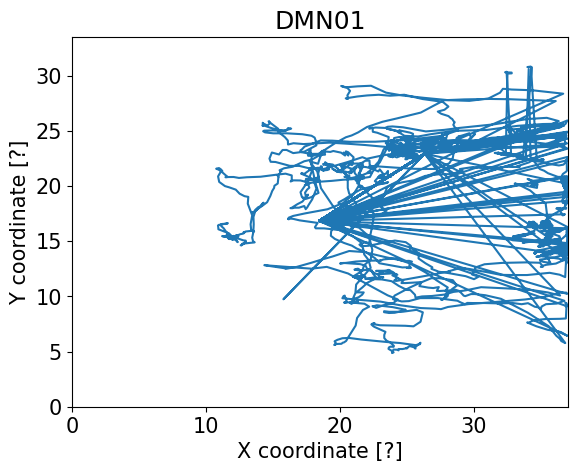

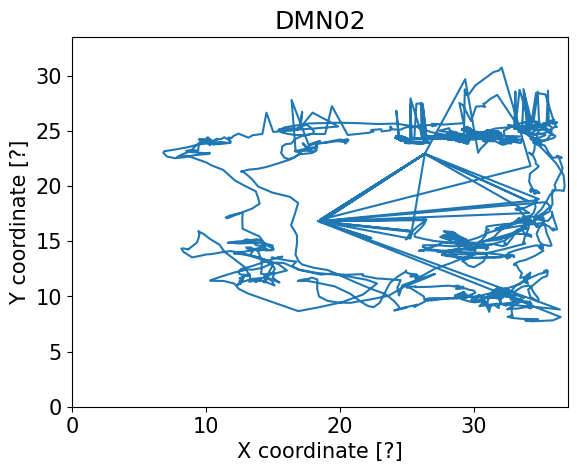

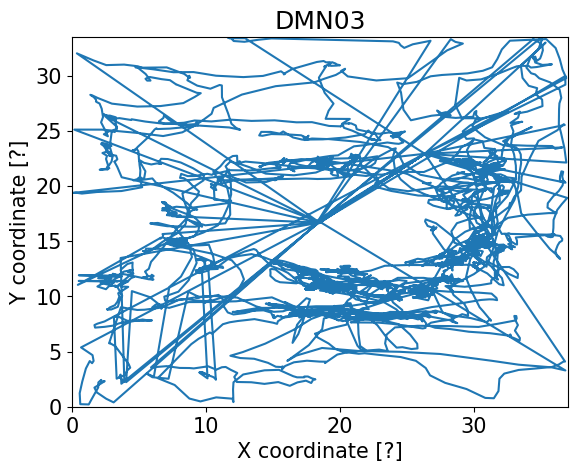

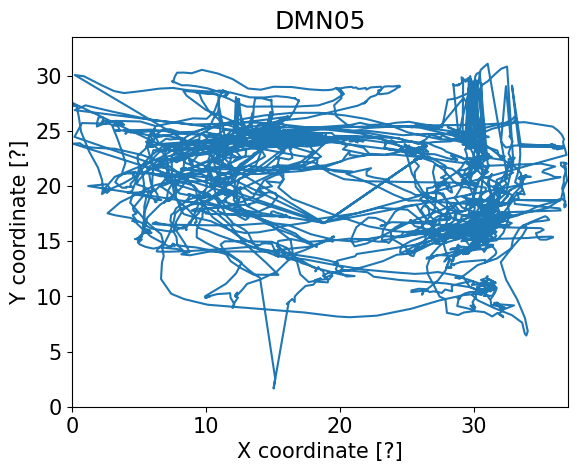

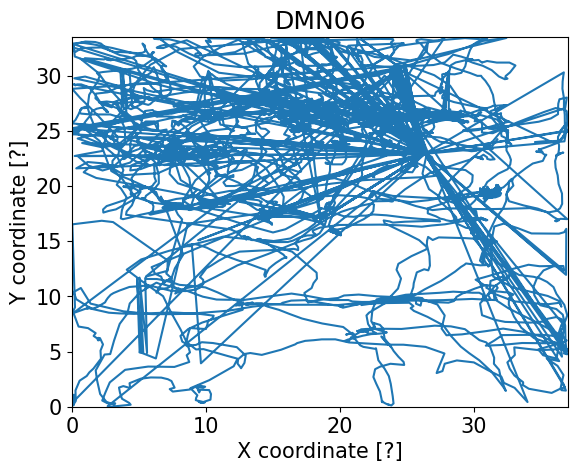

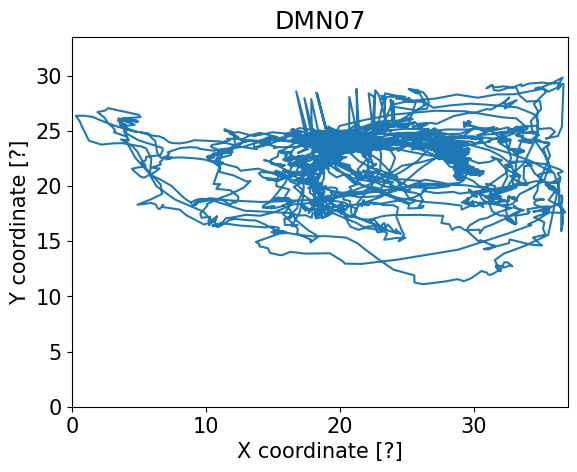

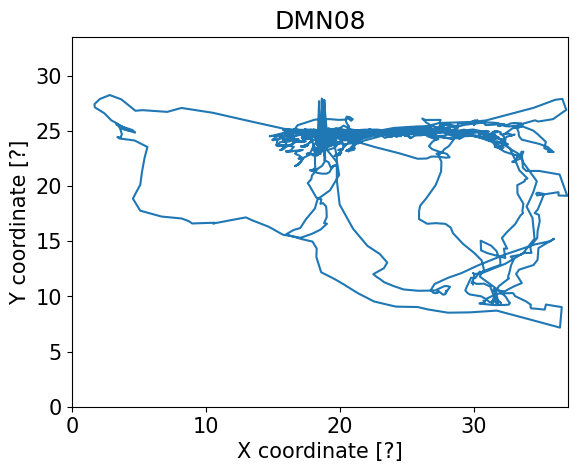

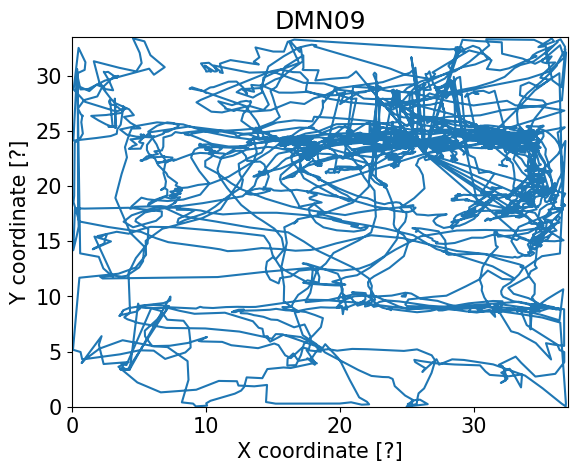

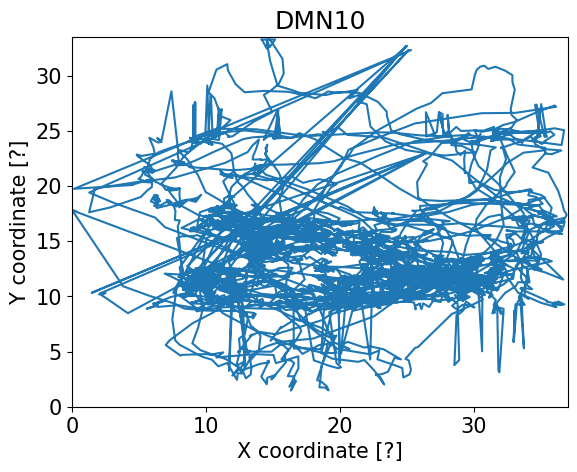

In [3]:
labels_allmice = []

posx_allmice = []
posy_allmice = []

delta_pos_allmice = []
accel_pos_allmice = []
angle_change_allmice = []

idx_keep = []

# cage dimensions, in cm
len_cage_x = 37
len_cage_y = 33.5

dt = 0.1 # s
for key_curr in data_keys:
    if key_curr[:3] == 'DMN':
        # plot head coordinates
        plt.figure()
        head_coord = np.array(data[key_curr])
        # exclude frames where head coord are (0,0) (head cap not detected)
        head_coord[np.sum(head_coord, axis = 1) < 5e-3] = np.nan, np.nan
        idx_curr = np.arange(len(head_coord))[np.logical_not(np.isnan(head_coord[:,0]))]
        idx_keep.append(idx_curr)
        posx = head_coord[:,0][np.logical_not(np.isnan(head_coord[:,0]))]*len_cage_x
        posy = head_coord[:,1][np.logical_not(np.isnan(head_coord[:,1]))]*len_cage_y
        plt.plot(posx, posy)
        plt.xlabel('X coordinate [?]')
        plt.ylabel('Y coordinate [?]')
        plt.title(key_curr)
        plt.xlim(0,len_cage_x)
        plt.ylim(0,len_cage_y)
        
        #%% x and y coords
        posx_allmice.append(posx)
        posy_allmice.append(posy)
        
        #%% linear velocity
        delta_x = np.diff(posx)/dt
        delta_y = np.diff(posy)/dt
        delta_pos = np.sqrt(delta_x**2 + delta_y**2)
        
        #%% angular velocity
        angle_change = np.abs(np.diff(np.arctan2(np.diff(posx),np.diff(posy))))
        angle_change = np.minimum(2*np.pi - angle_change, angle_change)
        
        # linear acceleration
        accel_x = np.diff(delta_x)/dt
        accel_y = np.diff(delta_y)/dt
        accel_pos = np.diff(delta_pos)
        
        delta_pos_allmice.append(delta_pos)
        accel_pos_allmice.append(accel_pos)
        angle_change_allmice.append(angle_change)

In [4]:
# file saving

np.save('delta_pos_allmice_rest.npy',delta_pos_allmice)
np.save('accel_pos_allmice_rest.npy',accel_pos_allmice)
np.save('angle_change_allmice_rest.npy',angle_change_allmice)


C:\Users\trang\anaconda3\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


9
11532
10771
11947
11908
9964
11923
11317
11794
9
11531
10770
11946
11907
9963
11922
11316
11793
9
11531
10770
11946
11907
9963
11922
11316
11793


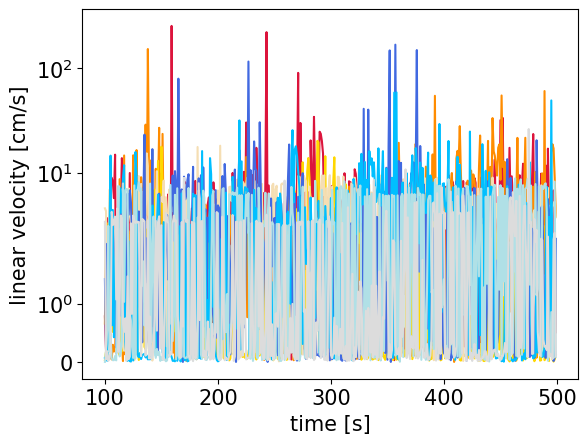

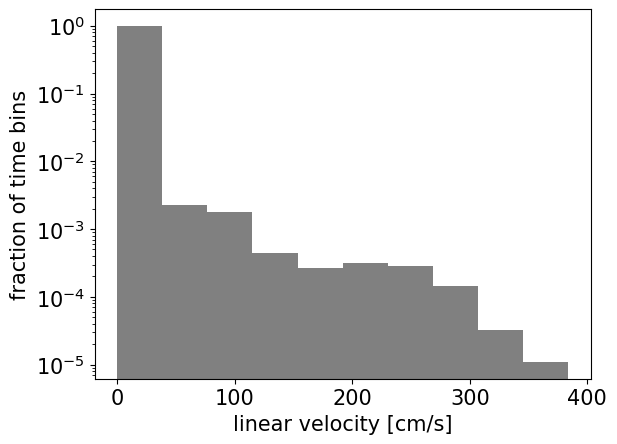

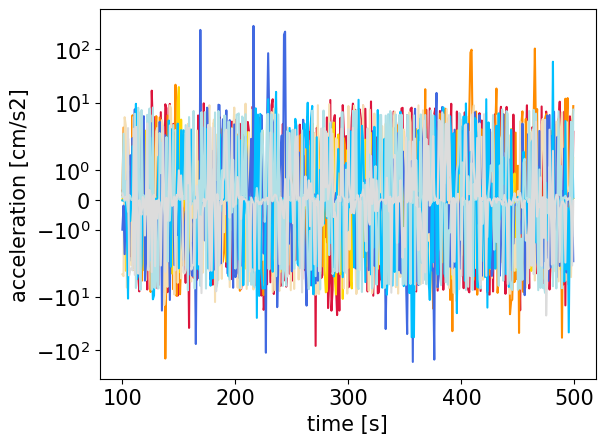

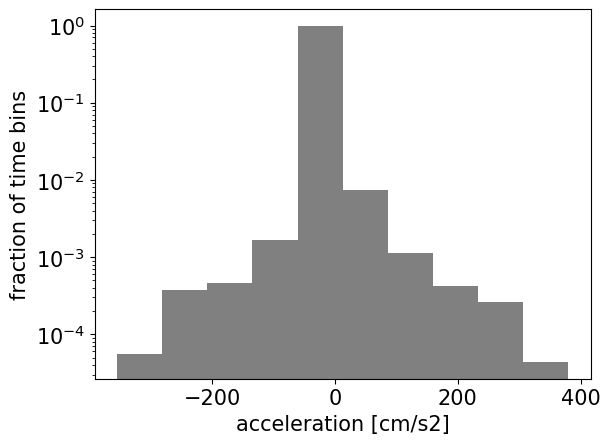

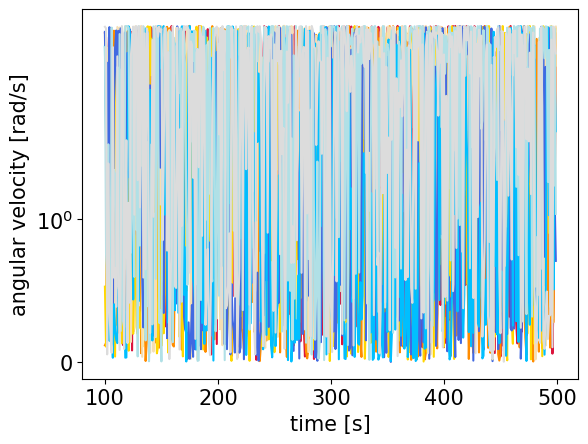

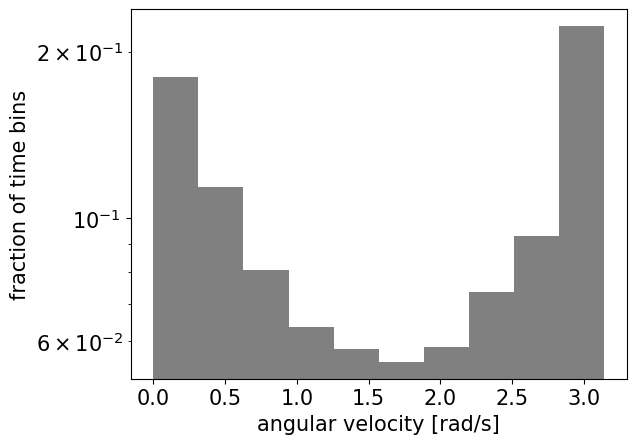

In [10]:
# plotting, for Fig. S6

col_cycle = ['#DC143C', '#FF8C00', '#FFD700', '#F5DEB3', '#4169E1',
             '#00BFFF', '#B0E0E6', '#DCDCDC']

for metric_curr, name_curr in zip([delta_pos_allmice, accel_pos_allmice, angle_change_allmice],
                                  ['linear velocity [cm/s]',
                                  'acceleration [cm/s2]', 
                                   'angular velocity [rad/s]']):
    plt.figure()
    col_ctr = 0
    print(len(metric_curr))
#     plt.imshow(np.array(metric_curr[1:]), aspect = 'auto')
    for metric_rat_curr in metric_curr[1:][::-1]: # time course for each animal
        times = np.arange(len(metric_rat_curr))*dt
        print(len(times))
        times_select = times[1000:5000]
        times_downsamp = times_select[times_select%1==0] # decimate for plotting
        plt.plot(times_downsamp, metric_rat_curr[np.in1d(times, times_downsamp)],
                 color = col_cycle[col_ctr])
        col_ctr += 1
    plt.xlabel('time [s]')
    plt.ylabel(name_curr)
    plt.yscale('symlog')
    plt.savefig('timecourse_'+name_curr[:6]+'.pdf')

    # histogram over all animals
    plt.figure()
    metric_l = np.concatenate(metric_curr[1:])
    plt.hist(metric_l, weights = np.ones_like(metric_l)/len(metric_l), color = '0.5')
    plt.xlabel(name_curr)
    plt.ylabel('fraction of time bins')
    plt.yscale('log')
    plt.savefig('hist_'+name_curr[:6]+'.pdf')

# GCaMP data and head position 
Loading GCaMP data, plotting
Discrete analysis: GCaMP activity across behavioural states obtained from head position
Continuous analysis: correlating GCaMP signals with animal speed, acceleration, and head angle change

In [6]:
#%% load GCaMP data, bandpass
folderpath_gcamp = 'gcamp_data/'
filename_gcamp = 'GCaMP_awake_resting_bandpass013512.mat'
f_gcamp = sio.loadmat(folderpath_gcamp + filename_gcamp)

Nrats = len(f_gcamp['Data'][0])# number of mice

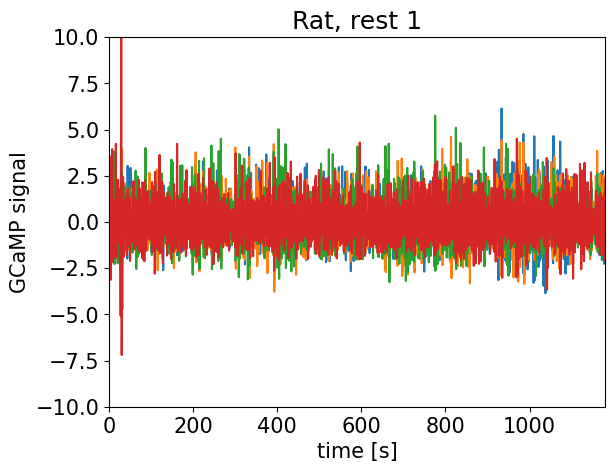

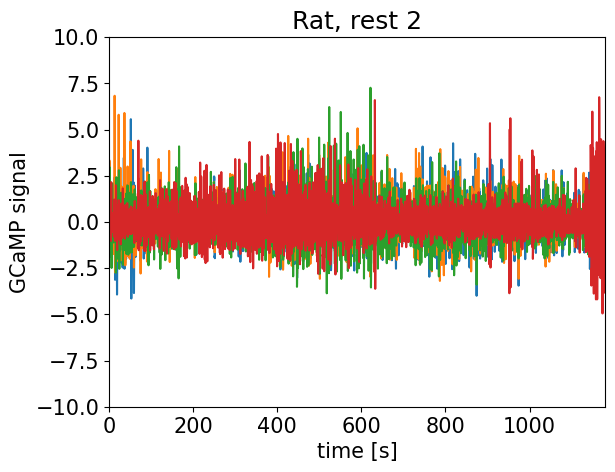

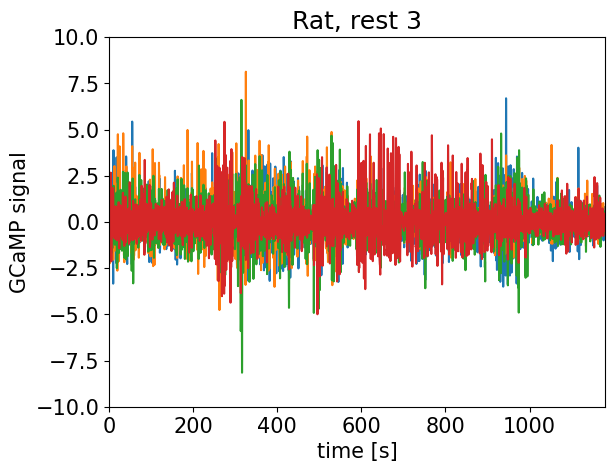

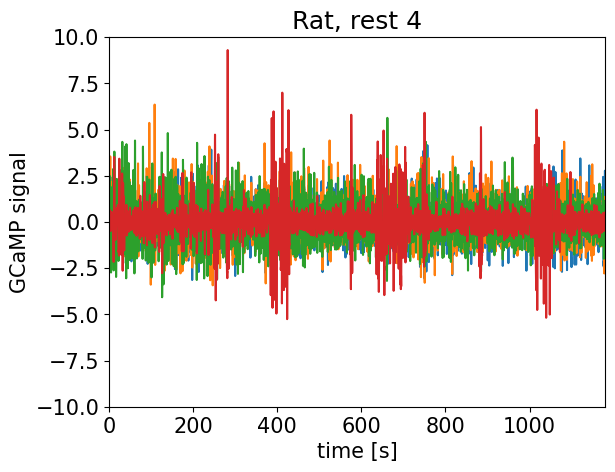

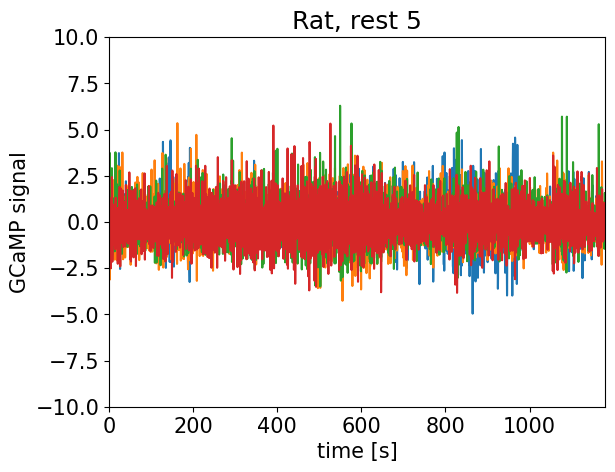

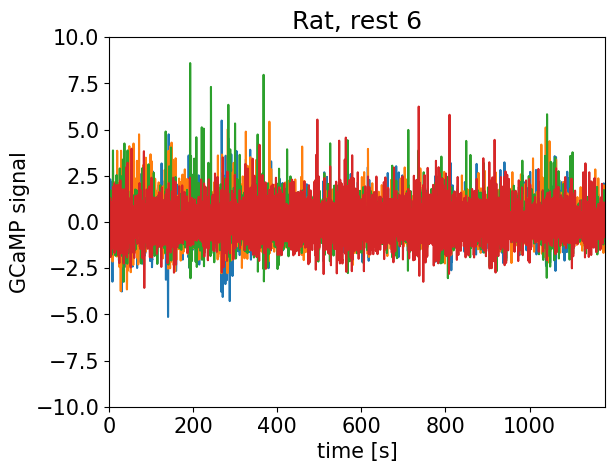

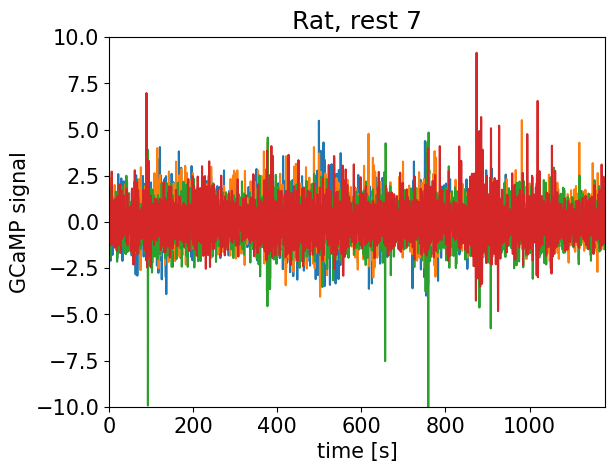

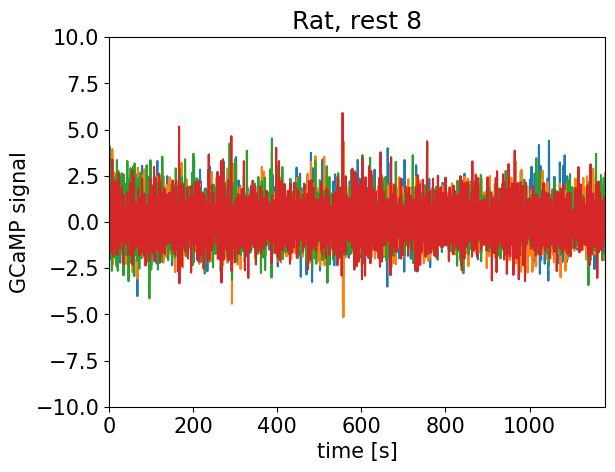

In [7]:
# reading data, excluding time points where head is out of frame
rat_exclude = [0]

rate_slow = []
rate_fast = []
corr_slow = []
corr_fast = []

std_rate_slow = []
std_rate_fast = []
std_corr_slow = []
std_corr_fast = []

cov_mat_full = []

fs = 10. # Hz, sampling rate
gcamp_allmice = []
gcamp_allmice_cut = []
for i_mouse in np.delete(np.arange(Nrats), rat_exclude):
    data_gcamp = {}
    gcamp_m = []
    regions_all = ['RSC', 'ACC', 'mPFC', 'AI']
    
    plt.figure()
    for reg_curr in regions_all:
        data_gcamp[reg_curr] = np.concatenate(\
                  f_gcamp['Data'][0][i_mouse][0][reg_curr][0]) 
        gcamp_m.append(data_gcamp[reg_curr])
        time_s = np.arange(len(data_gcamp[reg_curr]))/fs
        plt.plot(time_s, data_gcamp[reg_curr], label = reg_curr)
    plt.xlabel('time [s]')
    plt.ylabel('GCaMP signal')    
    plt.xlim(0,time_s[-1])
    plt.ylim(-10,10)
    plt.title('Rat, rest ' + str(i_mouse))
    plt.savefig('GCaMP_signal_rat'+str(i_mouse)+'resting.pdf')

    gcamp_m = np.array(gcamp_m)
    gcamp_m = gcamp_m
    
    gcamp_allmice.append(data_gcamp)
    
    # corresponding position labels
    idx_curr = idx_keep[i_mouse]
    
    # remove first and last 100 time bins where signal is unstable
    ncut = 100 
    
    # remove frames where mouse head is out of frame
    idx_cut = idx_curr[np.logical_and(idx_curr > ncut,
                        idx_curr < len(head_coord) - ncut)]
    gcamp_m_cut = gcamp_m[:,idx_cut - ncut]
    
    gcamp_allmice_cut.append(gcamp_m_cut)


# Functional and effective connectivity during exploration 
## for Fig. 2
Pearson correlations and hierarchical clustering, phase lag index, and vector autoregression


RSC-ACC 0.4510341248038095 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC-mPFC 0.20044436253990403 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC-AI 0.08714132067971661 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
ACC-mPFC 0.3247895596322173 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
ACC-AI 0.05534555209601042 WilcoxonResult(statistic=5.0, pvalue=0.078125)
mPFC-AI 0.09218992439779414 WilcoxonResult(statistic=0.0, pvalue=0.0078125)


FDR corrected  RSC-ACC 0.009375
FDR corrected  RSC-mPFC 0.009375
FDR corrected  RSC-AI 0.009375
FDR corrected  ACC-mPFC 0.009375
FDR corrected  ACC-AI 0.078125
FDR corrected  mPFC-AI 0.009375


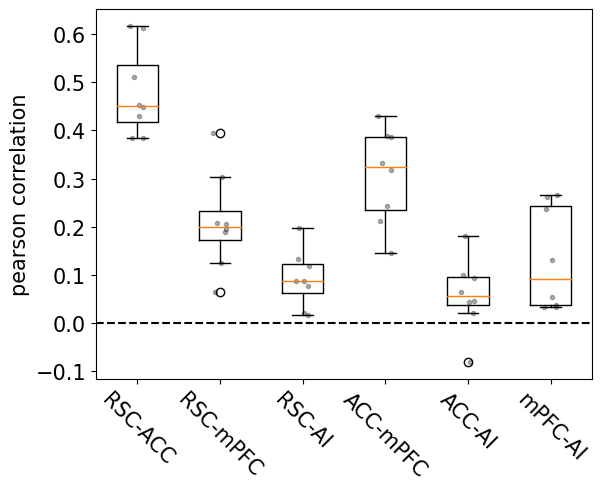

In [8]:
# Pearson correlations, box plot and statistics (Fig. 2A)

pairwise_pearson = []
pairwise_names = []
pairwise_pearson_m = np.ones((len(regions_all), len(regions_all)))
pairwise_pearson_per_rat = np.ones((len(gcamp_allmice_cut), len(regions_all), len(regions_all)))
pval_uncorrected = []
for i_reg in range(len(regions_all)):
    for j_reg in range(i_reg + 1, len(regions_all)):
        pearson_ij = []
        for i_rat in range(len(gcamp_allmice_cut)):
            pearson, pval = stats.pearsonr(gcamp_allmice_cut[i_rat][i_reg],
                                            gcamp_allmice_cut[i_rat][j_reg])
            pearson_ij.append(pearson)
            pairwise_pearson_per_rat[i_rat, i_reg, j_reg] = pearson
            pairwise_pearson_per_rat[i_rat, j_reg, i_reg] = pearson
        pairwise_pearson.append(pearson_ij)
        pairwise_names.append(regions_all[i_reg] +'-'+regions_all[j_reg])
        print(pairwise_names[-1], np.median(pairwise_pearson_per_rat[:,i_reg, j_reg]),
              stats.wilcoxon(pearson_ij))
        pval_uncorrected.append(stats.wilcoxon(pearson_ij)[1])
        pairwise_pearson_m[i_reg, j_reg] = pearson
        pairwise_pearson_m[j_reg, i_reg] = pearson

print('\n')
plt.figure()
plt.boxplot(pairwise_pearson)
ctr_plot = 0
shifts = (np.random.rand(len(pairwise_pearson[0])) - 0.5)*0.2 + 1
for ii in pairwise_pearson:
    plt.plot(ctr_plot + shifts, ii, 'k.', 
             alpha = 0.3)
    ctr_plot += 1
plt.xticks(np.arange(len(pairwise_pearson)) + 1, pairwise_names, rotation = -45)
plt.ylabel('pearson correlation')
plt.axhline(0, color = 'k', linestyle = '--')
plt.savefig('pairwise_covariance_rest.pdf')

# FDR CORRECTION
rej, pval_corrected = fdrcorrection(pval_uncorrected)
ctr = 0
for ii_reg in range(len(pairwise_names)):
        print('FDR corrected ', pairwise_names[ii_reg],
              pval_corrected[ctr])
        ctr += 1


In [16]:
# stats, comparing region pairs

pval_uncorrected = []

for i_pair in range(len(pairwise_pearson)):
    for j_pair in range(i_pair + 1, len(pairwise_pearson)):
        wilcox_curr, pval_curr = stats.wilcoxon(pairwise_pearson[i_pair],
                                                pairwise_pearson[j_pair])
        pval_uncorrected.append(pval_curr)

# FDR CORRECTION
rej, pval_corrected = fdrcorrection(pval_uncorrected)
ctr = 0
for i_pair in range(len(pairwise_names)):
    for j_pair in range(i_pair + 1, len(pairwise_names)):
        print('FDR corrected ', pairwise_names[i_pair], pairwise_names[j_pair], 
              pval_corrected[ctr])
        ctr += 1
print(ctr)

FDR corrected  RSC-ACC RSC-mPFC 0.016741071428571428
FDR corrected  RSC-ACC RSC-AI 0.016741071428571428
FDR corrected  RSC-ACC ACC-mPFC 0.016741071428571428
FDR corrected  RSC-ACC ACC-AI 0.016741071428571428
FDR corrected  RSC-ACC mPFC-AI 0.016741071428571428
FDR corrected  RSC-mPFC RSC-AI 0.03515625
FDR corrected  RSC-mPFC ACC-mPFC 0.03515625
FDR corrected  RSC-mPFC ACC-AI 0.03515625
FDR corrected  RSC-mPFC mPFC-AI 0.4609375
FDR corrected  RSC-AI ACC-mPFC 0.016741071428571428
FDR corrected  RSC-AI ACC-AI 0.09014423076923077
FDR corrected  RSC-AI mPFC-AI 0.26785714285714285
FDR corrected  ACC-mPFC ACC-AI 0.016741071428571428
FDR corrected  ACC-mPFC mPFC-AI 0.09014423076923077
FDR corrected  ACC-AI mPFC-AI 0.07457386363636365
15


[[1.         0.510362   0.20814184 0.19716936]
 [0.510362   1.         0.33245169 0.17990054]
 [0.20814184 0.33245169 1.         0.26196229]
 [0.19716936 0.17990054 0.26196229 1.        ]] 8


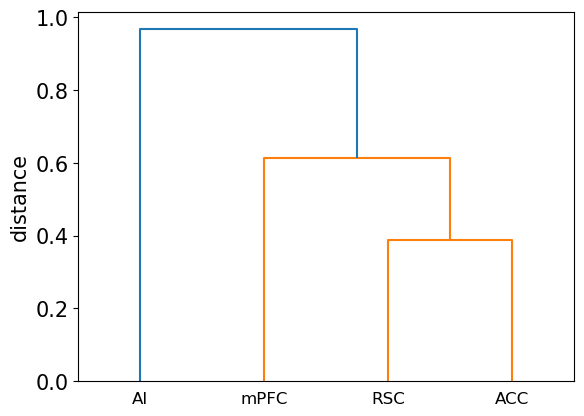

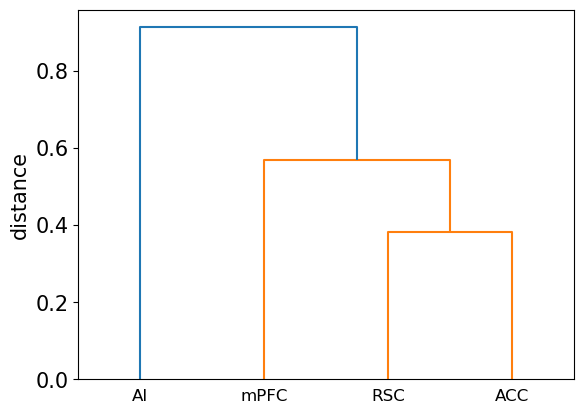

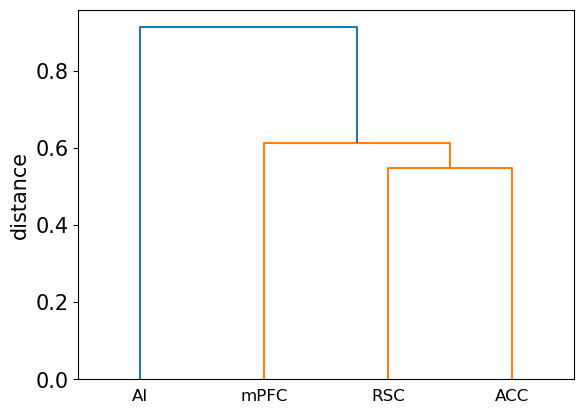

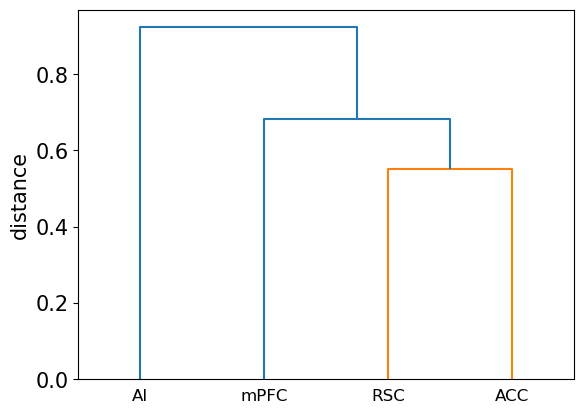

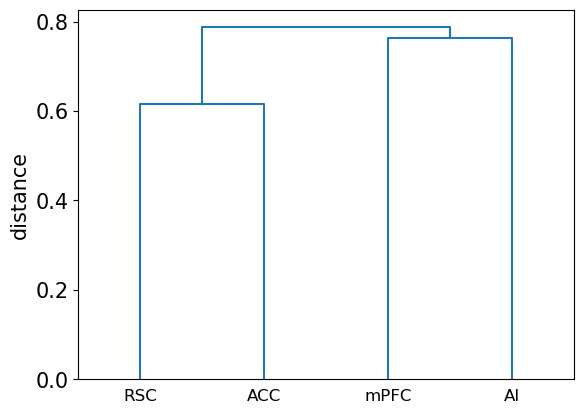

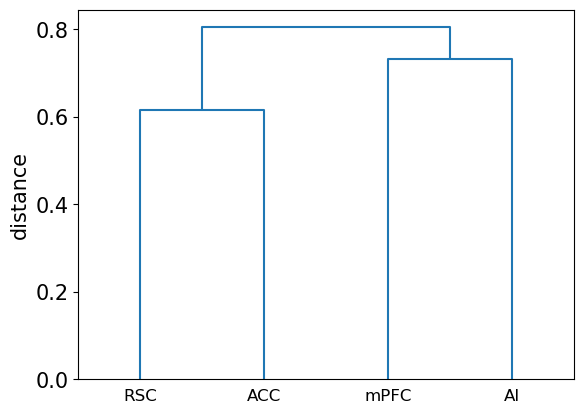

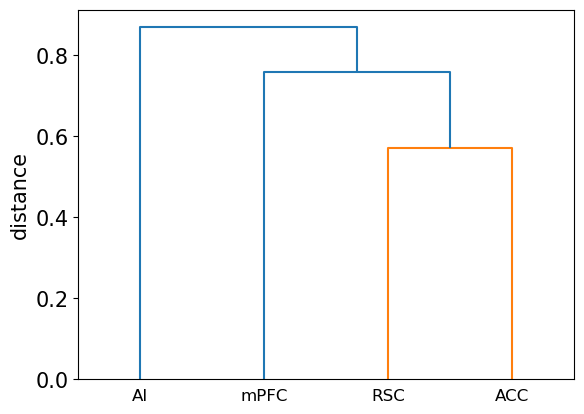

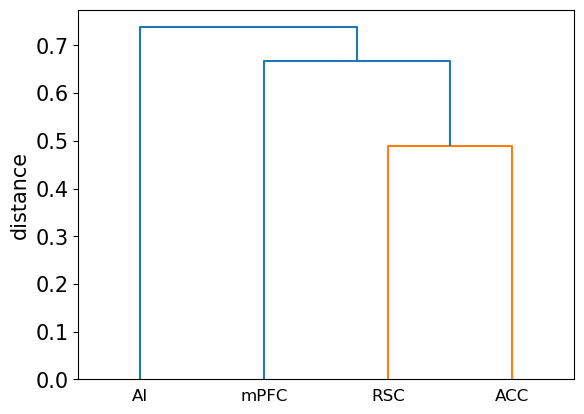

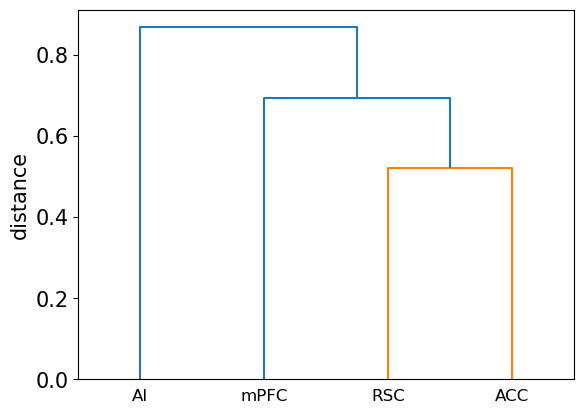

In [14]:
# Hierarchical clustering, dendrogram (Fig. 2B)

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

print(pairwise_pearson_m, len(gcamp_allmice_cut))

for pearson_rat_curr in pairwise_pearson_per_rat:
    # dendrogram for each rat
    plt.figure()
    dists = squareform(1 - pearson_rat_curr)
    linkage_matrix = linkage(dists, "single")
    dendrogram(linkage_matrix, labels=regions_all)
    plt.ylabel('distance')

# from average functional connectivity over rats
plt.figure()
dists = squareform(1 - np.mean(pairwise_pearson_per_rat, axis = 0))
linkage_matrix = linkage(dists, "single")
dendrogram(linkage_matrix, labels=regions_all)
plt.ylabel('distance')    
plt.savefig('dendrogram_rest.pdf')

['RSC', 'ACC', 'mPFC', 'AI']


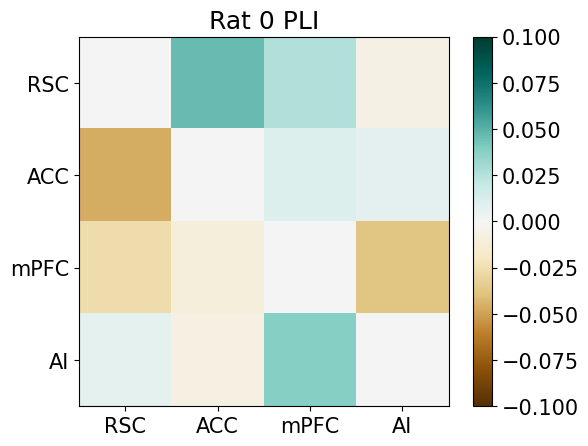

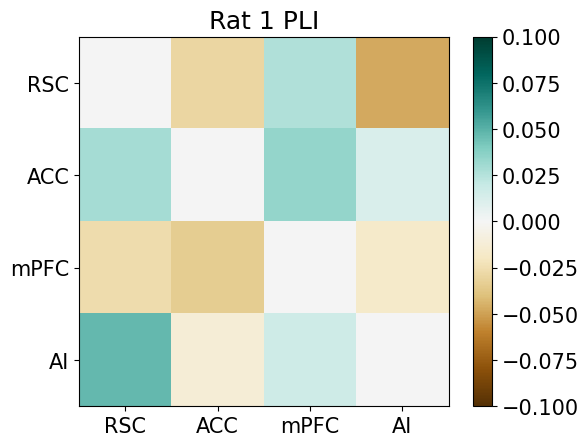

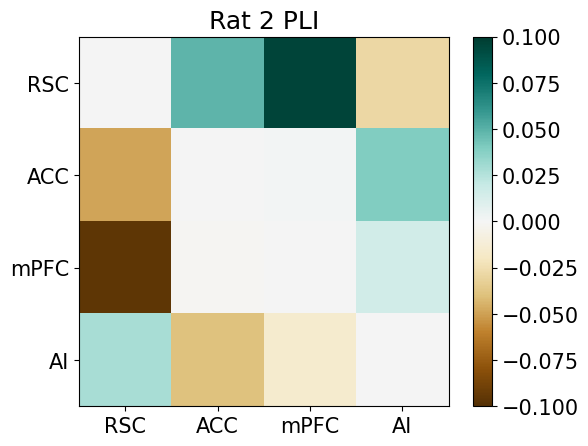

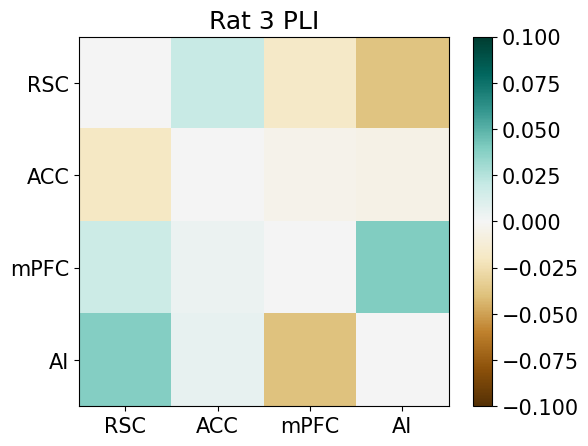

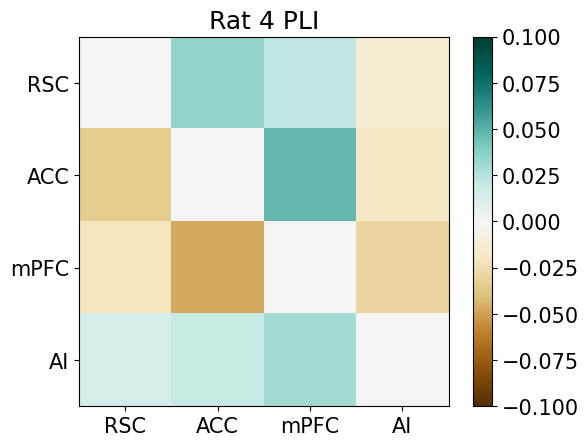

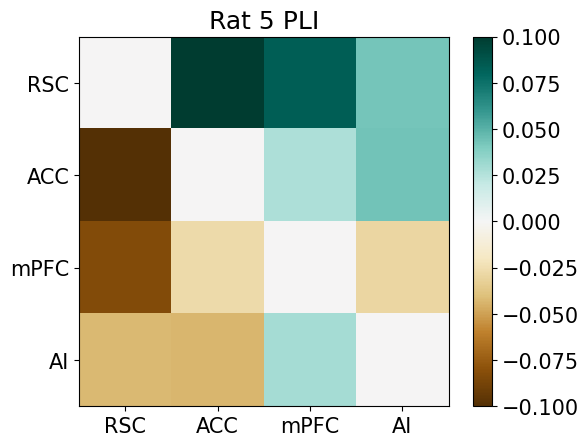

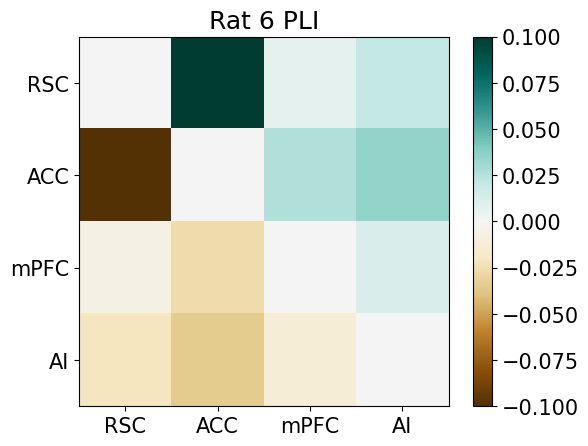

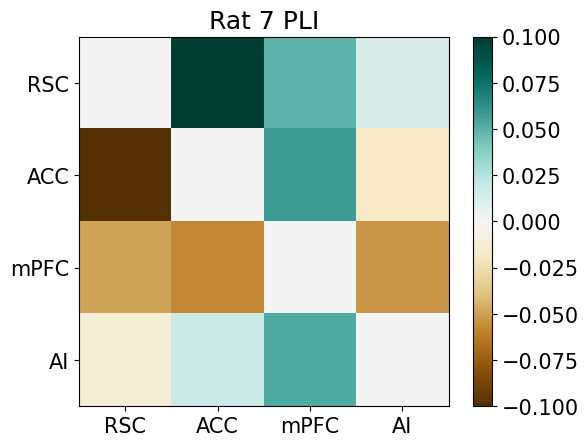

In [20]:
# Phase lag index (PLI, Fig. 2C)

print(regions_all)
# Hilbert transform
def phase_lag_index(phase0, phase1):
    return np.mean(np.sign(phase0 - phase1))

PLI_allrats = []
phase_allrats = []
# compute phase
ctr_rat = 0
for gcamp_curr in gcamp_allmice:    
    phase_curr = np.zeros((len(regions_all),
                           len(gcamp_curr['RSC'])))
    ctr_reg = 0
    for region_curr in regions_all:
        phase_curr[ctr_reg] = np.angle(signal.hilbert(gcamp_curr[region_curr]))
        ctr_reg += 1
    phase_allrats.append(phase_curr)

    # phase lag index matrix
    PLI_all = np.zeros((len(regions_all), len(regions_all)))
    for ii_phase in range(len(regions_all)):
        for jj_phase in range(ii_phase, len(regions_all)):
            PLI_all[ii_phase, jj_phase] = phase_lag_index(phase_curr[ii_phase],
                                                         phase_curr[jj_phase])
            PLI_all[jj_phase, ii_phase] = -PLI_all[ii_phase, jj_phase]
    plt.figure()
    plt.imshow(PLI_all, vmin = -0.1, vmax = 0.1, cmap = 'BrBG')
    plt.colorbar()
    plt.xticks(np.arange(len(regions_all)), 
             regions_all)
    plt.yticks(np.arange(len(regions_all)), 
             regions_all)    
    plt.title('Rat '+str(ctr_rat)+' PLI')

    PLI_allrats.append(PLI_all)
    ctr_rat += 1
    

RSC to ACC :  0.07239406779661017 WilcoxonResult(statistic=2.0, pvalue=0.0234375)
RSC to mPFC :  0.03629237288135593 WilcoxonResult(statistic=2.0, pvalue=0.0234375)
RSC to AI :  -0.007457627118644069 WilcoxonResult(statistic=13.0, pvalue=0.546875)
ACC to mPFC :  0.02485169491525424 WilcoxonResult(statistic=2.0, pvalue=0.0234375)
ACC to AI :  0.011673728813559322 WilcoxonResult(statistic=10.0, pvalue=0.3125)
mPFC to AI :  -0.0125 WilcoxonResult(statistic=10.0, pvalue=0.3125)
[[0.         0.07239407 0.03629237 0.        ]
 [0.         0.         0.02485169 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


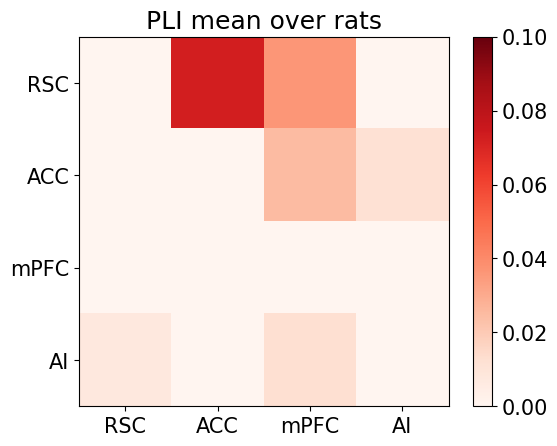

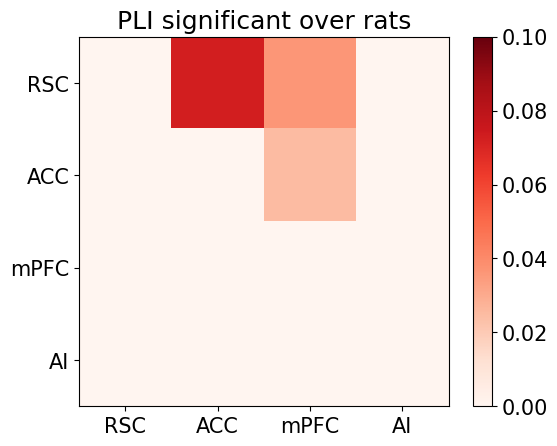

In [49]:
# PLI plot as heatmap
# mean over rats
PLI_mean = np.mean(np.array(PLI_allrats), axis = 0)

plt.figure()
plt.imshow(PLI_mean, vmin = 0., vmax = 0.1, cmap = 'Reds')
plt.colorbar()
plt.xticks(np.arange(len(regions_all)), 
         regions_all)
plt.yticks(np.arange(len(regions_all)), 
         regions_all)    
plt.title('PLI mean over rats')
plt.savefig('PLI_resting.pdf')

PLI_mean_sig = np.zeros_like(PLI_mean) # significant PLI > 0 over rats only
for ii_reg in range(len(regions_all)):
    for jj_reg in range(ii_reg + 1, len(regions_all)):
        wilcox_curr = stats.wilcoxon(np.array(PLI_allrats)[:,ii_reg, jj_reg])
        print(regions_all[ii_reg] +' to '+ regions_all[jj_reg], ': ', 
              PLI_mean[ii_reg, jj_reg], wilcox_curr)
        if wilcox_curr[1] < 0.05:
            PLI_mean_sig[ii_reg, jj_reg] = PLI_mean[ii_reg, jj_reg]

plt.figure()
plt.imshow(PLI_mean_sig, vmin = 0., vmax = 0.1, cmap = 'Reds')
plt.colorbar()
plt.xticks(np.arange(len(regions_all)), 
         regions_all)
plt.yticks(np.arange(len(regions_all)), 
         regions_all)    
plt.title('PLI significant over rats')
plt.savefig('PLI_resting_thresh_wilcox.pdf')

print(PLI_mean_sig)

RSC to ACC 0.07239406779661017 0.07239406779661017 334 WilcoxonResult(statistic=2.0, pvalue=0.0234375)
RSC to mPFC 0.03629237288135593 0.03629237288135593 103 WilcoxonResult(statistic=2.0, pvalue=0.0234375)
RSC to AI -0.007457627118644068 0.03629237288135593 103 WilcoxonResult(statistic=13.0, pvalue=0.546875)
ACC to RSC -0.07239406779661017 -0.07239406779661017 -589 WilcoxonResult(statistic=2.0, pvalue=0.0234375)
ACC to mPFC 0.02485169491525424 0.02485169491525424 30 WilcoxonResult(statistic=2.0, pvalue=0.0234375)
ACC to AI 0.011673728813559322 0.02485169491525424 30 WilcoxonResult(statistic=10.0, pvalue=0.3125)
mPFC to RSC -0.03629237288135593 -0.03629237288135593 -358 WilcoxonResult(statistic=2.0, pvalue=0.0234375)
mPFC to ACC -0.02485169491525424 -0.02485169491525424 -285 WilcoxonResult(statistic=2.0, pvalue=0.0234375)
mPFC to AI -0.012499999999999999 -0.02485169491525424 -285 WilcoxonResult(statistic=10.0, pvalue=0.3125)
AI to RSC 0.007457627118644068 -0.02485169491525424 -285 Wilc

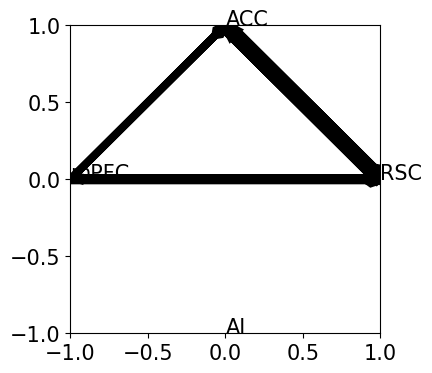

In [22]:
# PLI plot as arrows on circle 
PLI_allrats = np.array(PLI_allrats)
plt.figure(figsize = (4,4))
angles = np.linspace(0, 2*np.pi, len(regions_all) + 1)

# cmap = plt.get_cmap('viridis_r')

col_max = 0.06 
col_min = 0.02
for iiparam in range(len(regions_all)):
    plt.text(np.cos(angles[iiparam]), np.sin(angles[iiparam]), 
             regions_all[iiparam])
    
    for jjparam in range(len(regions_all)):
        if iiparam != jjparam:
            if stats.wilcoxon(PLI_allrats[:, iiparam, jjparam])[1] < 0.05:                
                weight_curr = np.mean(PLI_allrats[:, iiparam, jjparam])
                col_curr = int((weight_curr - col_min)/(col_max - col_min)*255)
                plt.arrow(np.cos(angles[iiparam]), np.sin(angles[iiparam]), 
                          np.cos(angles[jjparam]) - np.cos(angles[iiparam]),
                          np.sin(angles[jjparam]) - np.sin(angles[iiparam]),
                          length_includes_head = True,
                          color = 'k', head_width = 0.05, 
                         linewidth = (weight_curr - col_min)/(col_max - col_min)*5)
            print(regions_all[iiparam], 'to', regions_all[jjparam], 
                  np.mean(PLI_allrats[:, iiparam, jjparam]), weight_curr, col_curr,
                 stats.wilcoxon(PLI_allrats[:, iiparam, jjparam]))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.savefig('PLI_weights_arrows_resting.pdf')
np.save('PLI_allrats_resting.npy', PLI_allrats)

In [27]:
# Multivariate vector autoregression (MVAR, Fig. 2D)

# create variable dictionary
vars_GCaMP_only_allrats = {}
df_all = []

gcamp_mean = []
y_variance = []

Xc_allrats = []
Yc_allrats = []
for i_rat in range(len(gcamp_allmice_cut)):
    plt.figure(figsize = (5,5))

    # make variable dictionary
    vars_for_cca = {}
    
    #GCaMP, per region
    gcamp_vars = gcamp_allmice_cut[i_rat]
    
    ctr_reg = 0
    
    for region_curr in regions_all:
        vars_for_cca[region_curr] = gcamp_vars[ctr_reg]
        ctr_reg += 1

    vars_GCaMP_only_allrats[i_rat] = vars_for_cca

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [33]:
# fit MVAR
from statsmodels.tsa.api import VAR

Nkeys = len(vars_GCaMP_only_allrats[0].keys())
print(Nkeys)
params_allrats = np.zeros((len(vars_GCaMP_only_allrats), Nkeys, Nkeys))

for i_rat in range(len(vars_GCaMP_only_allrats)):
    var_df = pd.DataFrame(data=vars_GCaMP_only_allrats[i_rat])
    
    # fit model
    model = VAR(var_df)
    results = model.fit(1) #argument is order of the model i.e. number of time steps back taken into account
    
    # model results
    print(i_rat, results.summary())
    params_var = results.params
    
    # save params to array
    key_ctr = 0
    for key_curr in params_var.keys():
        params_allrats[i_rat, key_ctr, :] = params_var[key_curr][1:]
        key_ctr += 1


4
0   Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 01, Aug, 2023
Time:                     15:50:05
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -9.66198
Nobs:                     11593.0    HQIC:                  -9.67040
Log likelihood:          -9699.79    FPE:                6.28556e-05
AIC:                     -9.67467    Det(Omega_mle):     6.27473e-05
--------------------------------------------------------------------
Results for equation RSC
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.000205         0.002749            0.074           0.941
L1.RSC          0.965551         0.003500          275.841           0.000
L1.ACC         -0.021186         0.003714           -5.704           0.000
L1.mPFC

6   Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 01, Aug, 2023
Time:                     15:50:05
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -9.56458
Nobs:                     10570.0    HQIC:                  -9.57369
Log likelihood:          -9351.26    FPE:                6.92126e-05
AIC:                     -9.57833    Det(Omega_mle):     6.90818e-05
--------------------------------------------------------------------
Results for equation RSC
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.000594         0.002735            0.217           0.828
L1.RSC          0.965101         0.003249          297.082           0.000
L1.ACC         -0.030091         0.003158           -9.528           0.000
L1.mPFC  

KruskalResult(statistic=11.923295454545453, pvalue=0.007650590336142383)
outflow RSC ACC WilcoxonResult(statistic=10.0, pvalue=0.3125)
outflow RSC mPFC WilcoxonResult(statistic=1.0, pvalue=0.015625)
outflow RSC AI WilcoxonResult(statistic=3.0, pvalue=0.0390625)
outflow ACC mPFC WilcoxonResult(statistic=0.0, pvalue=0.0078125)
outflow ACC AI WilcoxonResult(statistic=0.0, pvalue=0.0078125)
outflow mPFC AI WilcoxonResult(statistic=17.0, pvalue=0.9453125)
FDR corrected  RSC ACC 0.375
FDR corrected  RSC mPFC 0.03125
FDR corrected  RSC AI 0.05859375
FDR corrected  ACC mPFC 0.0234375
FDR corrected  ACC AI 0.0234375
FDR corrected  mPFC AI 0.9453125


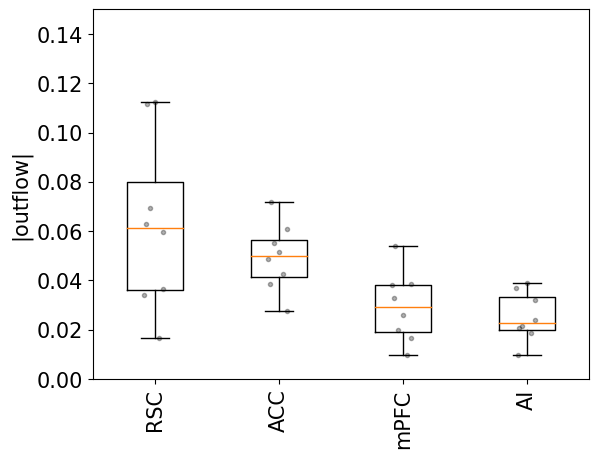

In [35]:
# MVAR absolute value outflow from each node

outflow_allrats = []
flowdiff_allrats = []
for iiparam in range(len(params_var.keys())):
    # discard self weights
    idx = np.arange(len(params_var.keys())) != iiparam

    # outflow and difference
    outflow = np.sum(np.abs(params_allrats[:, idx, iiparam]), axis = 1)
    outflow_allrats.append(outflow)

    # inflow
    inflow = np.sum(np.abs(params_allrats[:, iiparam, idx]), axis = 1)
    flowdiff_allrats.append(outflow - inflow)

#     inflow_allrats.append(inflow[np.arange(len(params_var.keys()))])
#     outflow = np.sum(params_allrats[:, :, iiparam], axis = 1)
    
plt.figure()
plt.boxplot(outflow_allrats)
ctr_plot = 0
shifts = (np.random.rand(len(outflow_allrats[0])) - 0.5)*0.2 + 1
for ii in outflow_allrats:
    plt.plot(ctr_plot + shifts, ii, 'k.', 
             alpha = 0.3)
    ctr_plot += 1
plt.xticks(np.arange(len(params_var.keys())) + 1, params_var.keys(), rotation = 90)
plt.ylabel('|outflow|')
plt.ylim(0, 0.15)
plt.savefig('VAR_GCaMP_only_outflow_abs_box.pdf')
print(stats.kruskal(*outflow_allrats))

pval_uncorrected = []
for i_reg in range(len(regions_all)):
    for j_reg in range(i_reg + 1, len(regions_all)):
        print('outflow', regions_all[i_reg], regions_all[j_reg],
              stats.wilcoxon(outflow_allrats[i_reg], 
                             outflow_allrats[j_reg]))
        pval_uncorrected.append(stats.wilcoxon(outflow_allrats[i_reg], 
                             outflow_allrats[j_reg])[1])
# FDR CORRECTION
rej, pval_corrected = fdrcorrection(pval_uncorrected)
ctr = 0
for i_reg in range(len(regions_all)):
    for j_reg in range(i_reg + 1, len(regions_all)):
        print('FDR corrected ', regions_all[i_reg],regions_all[j_reg],
              pval_corrected[ctr])
        ctr += 1


# Correlations between GCaMP signals and rat kinematics
## Correlations with linear velocity, angular velocity, and acceleration

In [40]:
# Correlation between GCaMP and linear velocity 
pearson_speed_allmice = {}

reg_ctr = 0
for reg_curr in regions_all:
    pearson_speed_allmice[reg_curr] = []
    for i_mouse in range(len(delta_pos_allmice)-1):
        ncut = 100 
        delta_pos_curr = delta_pos_allmice[i_mouse + 1]
        idx_curr = idx_keep[i_mouse + 1]
        delta_pos_cut = delta_pos_curr[np.logical_and(idx_curr[:len(delta_pos_curr)] > ncut,
                        idx_curr[:len(delta_pos_curr)] < 12000 - ncut)]

        pearson,pval = stats.pearsonr(delta_pos_cut, gcamp_allmice_cut[i_mouse][reg_ctr])
        pearson_speed_allmice[reg_curr].append(pearson)
        print(reg_curr, i_mouse, pearson, pval)  
    reg_ctr += 1
    
print(pearson_speed_allmice)

RSC 0 0.03084600381578262 0.0008944222408820351
RSC 1 0.04337511434694594 4.74843141885124e-06
RSC 2 0.09041397477003005 1.0314495462152421e-22
RSC 3 0.0010327268586466064 0.9184565567958003
RSC 4 0.11395305936447762 3.840420813493229e-35
RSC 5 0.13367049901090233 5.714589618631384e-48
RSC 6 0.11623678458946175 4.000568645687196e-33
RSC 7 0.06652992120054693 1.3478424980443674e-12
ACC 0 0.01462037968523817 0.11544811094493938
ACC 1 0.044645637800929006 2.4800313887708677e-06
ACC 2 0.09397308410357108 2.052332998010301e-24
ACC 3 -0.01147200932288194 0.2554126008182158
ACC 4 0.04316092306639187 2.985108804564453e-06
ACC 5 0.007239235509131053 0.4327227158468344
ACC 6 0.0074108177396381815 0.4461397967947377
ACC 7 0.031093392266321202 0.0009316776669201377
mPFC 0 0.009597046069101207 0.3014735778577287
mPFC 1 0.007746887898496286 0.41401948252403287
mPFC 2 0.028359181257229842 0.002133794429289542
mPFC 3 -0.003665195016159101 0.7163466292477613
mPFC 4 0.0024970399590185763 0.7870371132748

In [41]:
# Correlations between GCaMP and angular velocity
pearson_angle_allmice = {}
reg_ctr = 0

for reg_curr in regions_all:
    pearson_angle_allmice[reg_curr] = []
    for i_mouse in range(len(angle_change_allmice)-1):
        ncut = 100 
        delta_pos_curr = angle_change_allmice[i_mouse + 1]
        idx_curr = idx_keep[i_mouse + 1]
        delta_pos_cut = delta_pos_curr[np.logical_and(idx_curr[:len(delta_pos_curr)] > ncut,
                        idx_curr[:len(delta_pos_curr)] < 12000 - ncut)]

        pearson,pval = stats.pearsonr(delta_pos_cut, gcamp_allmice_cut[i_mouse][reg_ctr])
        pearson_angle_allmice[reg_curr].append(pearson)
        print(reg_curr, i_mouse, pearson, pval)  
    reg_ctr += 1

RSC 0 -0.047760707339367256 2.674685792759179e-07
RSC 1 -0.07189654021776898 3.1851769964226175e-14
RSC 2 -0.086379559925926 7.289454818158618e-21
RSC 3 -0.10771284893937844 9.22079681383528e-27
RSC 4 -0.05800378945839857 3.3676651269860073e-10
RSC 5 -0.0734032208269379 1.6441891343127733e-15
RSC 6 -0.07606881851235171 4.8220942411180355e-15
RSC 7 -0.08418724558211435 2.7865516743073567e-19
ACC 0 -0.029197728541299275 0.0016653615017762189
ACC 1 -0.06590929520224945 3.47565701510593e-12
ACC 2 -0.07702503851242247 6.734890111224648e-17
ACC 3 -0.07444216065384486 1.468451164565069e-13
ACC 4 -0.029317045435476988 0.001511063034823575
ACC 5 -0.02291208243853113 0.013015124166567762
ACC 6 -0.02151843418924038 0.026937640315915064
ACC 7 -0.04961128713450588 1.2647252361103767e-07
mPFC 0 -0.013856047767990631 0.13573407720605454
mPFC 1 -0.028073683613216736 0.0030698039671457544
mPFC 2 -0.047180447517867596 3.2066405340176864e-07
mPFC 3 -0.030634683926214552 0.0023843550433616536
mPFC 4 -0.00

In [42]:
# Correlations between GCaMP and acceleration
pearson_accel_allmice = {}

reg_ctr = 0
for reg_curr in regions_all:
    pearson_accel_allmice[reg_curr] = []
    for i_mouse in range(len(accel_pos_allmice)-1):
        ncut = 100 
        delta_pos_curr = accel_pos_allmice[i_mouse + 1]
        idx_curr = idx_keep[i_mouse + 1]
        delta_pos_cut = delta_pos_curr[np.logical_and(idx_curr[:len(delta_pos_curr)] > ncut,
                        idx_curr[:len(delta_pos_curr)] < 12000 - ncut)]

        pearson,pval = stats.pearsonr(delta_pos_cut, gcamp_allmice_cut[i_mouse][reg_ctr])
        pearson_accel_allmice[reg_curr].append(pearson)
        print(reg_curr, i_mouse, pearson, pval)  
    reg_ctr += 1

RSC 0 -0.001890604498123604 0.838705246807508
RSC 1 -0.014276695078917906 0.13221995672837314
RSC 2 -0.01666335598414164 0.07120025811071312
RSC 3 0.0038693963613980267 0.7012829459165957
RSC 4 -0.035558767255914836 0.00011889683296540846
RSC 5 -0.04155876585919746 6.613738615391652e-06
RSC 6 -0.030498527031133163 0.0017122485494631486
RSC 7 -0.021700579484282462 0.020883483292469994
ACC 0 0.004322850402665663 0.6416330059046097
ACC 1 -0.013193699547700827 0.16416528103201186
ACC 2 -0.019830042960541767 0.031783085837542045
ACC 3 0.012979190560628576 0.19818841236799936
ACC 4 -0.011069389735165965 0.23105110146086252
ACC 5 -0.0030544645125911048 0.7406298801712977
ACC 6 -0.0014325629619278066 0.8829172163800936
ACC 7 -0.014262242812437854 0.12897605909632842
mPFC 0 0.0005153485018278368 0.9557525605915711
mPFC 1 -0.00498235355170747 0.599346572108329
mPFC 2 -0.007289476665932056 0.42998807177503134
mPFC 3 -0.0006237329197276049 0.9506958329656108
mPFC 4 0.005166717826007746 0.576161000

linear velocity
RSC 0.07847194798528849 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
ACC 0.022856885975779687 WilcoxonResult(statistic=3.0, pvalue=0.0390625)
mPFC 0.008671966983798747 WilcoxonResult(statistic=3.0, pvalue=0.0390625)
AI -0.002483461893153872 WilcoxonResult(statistic=14.0, pvalue=0.640625)
[0.0078125, 0.0390625, 0.0390625, 0.640625]
FDR corrected  RSC 0.03125
FDR corrected  ACC 0.052083333333333336
FDR corrected  mPFC 0.052083333333333336
FDR corrected  AI 0.640625
angular velocity
RSC -0.0747360196696448 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
ACC -0.039464166284991435 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
mPFC -0.020964865690603685 WilcoxonResult(statistic=2.0, pvalue=0.0234375)
AI -0.0005934763449145456 WilcoxonResult(statistic=11.0, pvalue=0.3828125)
[0.0078125, 0.0078125, 0.0234375, 0.3828125]
FDR corrected  RSC 0.015625
FDR corrected  ACC 0.015625
FDR corrected  mPFC 0.03125
FDR corrected  AI 0.3828125
acceleration
RSC -0.019181967734212053 Wilc

<Figure size 640x480 with 0 Axes>

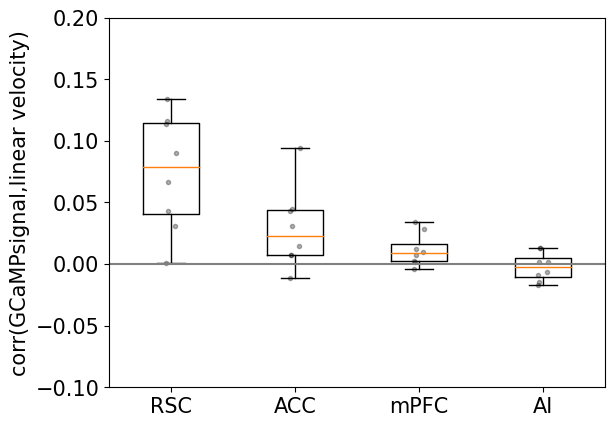

<Figure size 640x480 with 0 Axes>

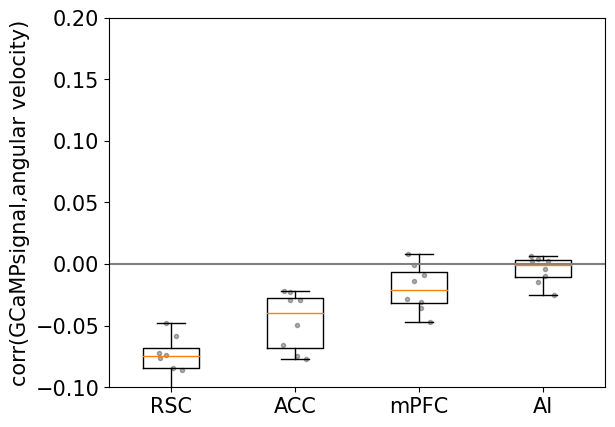

<Figure size 640x480 with 0 Axes>

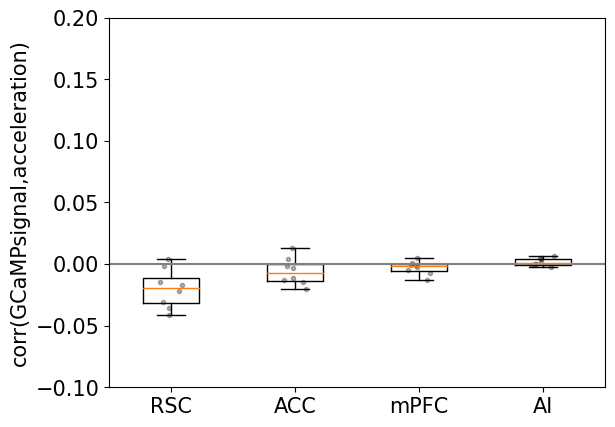

In [39]:
# plotting (Fig. 3)
var_names = ['linear velocity', 'angular velocity', 'acceleration']
pearson_all = [pearson_speed_allmice, 
               pearson_angle_allmice, 
               pearson_accel_allmice]
# print(regions_all)
for i_var in range(len(var_names)):
    plt.figure()
    pearson_curr = []
    for reg_curr in regions_all:
#         print(pearson_all[i_var].keys())
        pearson_curr.append(pearson_all[i_var][reg_curr])
    plt.figure()
    plt.boxplot(pearson_curr)
    shifts = (np.random.rand(len(pearson_curr[0])) - 0.5)*0.2 + 1
    
    ctr_plot = 0
    for ii in pearson_curr:
        plt.plot(ctr_plot + shifts, ii, 'k.', 
                 alpha = 0.3)
        ctr_plot += 1
    
    plt.xticks(np.arange(len(regions_all)) + 1, regions_all)
    plt.ylabel('corr(GCaMPsignal,'+var_names[i_var]+')')
    plt.axhline(0, color = '0.5')
    plt.ylim(-0.1,0.2)
    plt.savefig('pearson_GCaMP_'+var_names[i_var]+'resting.pdf')
    
    print(var_names[i_var])
    pval_uncorrected = []
    for ii_reg in range(len(regions_all)):
#       for jj_reg in range(ii_reg + 1, len(regions_all)):
        wilcox_curr = stats.wilcoxon(pearson_all[i_var][regions_all[ii_reg]])
        print(regions_all[ii_reg], 
              np.median(pearson_all[i_var][regions_all[ii_reg]]), 
#               np.std(pearson_all[i_var][regions_all[ii_reg]]),
              wilcox_curr)
        pval_uncorrected.append(wilcox_curr[1])
    print(pval_uncorrected)
    # FDR CORRECTION
    rej, pval_corrected = fdrcorrection(pval_uncorrected)
    ctr = 0
    for ii_reg in range(len(regions_all)):
            print('FDR corrected ', regions_all[ii_reg],
                  pval_corrected[ctr])
            ctr += 1
    np.save('pearson_GCaMP_'+var_names[i_var]+'resting.npy',pearson_all)

# BSDS state analysis

(8, 11800) [0 1 2 3 4 5 6]
RSC KruskalResult(statistic=50.3110902255639, pvalue=4.0720911377105645e-09)
RSC Ttest_indResult(statistic=-3.645284743327368, pvalue=0.0006011234878372969)
Cg KruskalResult(statistic=52.428571428571416, pvalue=1.5290801528395366e-09)
Cg Ttest_indResult(statistic=-4.922421760942249, pvalue=8.4310391509904e-06)
PrL KruskalResult(statistic=51.25187969924812, pvalue=2.636257279133351e-09)
PrL Ttest_indResult(statistic=-7.115681574198337, pvalue=2.673087761140113e-09)
AI KruskalResult(statistic=53.45394736842104, pvalue=9.505222750706028e-10)
AI Ttest_indResult(statistic=-1.312352114817038, pvalue=0.19495235322520457)


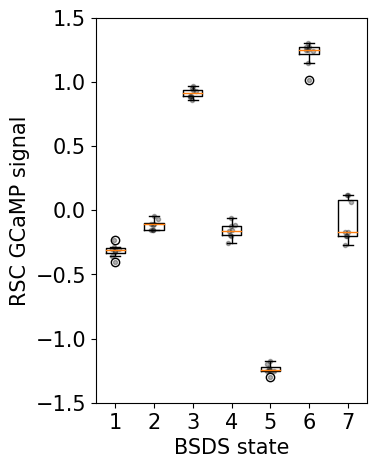

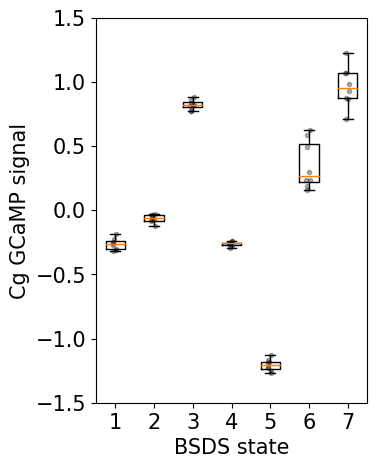

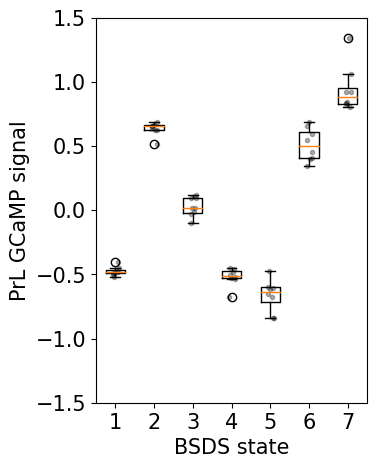

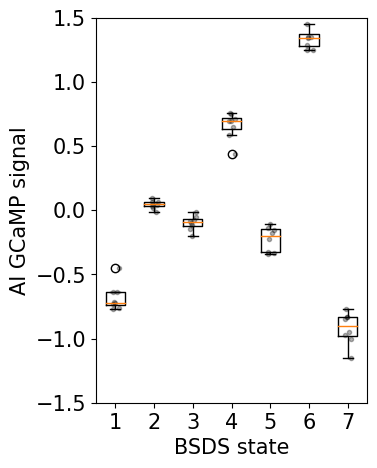

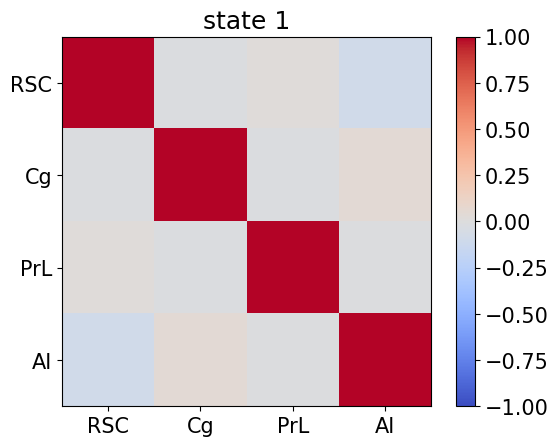

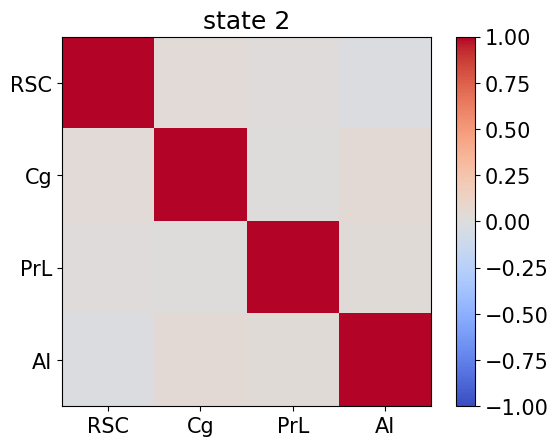

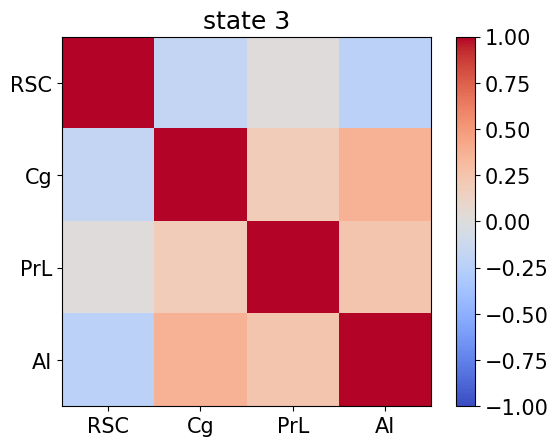

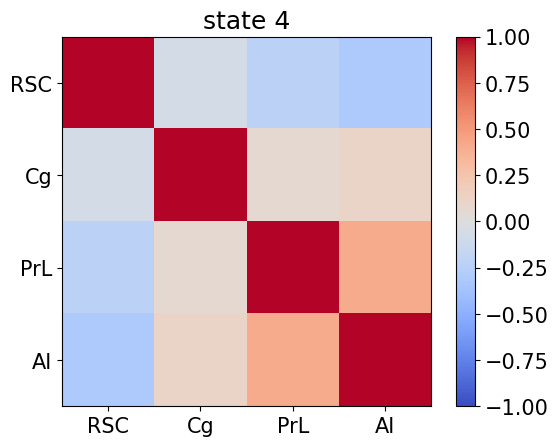

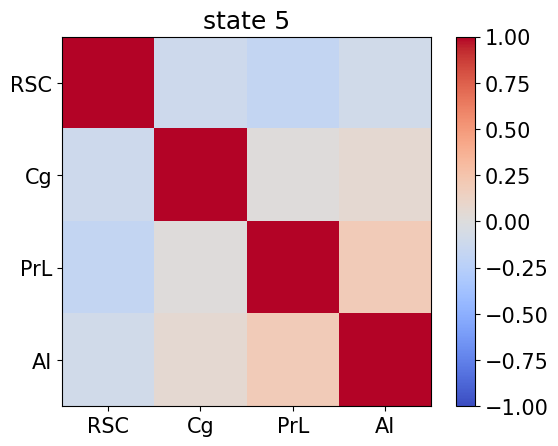

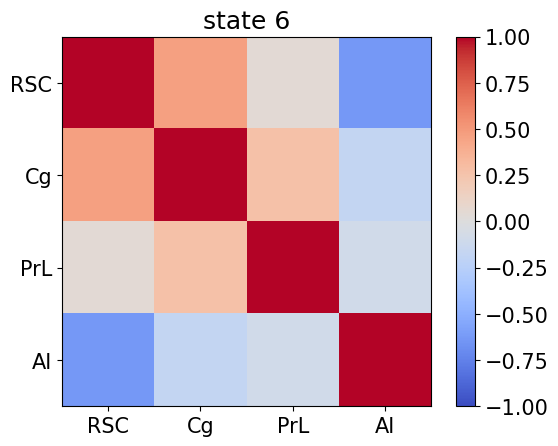

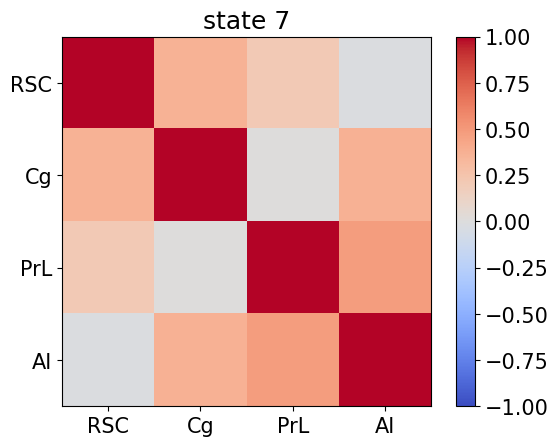

In [78]:
BSDS_states = np.load('BSDS_states_relabeled_allrats.npy') - 1
states_all = np.unique(BSDS_states)
print(BSDS_states.shape, states_all)

gcamp_means_all = np.zeros((len(states_all), 
                            len(BSDS_states), 
                            len(regions_all)))
gcamp_pearson_all = np.zeros((len(states_all), 
                            len(BSDS_states), 
                            len(regions_all),
                            len(regions_all)))

Ncut = 100 # cut unstable start and end time points

# hypothesis for testing
states_highspeed = np.array([3,6,7]) - 1
states_lowspeed = np.array([1,2,4,5]) - 1

for i_rat in range(len(BSDS_states)):
    BSDS_states_cut = BSDS_states[i_rat][Ncut:-Ncut]
    # GCaMP signal per region, include all stable time points
    GCaMP_cut = []
    for reg_curr in ['RSC', 'ACC', 'mPFC', 'AI']:
        GCaMP_cut.append(gcamp_allmice[i_rat][reg_curr][Ncut:-Ncut])
    GCaMP_cut = np.array(GCaMP_cut)
    
    for state_curr in states_all:
        idx_state = np.where(BSDS_states_cut == state_curr)[0]
        gcamp_state = GCaMP_cut[:,idx_state] # ?
        gcamp_means_state = np.mean(gcamp_state, axis = 1)
        gcamp_means_all[state_curr, i_rat, :] = gcamp_means_state
        gcamp_pearson_all[state_curr, i_rat, :, :] = np.corrcoef(gcamp_state)

for i_reg in range(len(regions_all)):
    plt.figure(figsize = (3.5,5))
    plt.boxplot(np.transpose(gcamp_means_all[:,:,i_reg]))
    shifts = (np.random.rand(len(gcamp_means_all[0,:,i_reg])) - 0.5)*0.2 + 1
    
    ctr_plot = 0
    for ii in gcamp_means_all[:,:,i_reg]:
        plt.plot(ctr_plot + shifts, ii, 'k.', 
                 alpha = 0.3)
        ctr_plot += 1
    plt.xlabel('BSDS state')
    plt.ylabel(regions_all[i_reg] + ' GCaMP signal')
    plt.ylim(-1.5, 1.5)
    plt.savefig('mean_rate_BSDS_'+regions_all[i_reg]+'_rest.pdf')
    print(regions_all[i_reg], stats.kruskal(*gcamp_means_all[:,:,i_reg]))
    print(regions_all[i_reg], stats.ttest_ind(np.concatenate(gcamp_means_all[:5,:,i_reg]), 
                                              np.concatenate(gcamp_means_all[5:,:,i_reg])))
for state_curr in states_all:
    plt.figure()
    plt.imshow(np.mean(gcamp_pearson_all[state_curr], axis = 0), 
              cmap = 'coolwarm', vmin = -1, vmax = 1)
    plt.xticks(np.arange(len(regions_all)), regions_all)
    plt.yticks(np.arange(len(regions_all)), regions_all)
    plt.colorbar()
    plt.title('state ' + str(state_curr + 1))
    plt.savefig('pearson_BSDS_state'+str(state_curr)+'_rest.pdf')

(7, 4) (7, 4)
PearsonRResult(statistic=0.7340736557570053, pvalue=8.747238327899915e-06)


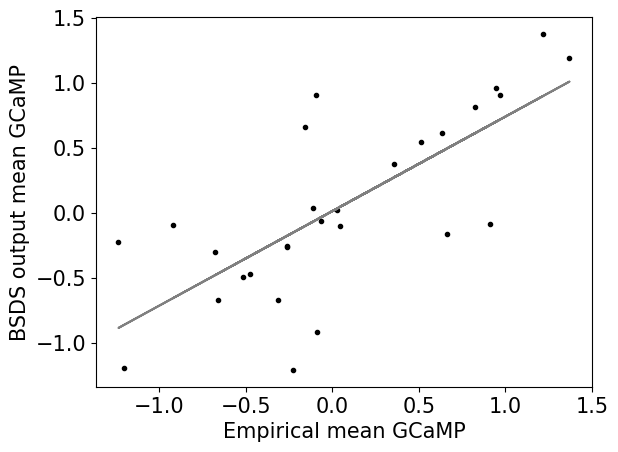

In [79]:
gcamp_means_empirical_overrats = np.mean(gcamp_means_all, axis = 1)
gcamp_means_BSDS_output = np.load('means_BSDS_output_order_occur_resting.npy')[:len(gcamp_means_empirical_overrats)]
print(gcamp_means_empirical_overrats.shape, gcamp_means_BSDS_output.shape)
plt.figure()
plt.plot(np.concatenate(gcamp_means_empirical_overrats), 
         np.concatenate(gcamp_means_BSDS_output), 'k.')
a,b = np.polyfit(np.concatenate(gcamp_means_empirical_overrats), 
         np.concatenate(gcamp_means_BSDS_output), 1)
plt.plot(np.concatenate(gcamp_means_empirical_overrats),
         np.concatenate(gcamp_means_empirical_overrats)*a + b,
         '0.5')
plt.xlabel('Empirical mean GCaMP')
plt.ylabel('BSDS output mean GCaMP')
print(stats.pearsonr(np.concatenate(gcamp_means_empirical_overrats), 
         np.concatenate(gcamp_means_BSDS_output)))

In [80]:
# printing for comparison with BSDS output
print(gcamp_pearson_all.shape, '\n')
for state_curr in states_all:
    print(state_curr, np.mean(gcamp_pearson_all[state_curr], axis = 0), '\n')
print(np.mean(gcamp_pearson_all, axis = 1).shape)
np.save('GCaMP_cov_perstate_by_hand_resting.npy', np.mean(gcamp_pearson_all, axis = 1))

(7, 8, 4, 4) 

0 [[ 1.         -0.02143792  0.01983198 -0.09311951]
 [-0.02143792  1.         -0.02155474  0.0456574 ]
 [ 0.01983198 -0.02155474  1.         -0.01376705]
 [-0.09311951  0.0456574  -0.01376705  1.        ]] 

1 [[ 1.00000000e+00  3.24029917e-02  1.17020413e-02 -2.29371822e-02]
 [ 3.24029917e-02  1.00000000e+00  6.12599880e-04  3.96425301e-02]
 [ 1.17020413e-02  6.12599880e-04  1.00000000e+00  2.41871033e-02]
 [-2.29371822e-02  3.96425301e-02  2.41871033e-02  1.00000000e+00]] 

2 [[ 1.         -0.1754653   0.00822952 -0.23019518]
 [-0.1754653   1.          0.18409364  0.36881824]
 [ 0.00822952  0.18409364  1.          0.23899284]
 [-0.23019518  0.36881824  0.23899284  1.        ]] 

3 [[ 1.         -0.06506635 -0.22412626 -0.30487231]
 [-0.06506635  1.          0.06709765  0.11536774]
 [-0.22412626  0.06709765  1.          0.40332791]
 [-0.30487231  0.11536774  0.40332791  1.        ]] 

4 [[ 1.         -0.1154948  -0.17756319 -0.09234798]
 [-0.1154948   1.          0.014

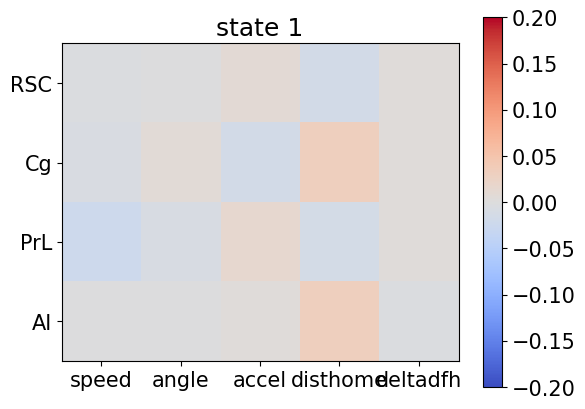

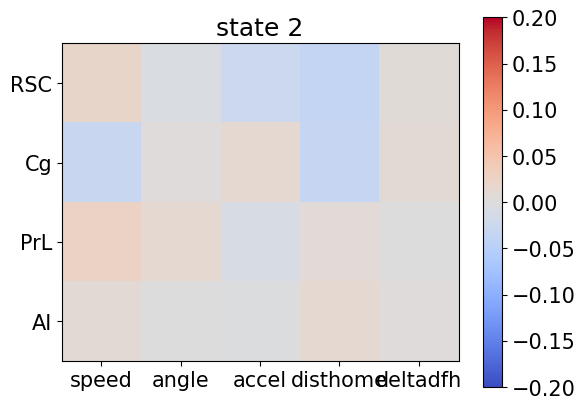

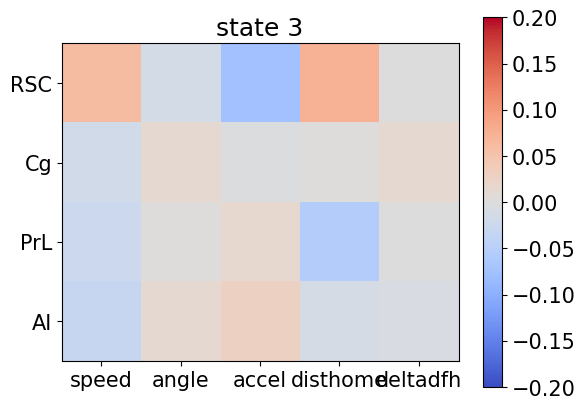

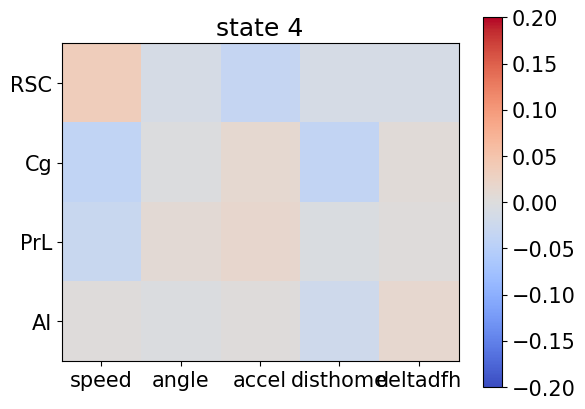

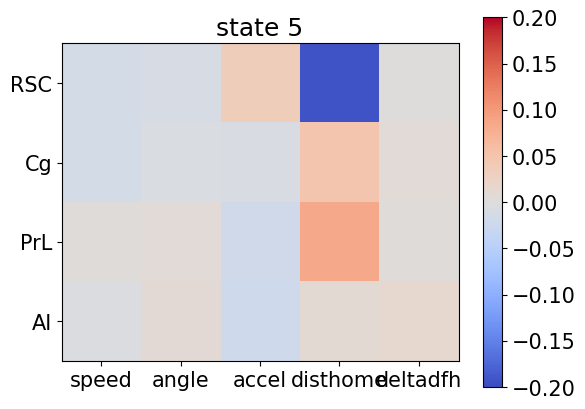

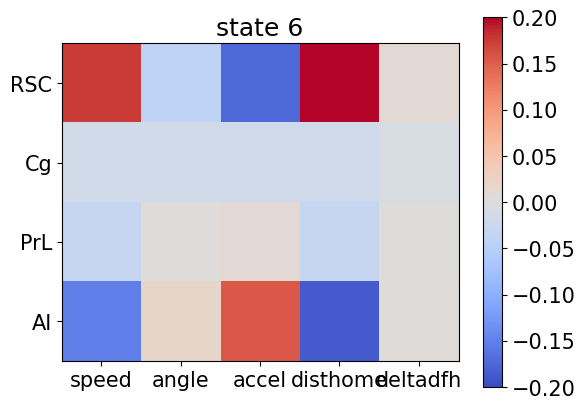

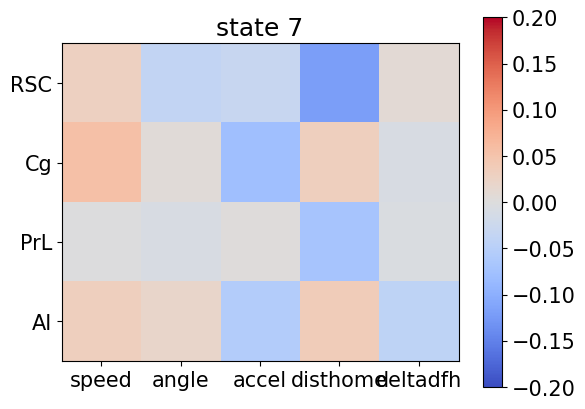

In [81]:
# navigation stats vs mean GCaMP signal, across states

delta_dist_from_home_allmice= []
for dist_curr in dist_from_home_allmice:
    delta_dist_from_home_allmice.append(np.diff(dist_curr))
    
motion_names_all = ['speed', 'angle', 'accel', 'disthome','deltadfh'] # regions_all
motion_all = [delta_pos_allmice, 
              accel_pos_allmice,
              angle_change_allmice, 
              dist_from_home_allmice,
              delta_dist_from_home_allmice]
dist_from_home_change_allrats = []
cov_perstate_allrats = []
entropy_perstate_allrats = []

for i_rat in range(len(BSDS_states)):
    # make variable dictionary
    dist_from_home_change = []
    
    # states
    states_curr = BSDS_states[i_rat]#[Ncut:-Ncut]

    # motion, per statistics
    ctr_stat = 0
    nav_stats_cut = {}
    entropy_perstate = []
    for motion_name_curr in motion_names_all:

        delta_pos_curr = motion_all[ctr_stat][i_rat + 1]
        idx_curr = idx_keep[i_rat + 1]
        delta_pos_cut = delta_pos_curr[np.logical_and(idx_curr[:len(delta_pos_curr)] > ncut,
                        idx_curr[:len(delta_pos_curr)] < 12000 - ncut)]        
        nav_stats_cut[motion_name_curr] = delta_pos_cut
        ctr_stat += 1
    len_all = len(delta_pos_cut)
    
    # GCaMP, per region
    idx_region_choose = np.arange(len(regions_all)).astype(int)
    gcamp_vars = gcamp_allmice_cut[i_rat][idx_regions_choose,:len_all]

    # states, cut
    # remove first and last 100 time bins where signal is unstable
    # remove frames where mouse head is out of frame
    len_sig = 12000
    idx_curr_for_bsds = idx_curr[np.logical_and(idx_curr > ncut, idx_curr < len_sig - ncut)] - ncut
    states_clean = states_curr[idx_curr_for_bsds]  

    states_cut = states_clean[:len_all]
    
    states_unique = np.unique(states_cut)
    
    entropy_perstate = np.zeros((len(states_unique), len(regions_all)))
    # correlations
    cov_perstate = np.zeros((len(states_unique), len(regions_all), 
                             len(motion_names_all)))
    for i_state in states_unique:
        GCaMP_state = gcamp_vars[:, states_cut == i_state]
        ctr_stat = 0
        for motion_name_curr in motion_names_all:
            motion_state = nav_stats_cut[motion_name_curr][states_cut == i_state]
            
            
            if motion_name_curr == 'disthome': #record mean change in dist from home
                dist_from_home_change.append(np.nanmean(np.diff(motion_state)))
                
            
            for i_reg in range(len(regions_all)):
                # entropy per state
                f, Pxx = signal.welch(GCaMP_state[i_reg], 
                              fs = fsamp)
                entropy_perstate[i_state, i_reg] = spectral_entropy(Pxx)
        
                # correlation between GCaMP and nav stat
                cov = stats.pearsonr(GCaMP_state[i_reg], motion_state)
                
#                 if cov[1] < 0.05:
#                     print(i_state, regions_all[i_reg], motion_name_curr, cov)
                cov_perstate[i_state, i_reg, ctr_stat] = cov[0]
            ctr_stat += 1
        
    cov_perstate_allrats.append(cov_perstate)
    dist_from_home_change_allrats.append(dist_from_home_change)
    entropy_perstate_allrats.append(entropy_perstate)
# plotting
print('\n')
cov_perstate_allrats = np.array(cov_perstate_allrats)
for i_state in states_unique:
    plt.figure()
    cov_perstate_mean = np.mean(cov_perstate_allrats[:,i_state], axis = 0)
    plt.imshow(cov_perstate_mean, cmap = 'coolwarm', vmin = -0.2, vmax = 0.2)
    plt.yticks(np.arange(len(regions_all)), regions_all)
    plt.xticks(np.arange(len(motion_names_all)), motion_names_all)
    plt.colorbar()
    plt.title('state '+str(i_state + 1))
    plt.savefig('cov_GCaMP_navstats_BSDS_state'+str(i_state)+'resting.pdf')

RSC MannwhitneyuResult(statistic=230.0, pvalue=0.10453530880392742)
Cg MannwhitneyuResult(statistic=318.0, pvalue=0.9782959411232164)
PrL MannwhitneyuResult(statistic=384.0, pvalue=0.2494470248889521)
AI MannwhitneyuResult(statistic=430.0, pvalue=0.047034297198175784)


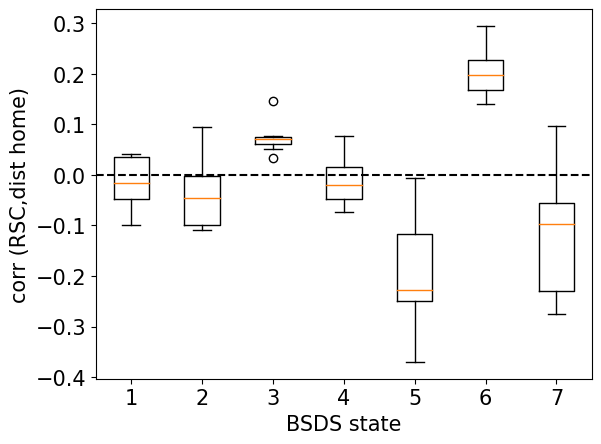

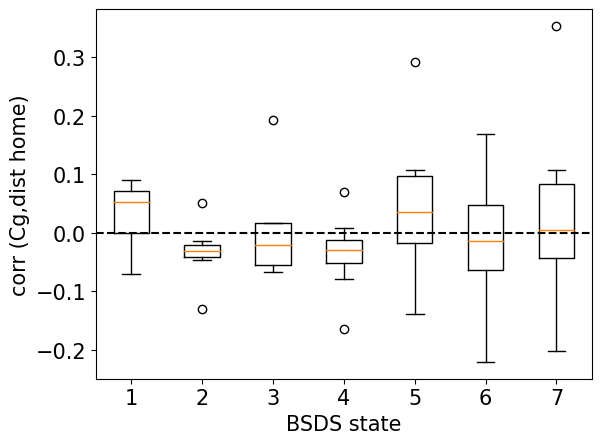

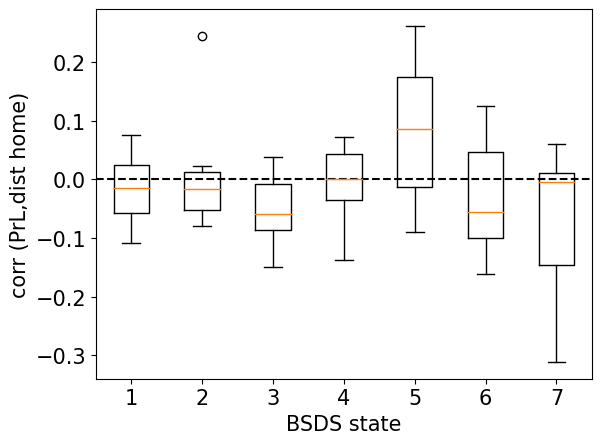

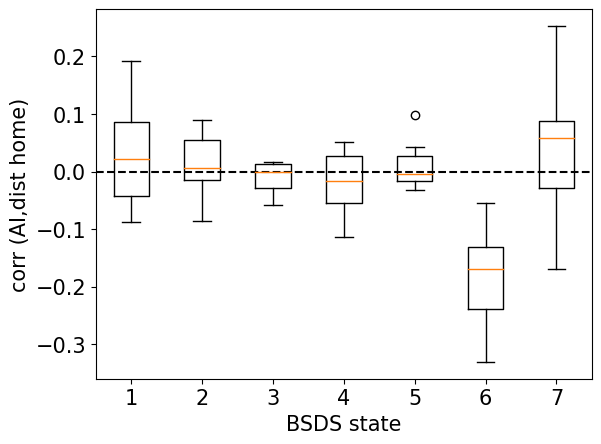

In [82]:
# boxplot per region, dist from home only

for i_reg in range(len(cov_perstate_allrats[0,0])):
    plt.figure()
    cov_curr = cov_perstate_allrats[:,:,i_reg,-2]
    plt.boxplot(cov_curr)
    plt.xlabel('BSDS state')
    plt.ylabel('corr ('+regions_all[i_reg] + ',dist home)')
    plt.axhline(0, color = 'k', linestyle = '--')
    
    print(regions_all[i_reg], stats.mannwhitneyu(np.concatenate(cov_curr[:,:5]), 
                             np.concatenate(cov_curr[:,5:])))

(8, 7)
1 2 WilcoxonResult(statistic=15.0, pvalue=0.7421875)
1 3 WilcoxonResult(statistic=18.0, pvalue=1.0)
1 4 WilcoxonResult(statistic=16.0, pvalue=0.84375)
1 5 WilcoxonResult(statistic=7.0, pvalue=0.1484375)
1 6 WilcoxonResult(statistic=14.0, pvalue=0.640625)
1 7 WilcoxonResult(statistic=8.0, pvalue=0.1953125)
2 3 WilcoxonResult(statistic=16.0, pvalue=0.84375)
2 4 WilcoxonResult(statistic=18.0, pvalue=1.0)
2 5 WilcoxonResult(statistic=14.0, pvalue=0.640625)
2 6 WilcoxonResult(statistic=14.0, pvalue=0.640625)
2 7 WilcoxonResult(statistic=13.0, pvalue=0.546875)
3 4 WilcoxonResult(statistic=17.0, pvalue=0.9453125)
3 5 WilcoxonResult(statistic=11.0, pvalue=0.3828125)
3 6 WilcoxonResult(statistic=16.0, pvalue=0.84375)
3 7 WilcoxonResult(statistic=9.0, pvalue=0.25)
4 5 WilcoxonResult(statistic=9.0, pvalue=0.25)
4 6 WilcoxonResult(statistic=17.0, pvalue=0.9453125)
4 7 WilcoxonResult(statistic=10.0, pvalue=0.3125)
5 6 WilcoxonResult(statistic=14.0, pvalue=0.640625)
5 7 WilcoxonResult(statist

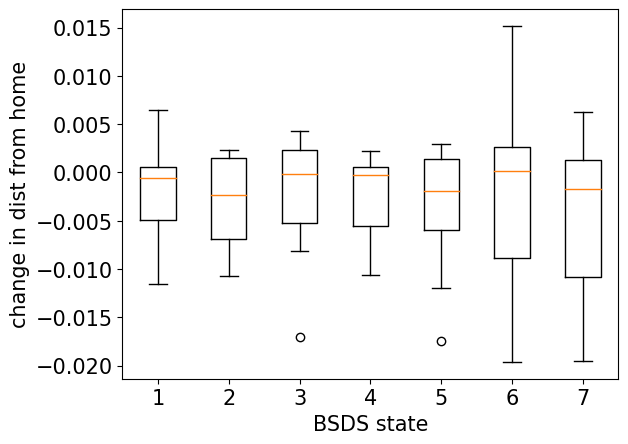

In [83]:
# change in distance from home throughout states
dist_from_home_change_allrats = np.array(dist_from_home_change_allrats)
print(dist_from_home_change_allrats.shape)

plt.figure()
plt.boxplot(dist_from_home_change_allrats)
plt.xlabel('BSDS state')
plt.ylabel('change in dist from home')

for i_state in range(len(dist_from_home_change_allrats[0])):
    for j_state in range(i_state + 1, len(dist_from_home_change_allrats[0])):
        print(i_state + 1, j_state + 1, 
              stats.wilcoxon(dist_from_home_change_allrats[:,i_state], 
                             dist_from_home_change_allrats[:,j_state]))

(8, 7, 4)
RSC F_onewayResult(statistic=29.210478964026382, pvalue=1.3816172997577371e-14)
RSC Ttest_indResult(statistic=-2.5557900426458033, pvalue=0.013442453896212746)
RSC 1 5 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 1 6 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 1 7 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 2 5 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 2 6 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 2 7 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 3 5 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 3 6 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 3 7 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 4 5 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 4 6 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 4 7 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 6 7 WilcoxonResult(statistic=1.0, pvalue=0.015625)
(8, 7, 4)
Cg F_onewayResult(statistic=26.262081828472997, pvalue=9.878395916854963e-14)
Cg Ttest_indRes

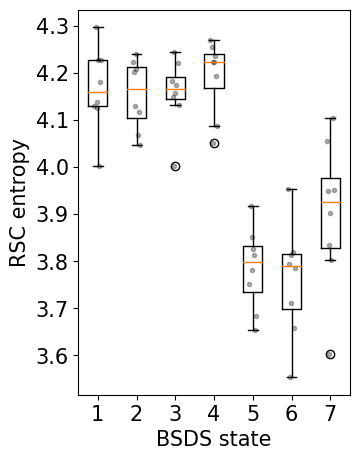

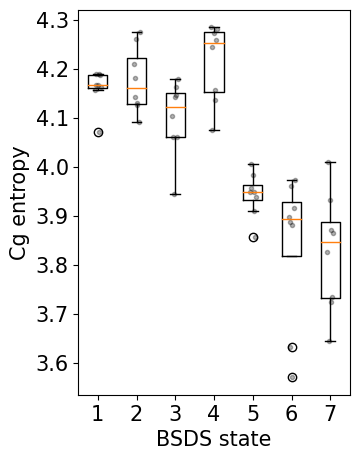

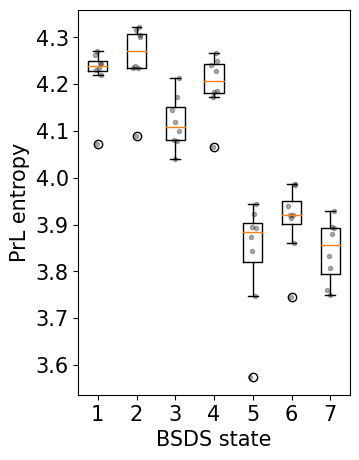

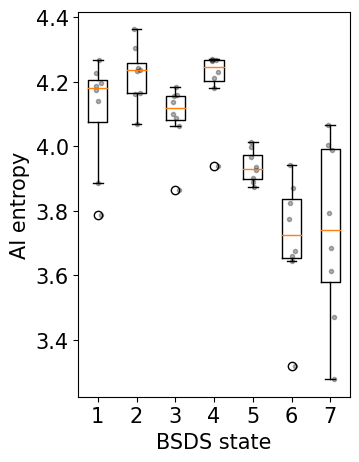

In [84]:
# entropy per BSDS state
entropy_perstate_allrats = np.array(entropy_perstate_allrats)

for i_reg in range(len(regions_all)):
    plt.figure(figsize=(3.5,5))
    plt.boxplot(entropy_perstate_allrats[:,:,i_reg])
    
    shifts = (np.random.rand(len(entropy_perstate_allrats[:,0,i_reg])) - 0.5)*0.2 + 1
    
    ctr_plot = 0
    for ii in np.transpose(entropy_perstate_allrats[:,:,i_reg]):
        plt.plot(ctr_plot + shifts, ii, 'k.', 
                 alpha = 0.3)
        ctr_plot += 1
    
    plt.xlabel('BSDS state')
    plt.ylabel(regions_all[i_reg] + ' entropy')
    plt.savefig('entropy_per_BSDS_state_'+regions_all[i_reg]+'_resting.pdf')
    print(entropy_perstate_allrats.shape)
    print(regions_all[i_reg], stats.f_oneway(*np.transpose(entropy_perstate_allrats[:,:,i_reg])))
    print(regions_all[i_reg], stats.ttest_ind(np.concatenate(entropy_perstate_allrats[:,states_highspeed,i_reg]), 
                                              np.concatenate(entropy_perstate_allrats[:,states_lowspeed,i_reg])))

    for i_state in range(len(dist_from_home_change_allrats[0])):
        for j_state in range(i_state + 1, len(dist_from_home_change_allrats[0])):
            wilcox_curr = stats.wilcoxon(entropy_perstate_allrats[:,i_state, i_reg], 
                                 entropy_perstate_allrats[:,j_state, i_reg])
            if wilcox_curr[1] < 0.05:
                print(regions_all[i_reg], i_state + 1, j_state + 1, 
                      wilcox_curr)

In [85]:
# navigation stats correlation with GCaMP signal, in each states

speed_perstate = np.load("BSDS_state_speedresting_allpts.npy", allow_pickle=True)
accel_perstate = np.load("BSDS_state_accelerationresting_allpts.npy", allow_pickle=True)
angle_perstate = np.load("BSDS_state_angle changeresting_allpts.npy", allow_pickle=True)
disthome_perstate = np.load("BSDS_state_distance from homeresting_allpts.npy", allow_pickle=True)

nav_stats_all = [speed_perstate, accel_perstate, angle_perstate, disthome_perstate]
nav_stats_names = ['speed', 'acceleration', 'angle change', 'distance from home']

# dict_list = []
# for nav_stats_curr, nav_name_curr in zip(nav_stats_all, nav_stats_names):
    
#     for i_reg in range(len(regions_all)):
#         Nrats = gcamp_means_all.shape[1]
#         Nstates = gcamp_means_all.shape[0]
#         dict_curr = {}
#         dict_curr['GCaMP'] = np.zeros(Nrats*Nstates)
#         dict_curr['nav'] = np.zeros(Nrats*Nstates)
#         dict_curr['state'] = np.zeros(Nrats*Nstates)
#         dict_curr['animal'] = np.zeros(Nrats*Nstates)
        
#         for i_rat in range(gcamp_means_all.shape[1]):
#             plt.figure()
#             gcamp_curr = gcamp_means_all[:,i_rat,i_reg]#np.mean(gcamp_means_all[:,:,i_reg], axis = 1)
# #             gcamp_std = np.std(gcamp_means_all[:,:,i_reg], axis = 1)/np.sqrt(len(gcamp_curr))
#             nav_curr = nav_stats_curr[i_rat]#np.mean(nav_stats_curr, axis = 0)
# #             nav_std = np.std(nav_stats_curr, axis = 0)/np.sqrt(len(nav_curr))
# #             gcamp_allrats = np.concatenate(gcamp_means_all[:,:,i_reg])
# #             nav_allrats = np.concatenate(nav_stats_curr)

#             print(len(nav_curr))

#             dict_curr['GCaMP'][i_rat*Nstates:(i_rat + 1)*Nstates] = gcamp_curr
#             dict_curr['nav'][i_rat*Nstates:(i_rat + 1)*Nstates] = nav_curr
#             dict_curr['state'][i_rat*Nstates:(i_rat + 1)*Nstates] = np.arange(len(nav_curr))
#             dict_curr['animal'][i_rat*Nstates:(i_rat + 1)*Nstates] = np.ones(len(nav_curr))*i_rat
            
#             plt.plot(gcamp_curr, nav_curr, 
# #                          xerr = gcamp_std, yerr = nav_std,
#                          color = colors_all[i_reg],
#                          linestyle = '', marker = '.', alpha = 0.5)
#     #         plt.plot(gcamp_allrats, nav_allrats, 
#     #                  color = colors_all[i_reg],
#     #                  marker = '.', linestyle = '')
#             a,b = np.polyfit(gcamp_curr, nav_curr, 1)
#             plt.plot(gcamp_curr, a*gcamp_curr + b, color = colors_all[i_reg])
#             print(nav_name_curr, regions_all[i_reg],
#                   stats.pearsonr(gcamp_curr, nav_curr))
#             plt.xlabel('GCaMP signal')
#             plt.ylabel(nav_name_curr)
#         dict_list.append(dict_curr)
#     print('\n')
# print(len(dict_list))    

In [86]:
# mean firing rate per state statistic

for i_reg in range(len(regions_all)):
    for i_state in range(len(states_all)):
        for j_state in range(i_state + 1, len(states_all)):
            print(regions_all[i_reg], i_state, j_state, 
                  stats.wilcoxon(gcamp_means_all[i_state,:,i_reg], 
                                 gcamp_means_all[j_state,:,i_reg]))
    print('\n')

RSC 0 1 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 0 2 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 0 3 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 0 4 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 0 5 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 0 6 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 1 2 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 1 3 WilcoxonResult(statistic=6.0, pvalue=0.109375)
RSC 1 4 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 1 5 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 1 6 WilcoxonResult(statistic=15.0, pvalue=0.7421875)
RSC 2 3 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 2 4 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 2 5 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 2 6 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 3 4 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 3 5 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC 3 6 WilcoxonResult(statistic=12.0, pvalue=0.

In [87]:
# Pearson per state statistic
pairs_of_interest = [[0,2], # Cg-RSC
                     [0,3], # Cg-PrL
                     [2,3], # RSC-PRL
                     [1,0], # AI-Cg
                     [1,2], # AI-RSC
                     [1,3] # AI-PrL
                    ]

for pair_curr in pairs_of_interest:
    for i_state in range(len(states_all)):
        for j_state in range(i_state + 1, len(states_all)):
            print(regions_all[pair_curr[0]], regions_all[pair_curr[1]],
                  i_state, j_state, 
                  stats.wilcoxon(gcamp_pearson_all[i_state,:,pair_curr[0],pair_curr[1]], 
                                 gcamp_pearson_all[j_state,:,pair_curr[0],pair_curr[1]]))    
    print('\n')

RSC PrL 0 1 WilcoxonResult(statistic=13.0, pvalue=0.546875)
RSC PrL 0 2 WilcoxonResult(statistic=17.0, pvalue=0.9453125)
RSC PrL 0 3 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC PrL 0 4 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC PrL 0 5 WilcoxonResult(statistic=17.0, pvalue=0.9453125)
RSC PrL 0 6 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC PrL 1 2 WilcoxonResult(statistic=18.0, pvalue=1.0)
RSC PrL 1 3 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC PrL 1 4 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC PrL 1 5 WilcoxonResult(statistic=15.0, pvalue=0.7421875)
RSC PrL 1 6 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC PrL 2 3 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC PrL 2 4 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC PrL 2 5 WilcoxonResult(statistic=14.0, pvalue=0.640625)
RSC PrL 2 6 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC PrL 3 4 WilcoxonResult(statistic=6.0, pvalue=0.109375)
RSC PrL 3 5 WilcoxonResult(statistic=2.0, p

[0 1 3 4] [2 5 6]
(7, 8)
RSC Cg F_onewayResult(statistic=41.30511223135637, pvalue=1.629746208013441e-17)
RSC Cg Ttest_indResult(statistic=-4.409877976635204, pvalue=4.968206718283245e-05)
(7, 8)
RSC PrL F_onewayResult(statistic=13.850003445326493, pvalue=3.925518581211043e-09)
RSC PrL Ttest_indResult(statistic=-4.526237523213163, pvalue=3.3419450779944384e-05)
(7, 8)
RSC AI F_onewayResult(statistic=71.67291940955533, pvalue=1.5123792922797714e-22)
RSC AI Ttest_indResult(statistic=3.0314985215860926, pvalue=0.0037325517151014977)
(7, 8)
Cg PrL F_onewayResult(statistic=10.608463358408427, pvalue=1.5899730761691718e-07)
Cg PrL Ttest_indResult(statistic=-4.185216285390528, pvalue=0.00010558571363766929)
(7, 8)
Cg AI F_onewayResult(statistic=46.52186132344007, pvalue=1.4484252582911199e-18)
Cg AI Ttest_indResult(statistic=-2.4148120851655475, pvalue=0.019160092207943256)
(7, 8)
PrL AI F_onewayResult(statistic=30.44738268212681, pvalue=6.328993807833163e-15)
PrL AI Ttest_indResult(statistic

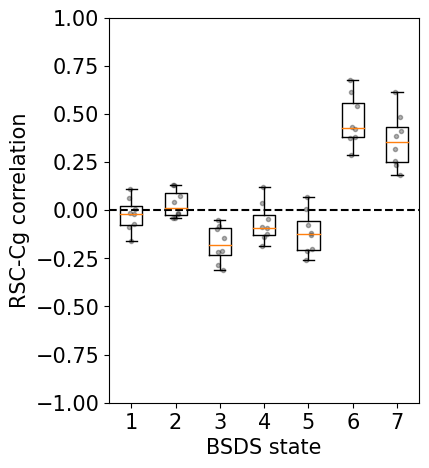

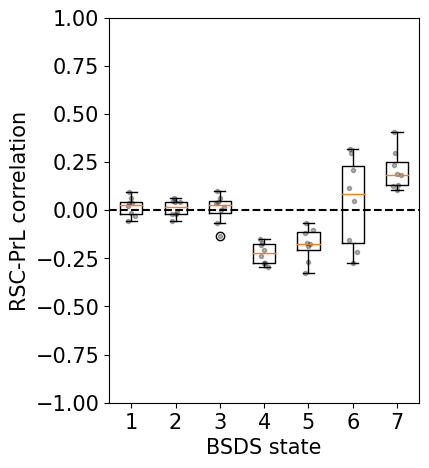

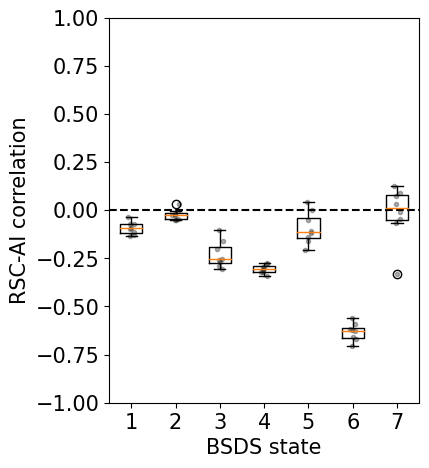

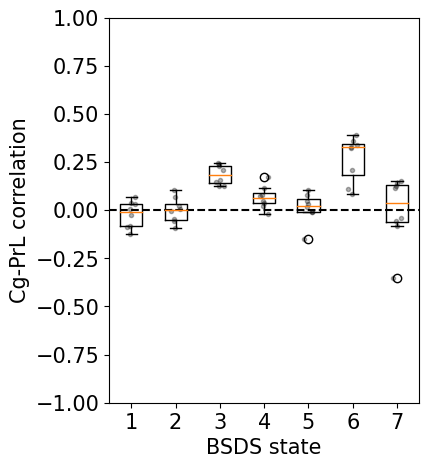

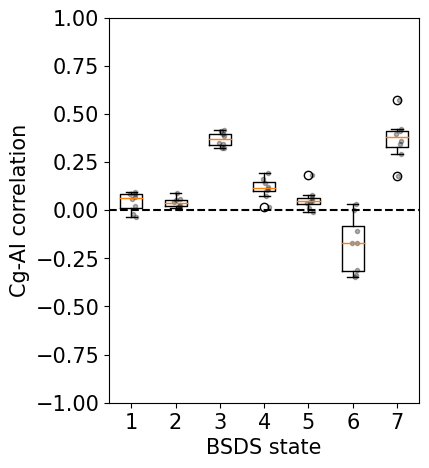

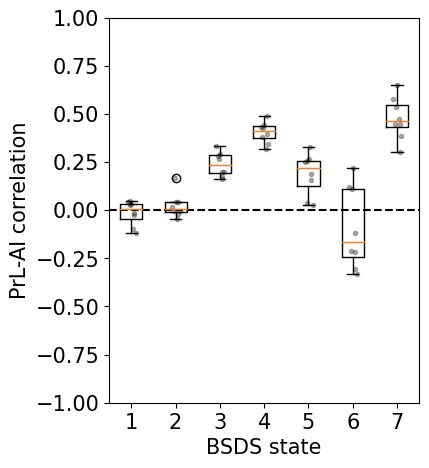

In [88]:
print(states_lowspeed, states_highspeed)
for i_reg in range(len(regions_all)):
    for j_reg in range(i_reg + 1, len(regions_all)):
        plt.figure(figsize=(4,5))
        plt.boxplot(np.transpose(gcamp_pearson_all[:,:, i_reg, j_reg]))
        
        shifts = (np.random.rand(len(gcamp_pearson_all[0,:, i_reg, j_reg])) - 0.5)*0.2 + 1
        ctr_plot = 0
        for ii in gcamp_pearson_all[:,:, i_reg, j_reg]:
            plt.plot(ctr_plot + shifts, ii, 'k.', 
                     alpha = 0.3)
            ctr_plot += 1
        
        plt.xlabel('BSDS state')
        plt.ylabel(regions_all[i_reg] + '-' + regions_all[j_reg] +' correlation')
        plt.ylim(-1, 1)
        plt.axhline(0, linestyle = '--', color = 'k')
        plt.savefig('BSDS_Pearson_perstate_'+regions_all[i_reg] + '-' + regions_all[j_reg] +'.pdf')
        
        print(gcamp_pearson_all[:,:,i_reg,j_reg].shape)
        print(regions_all[i_reg], regions_all[j_reg], stats.f_oneway(*gcamp_pearson_all[:,:,i_reg,j_reg]))
        print(regions_all[i_reg], regions_all[j_reg], 
              stats.ttest_ind(np.concatenate(gcamp_pearson_all[states_lowspeed,:,i_reg,j_reg]), 
                                              np.concatenate(gcamp_pearson_all[states_highspeed,:,i_reg,j_reg])))

#         for i_state in range(len(states_all)):
#             for j_state in range(i_state + 1, len(states_all)):
#                 print(regions_all[i_reg], regions_all[j_reg],
#                       i_state, j_state, 
#                       stats.wilcoxon(gcamp_pearson_all[i_state,:,i_reg,j_reg], 
#                                      gcamp_pearson_all[j_state,:,i_reg,j_reg]))    
        
#         print('\n')

In [89]:
# # navigation stats vs mean GCaMP FC, across states

# dict_cov_perstate_list = []
# for nav_stats_curr, nav_name_curr in zip(nav_stats_all, nav_stats_names):
    
#     for i_reg in range(len(regions_all)):
#         for j_reg in range(i_reg + 1, len(regions_all)):
#             plt.figure()
#             gcamp_curr = np.mean(gcamp_pearson_all[:,:,i_reg, j_reg], axis = 1)
#             gcamp_std = np.std(gcamp_pearson_all[:,:,i_reg, j_reg], axis = 1)/np.sqrt(len(gcamp_curr))
#             print(nav_stats_names, len(nav_stats_curr))
#             nav_curr = np.mean(nav_stats_curr, axis = 0)
#             nav_std = np.std(nav_stats_curr, axis = 0)/np.sqrt(len(nav_curr))
            
#             # write to dictionary for mixed effect analysis
#             dict_cov_perstate = {}
#             dict_cov_perstate['GCaMP'] = np.concatenate(gcamp_pearson_all[:,:,i_reg, j_reg])
#             dict_cov_perstate['nav'] = np.concatenate(nav_stats_curr)
#             dict_cov_perstate['state'] = np.repeat(np.arange(gcamp_pearson_all.shape[0]), gcamp_pearson_all.shape[1])
#             dict_cov_perstate['animal'] = np.tile(np.arange(gcamp_pearson_all.shape[1]), gcamp_pearson_all.shape[0])
#             print(dict_cov_perstate['state'], dict_cov_perstate['animal'])
            
            
#             gcamp_allrats = np.concatenate(gcamp_means_all[:,:,i_reg])
#             nav_allrats = np.concatenate(nav_stats_curr)
#             plt.errorbar(gcamp_curr, nav_curr, 
#                          xerr = gcamp_std, yerr = nav_std,
#                          ecolor = 'k',
#                          linestyle = '', alpha = 0.5)
#     #         plt.plot(gcamp_allrats, nav_allrats, 
#     #                  color = colors_all[i_reg],
#     #                  marker = '.', linestyle = '')
#             a,b = np.polyfit(gcamp_curr, nav_curr, 1)
#             plt.plot(gcamp_curr, a*gcamp_curr + b, color = 'k')
#             plt.title(regions_all[i_reg] +'-'+ regions_all[j_reg])
#             print(nav_name_curr, regions_all[i_reg], regions_all[j_reg],
#                   stats.pearsonr(gcamp_curr, nav_curr))
#             plt.xlabel('GCaMP signal')
#             plt.ylabel(nav_name_curr)
            
#             dict_cov_perstate_list.append(dict_cov_perstate)
#     print('\n')

In [90]:
# mixed effect modelling, per BSDS state, GCaMP signals

# !pip install -q statsmodels
# import statsmodels.api as sm
# import statsmodels.formula.api as smf


# ctr = 0
# cmap = plt.get_cmap('tab10')

# for nav_stats_curr, nav_name_curr in zip(nav_stats_all, nav_stats_names):
#     slope_all = []
#     slope_var = []
#     for i_reg in range(len(regions_all)):

#         # make dataframe
#         print(ctr, len(dict_list))
#         data = pd.DataFrame(data=dict_list[ctr])
#         # fit mixed effect model
#         md = smf.mixedlm("nav ~ GCaMP + C(animal)", data, groups=data["animal"], 
#                          vc_formula = {"animal" : "0 + C(animal)"})
#         mdf = md.fit()

#         print(nav_name_curr, regions_all[i_reg], mdf.summary())
#         ctr += 1

#         plt.figure()
#         for i_state in np.unique(data['animal']):
#             plt.plot(data['GCaMP'][data['animal'] == i_state], 
#                      data['nav'][data['animal'] == i_state], '.',
#                      color = cmap(int(i_state)))
#             a,b = np.polyfit(data['GCaMP'][data['animal'] == i_state],
#                        data['nav'][data['animal'] == i_state],1)
#             plt.plot(data['GCaMP'][data['animal'] == i_state], 
#                      data['GCaMP'][data['animal'] == i_state]*a + b, 
#                      color = cmap(int(i_state)))
#         plt.xlabel('mean ' + regions_all[i_reg] + ' per state')
#         plt.ylabel('mean ' + nav_name_curr + ' per state')
#         plt.savefig('mixedeffects_'+ regions_all[i_reg] +'_'+ nav_name_curr +'perstate_resting.pdf')

#         #storing inferred parameters
#         params_curr = mdf.params

#         slope_all.append(params_curr['GCaMP'])
# #         slope_var.append(params_curr['animal Var'])
#     print(nav_name_curr, regions_all, slope_all)
#     print('\n')
    
    

In [91]:
# mixed effect modelling, per BSDS state, GCaMP signals

!pip install -q statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf


ctr = 0
cmap = plt.get_cmap('tab10')

for nav_stats_curr, nav_name_curr in zip(nav_stats_all, nav_stats_names):
    slope_all = []
    slope_var = []
    for i_reg in range(len(regions_all)):
        for j_reg in range(i_reg + 1, len(regions_all)):
            # make dataframe
            data = pd.DataFrame(data=dict_cov_perstate_list[ctr])
            # fit mixed effect model
            md = smf.mixedlm("nav ~ GCaMP + C(animal)", data, groups=data["animal"], 
                             vc_formula = {"animal" : "0 + C(animal)"})
            mdf = md.fit()

            print(nav_name_curr, regions_all[i_reg], regions_all[j_reg], mdf.summary())
            ctr += 1

            plt.figure()
            for i_state in np.unique(data['animal']):
                plt.plot(data['GCaMP'][data['animal'] == i_state], 
                         data['nav'][data['animal'] == i_state], '.',
                         color = cmap(int(i_state)))
                a,b = np.polyfit(data['GCaMP'][data['animal'] == i_state],
                           data['nav'][data['animal'] == i_state],1)
                plt.plot(data['GCaMP'][data['animal'] == i_state], 
                         data['GCaMP'][data['animal'] == i_state]*a + b, 
                         color = cmap(int(i_state)))
            plt.xlabel(regions_all[i_reg] +'-'+ regions_all[j_reg] + ' FC per state')
            plt.ylabel('mean ' + nav_name_curr + ' per state')
            plt.savefig('mixedeffects_FC_'+ regions_all[i_reg] + regions_all[j_reg] +'_'+ nav_name_curr +'perstate_resting.pdf')
            #storing inferred parameters
            params_curr = mdf.params

            slope_all.append(params_curr['GCaMP'])
#         slope_var.append(params_curr['animal Var'])
    print(nav_name_curr, pair_names_all, slope_all)
    print('\n')

NameError: name 'dict_cov_perstate_list' is not defined

In [ ]:
# correlation between GCaMP signals and navigation stats, per state

ctr = 0

for nav_stats_curr, nav_name_curr in zip(nav_stats_all, nav_stats_names):
    for i_reg in range(len(regions_all)):
        for j_reg in range(i_reg + 1, len(regions_all)):
            # make dataframe
            data = pd.DataFrame(data=dict_cov_perstate_list[ctr])
            
            ctr += 1

In [ ]:
# slope across states, visualization
slopes_all = np.load('slopes.npz')
keys_all = slopes_all.files
for k in keys_all:
    print(k, np.mean(slopes_all[k])/0.7219497878593231)
print(stats.wilcoxon(slopes_all['RSC_mean'], 
                     slopes_all['AI_mean']))

# Multivariate linear regression

coef=  [[ 0.02027262 -0.00069829  0.0026855   0.00307073]
 [-0.01025532  0.00191442  0.00302745 -0.00510746]
 [-0.01209871 -0.01800516  0.00920737 -0.0114399 ]]
intercept=  [-5.75266914e-05  6.51478991e-05  4.92120692e-05]
coef=  [[-1.47904403e-02  3.75591964e-02 -6.21252950e-03  1.17648712e-02]
 [ 5.48197667e-03 -8.02942029e-03  1.05665469e-05 -7.12522122e-04]
 [-2.41030802e-02 -3.53721743e-03  1.62624688e-03 -2.82770957e-03]]
intercept=  [-1.46146604e-04 -1.65331420e-05  3.42706250e-04]
coef=  [[ 0.03288853  0.02542009 -0.01042897  0.01827529]
 [-0.01571407 -0.01291401  0.00568655  0.00299942]
 [-0.02376135 -0.01262572 -0.001808   -0.04083676]]
intercept=  [-0.00013138  0.00015645  0.00015095]
coef=  [[ 0.01553956  0.00214147 -0.00531512 -0.02576488]
 [-0.00525801  0.01088155  0.00350793  0.0007868 ]
 [-0.07093785  0.01788708 -0.00809997  0.01527948]]
intercept=  [-7.72687429e-04 -7.10273416e-05  2.63589074e-03]
coef=  [[ 9.39035250e-03  5.55360317e-03  1.38492618e-02 -8.52886432e-03

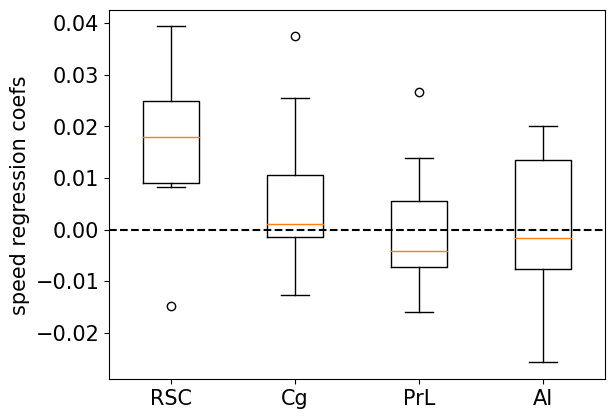

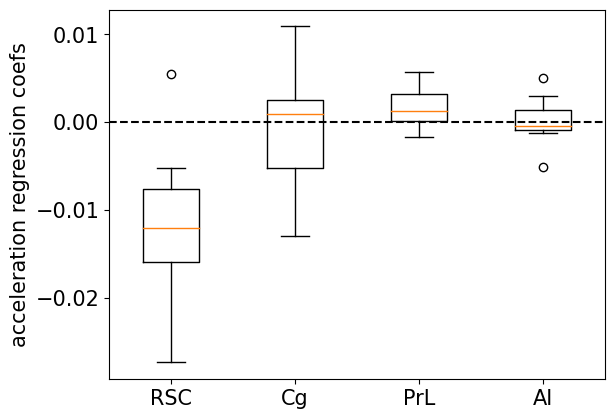

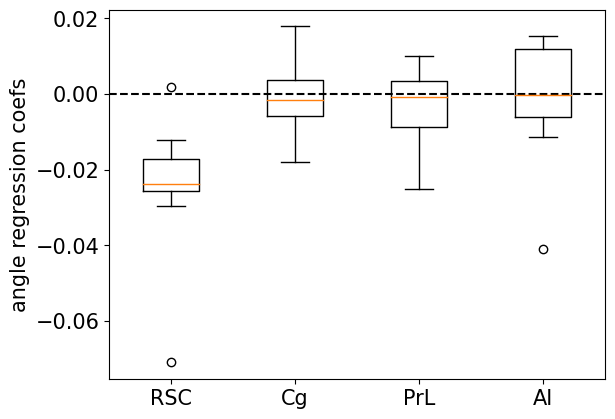

In [94]:
# multivariate regression test
from sklearn import linear_model

rats_all = vars_for_cca_allrats.keys()
coefs_allrats = []
time_bin_shift = 3
motion_names_all = ['speed', 'acceleration', 'angle']#, 'distance from home']

for i_rat in rats_all:
    # write to dataframe
    vars_for_cca_df = pd.DataFrame(data=vars_for_cca_allrats[i_rat])
    df_all.append(vars_for_cca_df)
    # create variables
    X = vars_for_cca_df[regions_all][:-time_bin_shift]
    Y = vars_for_cca_df[motion_names_all][time_bin_shift:]
    # fit model
    model_ols = linear_model.LinearRegression()#linear_model.ElasticNet(alpha = 1,random_state = 0)#
    model_ols.fit(X,Y)
#     LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
    # print coefs
    coef = model_ols.coef_
    intercept = model_ols.intercept_
    print('coef= ', coef)
    print('intercept= ', intercept)
    coefs_allrats.append(coef)
    
# plotting
coefs_allrats_m = np.array(coefs_allrats)

ctr_motion = 0
for motion_curr in motion_names_all:
    plt.figure()
    coefs_curr = coefs_allrats_m[:,ctr_motion,:]
    plt.boxplot(coefs_curr)
    plt.axhline(0, linestyle = '--', color = 'k')
    plt.xticks(np.arange(len(regions_all)) + 1, regions_all)
    plt.ylabel(motion_curr + ' regression coefs')
    plt.savefig(motion_curr+'_multivar_linear_weights_resting.pdf')
    print('\n')
    for i_reg in range(len(regions_all)):
        print(motion_curr, regions_all[i_reg], 
              stats.wilcoxon(coefs_allrats_m[:,ctr_motion,i_reg]))
    ctr_motion += 1

In [96]:
# multivariate regression, training and testing?
from sklearn import linear_model

rats_all = vars_for_cca_allrats.keys()
coefs_allrats = []
time_bin_shift = 0

Nsplits = 10

regions_exclude_all = [['AI','RSC','PrL'],['Cg','RSC','PrL'],
                   ['Cg','AI','PrL'],['Cg','AI','RSC']]

diff_per_pair = np.zeros((len(regions_exclude_all), len(rats_all)*Nsplits))
diff_no_RSC = np.zeros(len(rats_all)*Nsplits)

for i_rat in rats_all:
    # write to dataframe
    vars_for_cca_df = pd.DataFrame(data=vars_for_cca_allrats[i_rat])
    df_all.append(vars_for_cca_df)
    # create variables
    X = vars_for_cca_df[regions_all]#[:-time_bin_shift]
    Y = vars_for_cca_df[motion_names_all]#[time_bin_shift:]

    mse_splits = []
    mse_splits_no_RSC = []
    mse_splits_RSC_only = []
    for i_split in range(Nsplits):
        # split into train and test sets
        idx_all = np.arange(len(X))
        np.random.shuffle(idx_all)
        idx_train = idx_all[:int(len(X)/2)] # equal sized train and test
        idx_test = idx_all[:int(len(X)/2)]

        # fit model
        model_ols =  linear_model.LinearRegression()
        model_ols.fit(X.iloc[idx_train],Y.iloc[idx_train])

        # predict Y on test set
        Ypred = model_ols.predict(X.iloc[idx_test])
        mse_splits.append(np.mean((Ypred - Y.iloc[idx_test])**2))
        
        # fit model with RSC only?
        model_ols =  linear_model.LinearRegression()
        model_ols.fit(X[['RSC']].iloc[idx_train],Y.iloc[idx_train])
        
        # predict Y on test set with RSC only
        Ypred = model_ols.predict(X[['RSC']].iloc[idx_test])
        mse_splits_RSC_only.append(np.mean((Ypred - Y.iloc[idx_test])**2))
        diff_no_RSC[i_rat*Nsplits + i_split] = np.mean(mse_splits_RSC_only[-1] - mse_splits[-1])
        
        ctr_exclude = 0
        
        for region_exclude in regions_exclude_all:
            # fit model without RSC
            model_ols =  linear_model.LinearRegression()
            model_ols.fit(X[region_exclude].iloc[idx_train],Y.iloc[idx_train])

            # predict Y on test set with excluded region
            Ypred = model_ols.predict(X[region_exclude].iloc[idx_test])
            mse_splits_no_RSC.append(np.mean((Ypred - Y.iloc[idx_test])**2))

            diff_per_pair[ctr_exclude, i_rat*Nsplits + i_split] = np.mean(mse_splits_no_RSC[-1] - mse_splits[-1])
            ctr_exclude += 1

#         plt.figure()
#         plt.hist(np.concatenate(mse_splits) - np.concatenate(mse_splits_no_RSC),
#                  alpha = 0.5, label = 'all regions')
    #     plt.hist(np.concatenate(mse_splits_no_RSC), alpha = 0.5, label = 'no RSC')
    #     plt.legend()
#         wilcox_curr = stats.wilcoxon(np.concatenate(mse_splits),
#                                                               np.concatenate(mse_splits_no_RSC),
#                                                              alternative = 'less')
#         print(i_rat, 'all regions vs', region_exclude, wilcox_curr, 
#               np.concatenate(mse_splits_no_RSC) - np.concatenate(mse_splits))
# #         plt.title(wilcox_curr)
        
#         diff_per_pair.append(np.mean(np.concatenate(mse_splits_no_RSC) - np.concatenate(mse_splits)))

C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\si

C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\si

C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\si

C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\si

C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\si

C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\si

C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\si

C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\si

C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\si

C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\si

C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\si

C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\si

C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\si

C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\si

C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\si

C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\si

C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\si

C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\trang\anaconda3\lib\si

['AI', 'RSC', 'PrL'] 0.0006545239884101254 WilcoxonResult(statistic=0.0, pvalue=7.849526548031477e-15)
['Cg', 'RSC', 'PrL'] 0.0001915113762479511 WilcoxonResult(statistic=0.0, pvalue=7.849526548031477e-15)
['Cg', 'AI', 'PrL'] 0.003972367809205087 WilcoxonResult(statistic=0.0, pvalue=7.849526548031477e-15)
['Cg', 'AI', 'RSC'] 0.00018660455663373486 WilcoxonResult(statistic=0.0, pvalue=7.849526548031477e-15)
['AI', 'RSC', 'PrL'] ['Cg', 'RSC', 'PrL'] WilcoxonResult(statistic=618.0, pvalue=1.5407247512170535e-06)
['AI', 'RSC', 'PrL'] ['Cg', 'AI', 'PrL'] WilcoxonResult(statistic=59.0, pvalue=7.046339081038933e-14)
['AI', 'RSC', 'PrL'] ['Cg', 'AI', 'RSC'] WilcoxonResult(statistic=555.0, pvalue=3.255076584956274e-07)
['Cg', 'RSC', 'PrL'] ['Cg', 'AI', 'PrL'] WilcoxonResult(statistic=0.0, pvalue=7.849526548031477e-15)
['Cg', 'RSC', 'PrL'] ['Cg', 'AI', 'RSC'] WilcoxonResult(statistic=1516.0, pvalue=0.617910516872171)
['Cg', 'AI', 'PrL'] ['Cg', 'AI', 'RSC'] WilcoxonResult(statistic=0.0, pvalue=7.

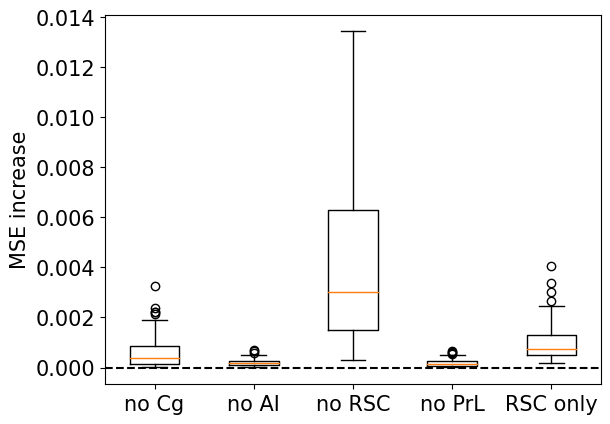

In [97]:
for regions_curr, diff_curr in zip(regions_exclude_all, diff_per_pair):
    print(regions_curr, np.mean(diff_curr), stats.wilcoxon(diff_curr))

for i_reg in range(len(regions_exclude_all)):
    for j_reg in range(i_reg + 1, len(regions_exclude_all)):
        print(regions_exclude_all[i_reg], regions_exclude_all[j_reg], 
        stats.wilcoxon(diff_per_pair[i_reg],diff_per_pair[j_reg]))
        
diff_all = np.concatenate([diff_per_pair,[diff_no_RSC]])
plt.figure()
plt.boxplot(list(diff_all))
plt.xticks(np.arange(len(regions_exclude_all) + 1) + 1, ['no Cg', 'no AI', 'no RSC', 'no PrL', 'RSC only'])
plt.ylabel('MSE increase')
# plt.ylim(0,5e-6)
# plt.yscale('log')
plt.axhline(0, color = 'k', linestyle = '--')
plt.savefig('MSE_increase_multivar_linear_resting.pdf')
# plt.figure()
# plt.hist(diff_no_RSC, weights = np.ones_like(diff_no_RSC)/len(diff_no_RSC))
# plt.xlabel('MSE RSC only - MSE all regions')
# plt.ylabel('fraction of trials')

print('all regions vs RSC only', stats.wilcoxon(diff_no_RSC, alternative = 'greater'))

for i_reg in range(len(regions_exclude_all)):
        print(regions_exclude_all[i_reg], 'RSC only', 
        stats.wilcoxon(diff_per_pair[i_reg],diff_no_RSC, alternative = 'less'))
        

In [98]:
# FC and navigation statistics
# from matplotlib import colors

# len_win_all = np.arange(10,50,20)

# pearson_allwinlen = {}
# pair_names_all = []

# for reg_ctr0 in range(len(regions_all)):
#     for reg_ctr1 in range(reg_ctr0 + 1, len(regions_all)):
#         pair_name = regions_all[reg_ctr0] + '-' + regions_all[reg_ctr1]
#         pearson_allwinlen[pair_name] = []
#         pair_names_all.append(pair_name)

# coef_allrats = []
# for len_win in len_win_all:
#     coef_wincurr = []
#     for i_rat in range(len(accel_pos_allmice)-1):
#         pearson_allregpairs = []
#         vars_for_cca_df = pd.DataFrame(data=vars_for_cca_allrats[i_rat])
#         for reg_ctr0 in range(len(regions_all)):
#             for reg_ctr1 in range(reg_ctr0 + 1, len(regions_all)):
                
#                 pearson_cut = np.zeros(len(vars_for_cca_df[regions_all[0]]) - len_win)
#                 for i_win in range(len(pearson_cut)):                    
#                     # first region
#                     sig_clean_0 = vars_for_cca_df[regions_all[reg_ctr0]][i_win:i_win + len_win]

#                     # second region
#                     sig_clean_1 = vars_for_cca_df[regions_all[reg_ctr1]][i_win:i_win + len_win]
                    
#                     # correlations between regions in that window
#                     pearson_cut[i_win] = stats.pearsonr(sig_clean_0, sig_clean_1)[0]
                    
#                 pearson_allregpairs.append(pearson_cut)
        
        
#         # write to dataframe
#         vars_gcamp_dict = {}
#         for pair_name, pair_pearson in zip(pair_names_all, pearson_allregpairs):
#             vars_gcamp_dict[pair_name] = pair_pearson
            
#         vars_gcamp_df = pd.DataFrame(data=vars_gcamp_dict)
        
#         # create variables
#         X = vars_gcamp_df
#         Y = vars_for_cca_df[motion_names_all][len_win:]

#         # fit model
#         model_ols = linear_model.LinearRegression(normalize=True)
#         model_ols.fit(X,Y)

#         coef = model_ols.coef_
#         intercept = model_ols.intercept_
#         print(len_win, i_rat, 'coef= ', coef)
#         print(len_win, i_rat, 'intercept= ', intercept)
#         coef_wincurr.append(coef)
#     coef_allrats.append(np.array(coef_wincurr))
        
# coef_allrats = np.array(coef_allrats)

In [99]:
# plots and stats per time window

# for i_nav in range(len(nav_stats_names)):
#     for i_len in range(len(len_win_all)):
#         coefs_curr = coef_allrats[i_len, :, i_nav]
        
#         for i_pairs in range(len(pair_names_all)):
#             print(len_win_all[i_len],
#                   nav_stats_names[i_nav], 
#                   pair_names_all[i_pairs],
#                   stats.wilcoxon(coefs_curr[:,i_pairs]))
#         print('\n')
#         plt.figure()
#         plt.boxplot(list(np.transpose(coefs_curr)))
#         plt.xticks(np.arange(len(pair_names_all)) + 1, pair_names_all)
#         plt.ylabel(nav_stats_names[i_nav]+' regression coefs')
#         plt.title('window length = '+str(len_win_all[i_len]/10)+' s')

In [100]:
# plots and stats across time windows

# for i_nav in range(len(nav_stats_names)):
#     coefs_curr = np.concatenate(coef_allrats[:, :, i_nav], axis = 0)

#     for i_pairs in range(len(pair_names_all)):
#         print(nav_stats_names[i_nav], 
#               pair_names_all[i_pairs],
#               stats.wilcoxon(coefs_curr[:,i_pairs]))
#     print('\n')
#     plt.figure()
#     plt.boxplot(list(np.transpose(coefs_curr)))
#     plt.xticks(np.arange(len(pair_names_all)) + 1, pair_names_all)
#     plt.ylabel(nav_stats_names[i_nav]+' regression coefs')
#     plt.axhline(0, color = 'k', linestyle = '--')
#     plt.savefig(nav_stats_names[i_nav]+'_multivar_linear_weights_cov_resting.pdf')

# Vector autoregression 

In [101]:
from statsmodels.tsa.api import VAR

Nkeys = len(vars_for_cca_allrats[0].keys())

params_allrats = np.zeros((len(vars_for_cca_allrats), Nkeys, Nkeys))

for i_rat in range(len(vars_for_cca_allrats)):
    var_df = pd.DataFrame(data=vars_for_cca_allrats[i_rat])
    
    # fit model
    model = VAR(var_df)
    results = model.fit(1) #argument is order of the model i.e. number of time steps back taken into account
    
    # model results
    print(i_rat, results.summary())
    params_var = results.params
    
    # save params to array
    key_ctr = 0
    for key_curr in params_var.keys():
        params_allrats[i_rat, key_ctr, :] = params_var[key_curr][1:]
        key_ctr += 1


0   Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Jul, 2023
Time:                     16:28:12
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -79.7786
Nobs:                     11593.0    HQIC:                  -79.8022
Log likelihood:           347550.    FPE:                2.17350e-35
AIC:                     -79.8141    Det(Omega_mle):     2.16303e-35
--------------------------------------------------------------------
Results for equation speed
                     coefficient       std. error                  t-stat            prob
-----------------------------------------------------------------------------------------
const                   0.000006         0.000000        912997406707.056           0.000
L1.speed                1.000000         0.000000  126219034484406976.000           0.000
L1.acceleration       

1   Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Jul, 2023
Time:                     16:28:13
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -80.3350
Nobs:                     11119.0    HQIC:                  -80.3594
Log likelihood:           336443.    FPE:                1.24440e-35
AIC:                     -80.3718    Det(Omega_mle):     1.23815e-35
--------------------------------------------------------------------
Results for equation speed
                     coefficient       std. error                  t-stat            prob
-----------------------------------------------------------------------------------------
const                  -0.000017         0.000000      -3037093363974.782           0.000
L1.speed                1.000000         0.000000  143930796858353504.000           0.000
L1.acceleration       

2   Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Jul, 2023
Time:                     16:28:14
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -79.1844
Nobs:                     11723.0    HQIC:                  -79.2078
Log likelihood:           347962.    FPE:                3.93863e-35
AIC:                     -79.2196    Det(Omega_mle):     3.91987e-35
--------------------------------------------------------------------
Results for equation speed
                     coefficient       std. error                 t-stat            prob
----------------------------------------------------------------------------------------
const                  -0.000106         0.000000     -7450015684438.572           0.000
L1.speed                1.000000         0.000000  60456837663279120.000           0.000
L1.acceleration         0.

3   Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Jul, 2023
Time:                     16:28:14
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -78.9701
Nobs:                     9829.00    HQIC:                  -78.9972
Log likelihood:           290729.    FPE:                4.85219e-35
AIC:                     -79.0110    Det(Omega_mle):     4.82464e-35
--------------------------------------------------------------------
Results for equation speed
                     coefficient       std. error                  t-stat            prob
-----------------------------------------------------------------------------------------
const                   0.000080         0.000000       8960913631598.594           0.000
L1.speed                1.000000         0.000000   87637052154289200.000           0.000
L1.acceleration       

4   Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Jul, 2023
Time:                     16:28:15
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -79.4906
Nobs:                     11707.0    HQIC:                  -79.5140
Log likelihood:           349280.    FPE:                2.89970e-35
AIC:                     -79.5259    Det(Omega_mle):     2.88587e-35
--------------------------------------------------------------------
Results for equation speed
                     coefficient       std. error                  t-stat            prob
-----------------------------------------------------------------------------------------
const                   0.000049         0.000000       6837890783982.209           0.000
L1.speed                1.000000         0.000000  115400409253873120.000           0.000
L1.acceleration       

5   Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Jul, 2023
Time:                     16:28:16
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -79.7255
Nobs:                     11746.0    HQIC:                  -79.7488
Log likelihood:           351822.    FPE:                2.29302e-35
AIC:                     -79.7606    Det(Omega_mle):     2.28212e-35
--------------------------------------------------------------------
Results for equation speed
                     coefficient       std. error                  t-stat            prob
-----------------------------------------------------------------------------------------
const                   0.000058         0.000000      10490182919022.156           0.000
L1.speed                1.000000         0.000000  160475367057966240.000           0.000
L1.acceleration       

6   Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Jul, 2023
Time:                     16:28:16
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -78.8933
Nobs:                     10570.0    HQIC:                  -78.9188
Log likelihood:           312223.    FPE:                5.25221e-35
AIC:                     -78.9318    Det(Omega_mle):     5.22447e-35
--------------------------------------------------------------------
Results for equation speed
                     coefficient       std. error                 t-stat            prob
----------------------------------------------------------------------------------------
const                  -0.000069         0.000000     -6042399943393.002           0.000
L1.speed                1.000000         0.000000  70491643363171832.000           0.000
L1.acceleration         1.

7   Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Jul, 2023
Time:                     16:28:17
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -78.8831
Nobs:                     11331.0    HQIC:                  -78.9072
Log likelihood:           334628.    FPE:                5.31800e-35
AIC:                     -78.9194    Det(Omega_mle):     5.29179e-35
--------------------------------------------------------------------
Results for equation speed
                     coefficient       std. error                 t-stat            prob
----------------------------------------------------------------------------------------
const                  -0.000028         0.000000     -3040208598529.530           0.000
L1.speed                1.000000         0.000000  92921135144733104.000           0.000
L1.acceleration         0.

speed -> speed 1.0 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
acceleration -> speed 1.0798414875235292 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
angle -> speed 2.1631596656162853e-17 WilcoxonResult(statistic=16.0, pvalue=0.84375)
RSC -> speed -7.527415560695592e-17 WilcoxonResult(statistic=8.0, pvalue=0.1953125)
Cg -> speed 1.601931134892601e-17 WilcoxonResult(statistic=15.0, pvalue=0.7421875)
PrL -> speed 7.345028909374807e-17 WilcoxonResult(statistic=15.0, pvalue=0.7421875)
AI -> speed -1.0502856299153333e-16 WilcoxonResult(statistic=7.0, pvalue=0.1484375)


speed -> acceleration -0.47649214360921843 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
acceleration -> acceleration -0.6365181777839919 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
angle -> acceleration -0.08842856694277682 WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC -> acceleration -0.004978467165072064 WilcoxonResult(statistic=9.0, pvalue=0.25)
Cg -> acceleration 0.0035760491467893363 WilcoxonResult(st

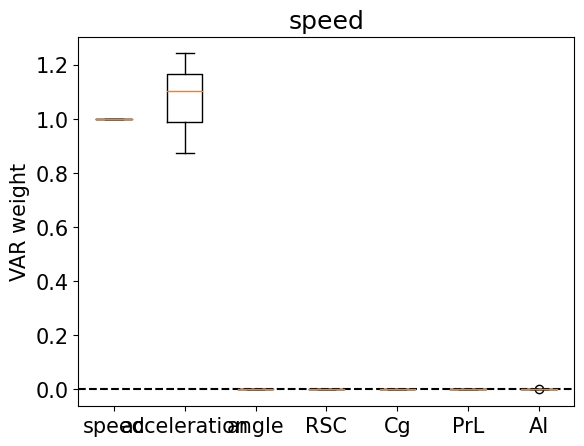

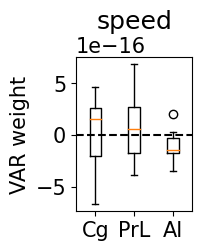

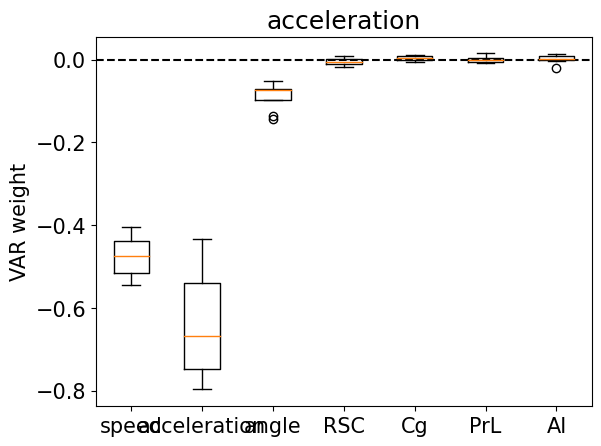

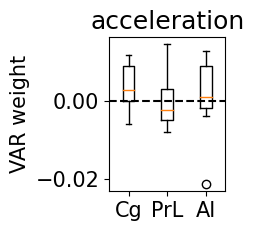

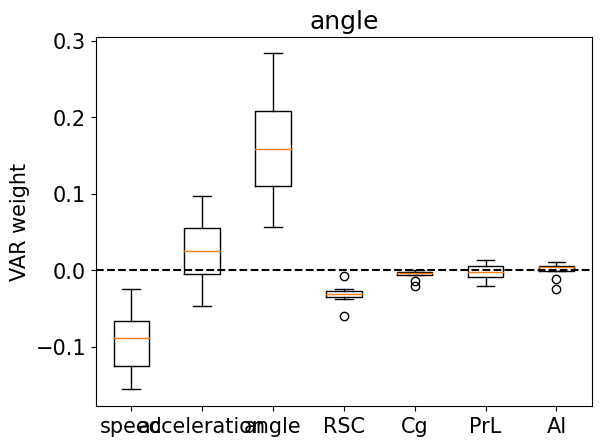

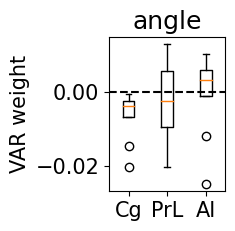

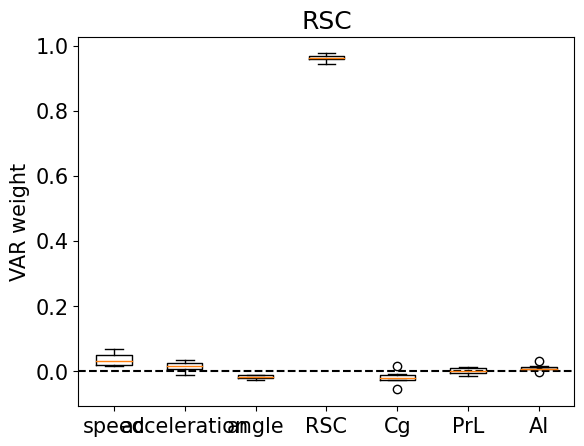

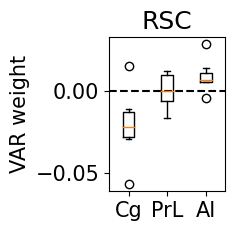

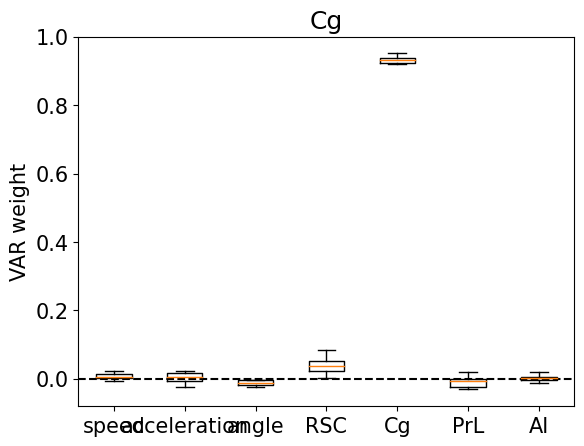

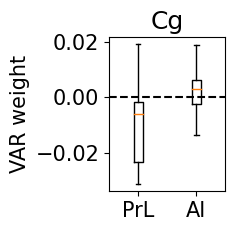

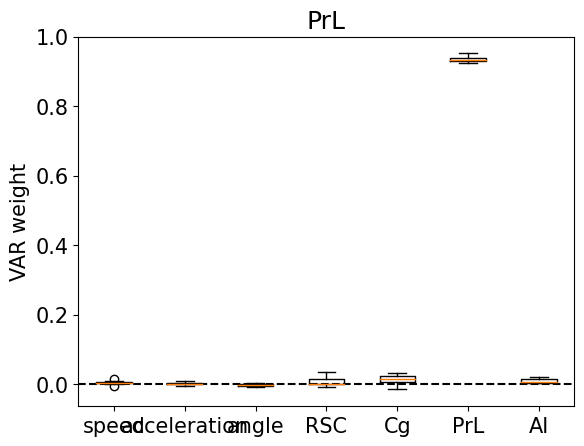

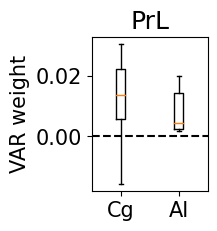

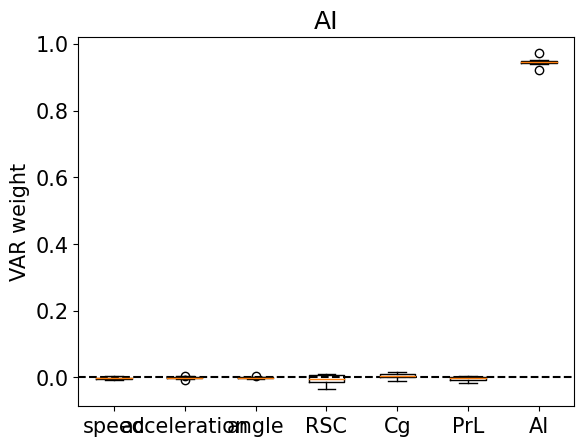

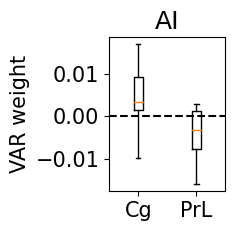

In [102]:
# plotting results

key_ctr = 0
for key_curr in params_var.keys():
    plt.figure()
    plt.boxplot(params_allrats[:, key_ctr, :])
    plt.axhline(0, color = 'k', linestyle = '--')
    plt.xticks(np.arange(len(params_var.keys())) + 1, params_var.keys())
    plt.ylabel('VAR weight')
    plt.title(key_curr)
    
    # zoom on other regions only
    plt.figure(figsize = (1.5, 2))
    idx_keys_GCaMP = np.arange(len(nav_stats_names),len(params_var.keys()),1)
    idx_keys_other_regions = idx_keys_GCaMP[idx_keys_GCaMP != key_ctr]
    
    plt.boxplot(params_allrats[:, key_ctr, idx_keys_other_regions])
    plt.axhline(0, color = 'k', linestyle = '--')
    plt.xticks(np.arange(len(idx_keys_other_regions)) + 1, 
               list(params_var.keys()[idx_keys_other_regions]))
    plt.ylabel('VAR weight')
    plt.title(key_curr)
    
    for i_key in range(Nkeys):
        print(params_var.keys()[i_key],'->', params_var.keys()[key_ctr],
              np.mean(params_allrats[:, key_ctr, i_key]),
              stats.wilcoxon(params_allrats[:, key_ctr, i_key]))

    print('\n')
    key_ctr += 1


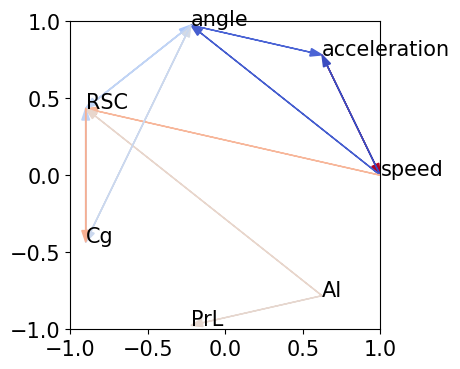

In [103]:
# plotting on circle?

plt.figure(figsize = (4,4))
angles = np.linspace(0, 2*np.pi, len(params_var.keys()) + 1)

cmap = plt.get_cmap('coolwarm')
for iiparam in range(len(params_var.keys())):
    plt.text(np.cos(angles[iiparam]), np.sin(angles[iiparam]), 
             params_var.keys()[iiparam])
    
    for jjparam in range(len(params_var.keys())):
        if iiparam != jjparam:
            if stats.wilcoxon(params_allrats[:, iiparam, jjparam])[1] < 0.05:
                weight_curr = np.mean(params_allrats[:, iiparam, jjparam])
                col_curr = int((weight_curr + 0.1)*255/0.2)
                plt.arrow(np.cos(angles[jjparam]), np.sin(angles[jjparam]), 
                          np.cos(angles[iiparam]) - np.cos(angles[jjparam]),
                          np.sin(angles[iiparam]) - np.sin(angles[jjparam]),
                          length_includes_head = True,
                          color = cmap(col_curr), head_width = 0.05)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.savefig('VAR_weights_arrows_resting.pdf')


(-10.0, 10.0)

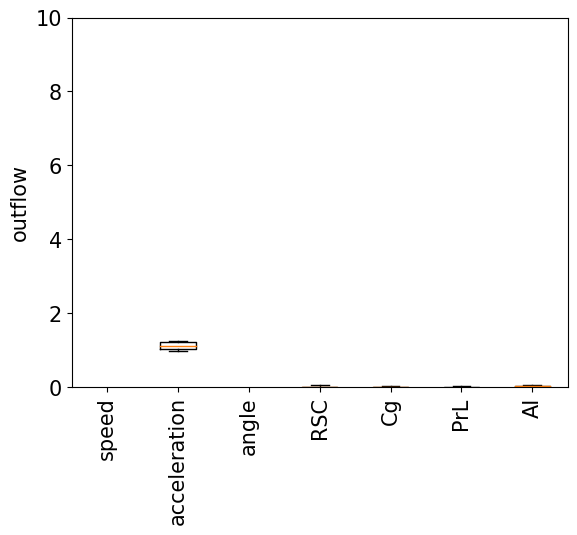

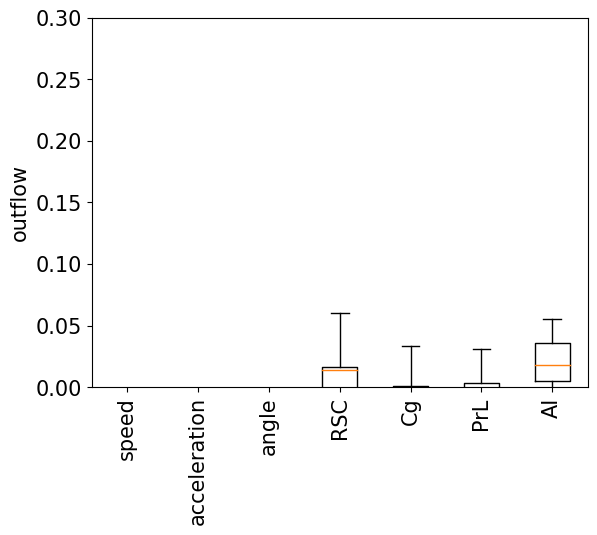

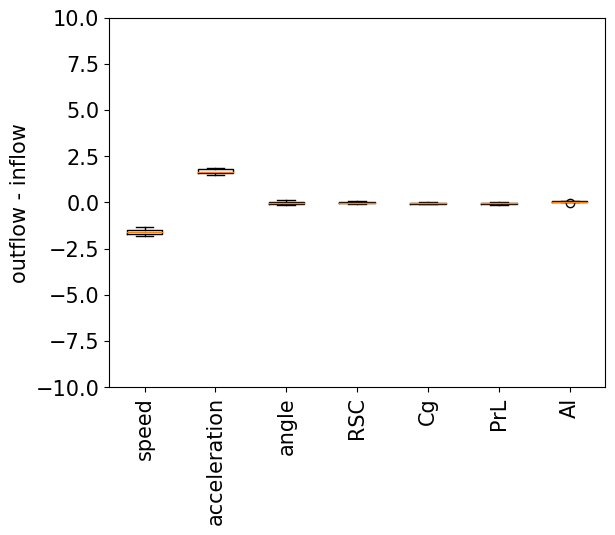

In [104]:
# inflow and outflow...

outflow_allrats = []
flowdiff_allrats = []
for iiparam in range(len(params_var.keys())):
    # discard self weights
    idx = np.arange(len(params_var.keys())) != iiparam

    # outflow and difference
    outflow = np.sum(params_allrats[:, idx, iiparam], axis = 1)
    outflow_allrats.append(outflow)

    # inflow
    inflow = np.sum(params_allrats[:, iiparam, idx], axis = 1)
    flowdiff_allrats.append(outflow - inflow)

#     inflow_allrats.append(inflow[np.arange(len(params_var.keys()))])
#     outflow = np.sum(params_allrats[:, :, iiparam], axis = 1)
    
plt.figure()
plt.boxplot(outflow_allrats)
plt.xticks(np.arange(len(params_var.keys())) + 1, params_var.keys(), rotation = 90)
plt.ylabel('outflow')
plt.ylim(0, 10)

plt.figure()
plt.boxplot(outflow_allrats)
plt.xticks(np.arange(len(params_var.keys())) + 1, params_var.keys(), rotation = 90)
plt.ylabel('outflow')
plt.ylim(0, 0.3)

plt.figure()
plt.boxplot(flowdiff_allrats)
plt.xticks(np.arange(len(params_var.keys())) + 1, params_var.keys(), rotation = 90)
plt.ylabel('outflow - inflow')
plt.ylim(-10, 10)

[array([0.49434995, 0.61308635, 0.62660533, 0.61519568, 0.74604869,
       0.54952682, 0.65795562, 0.67458426]), array([1.15399947, 1.24719423, 1.06441412, 1.32625532, 1.24226993,
       0.99755456, 1.24173526, 1.03595245]), array([0.09792787, 0.11575746, 0.11552293, 0.09781329, 0.18598976,
       0.16855894, 0.09496623, 0.12754068]), array([0.09985134, 0.05804422, 0.14542382, 0.10287048, 0.04609002,
       0.16286619, 0.1073892 , 0.0976469 ]), array([0.05092819, 0.07345621, 0.0728553 , 0.03400311, 0.05380234,
       0.07621911, 0.0670415 , 0.06568237]), array([0.03368571, 0.01778929, 0.04151504, 0.02598581, 0.05495416,
       0.08185148, 0.03086407, 0.06717093]), array([0.02323307, 0.03459344, 0.07319007, 0.05031837, 0.04286984,
       0.02819305, 0.02703378, 0.05568596])]


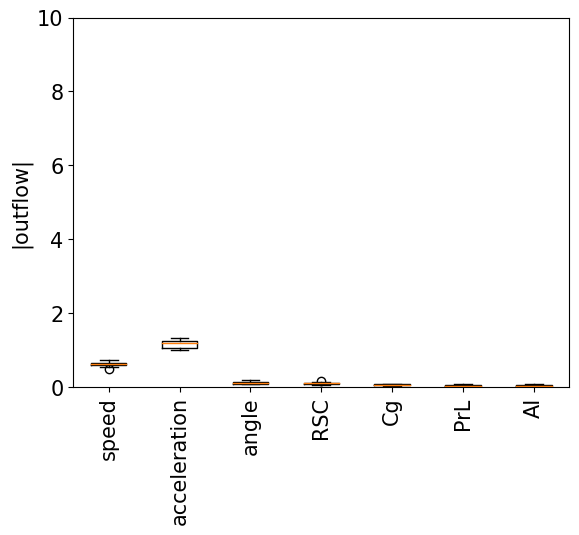

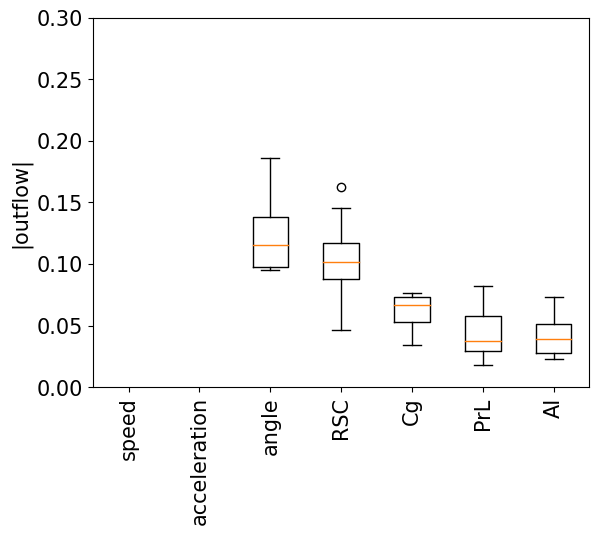

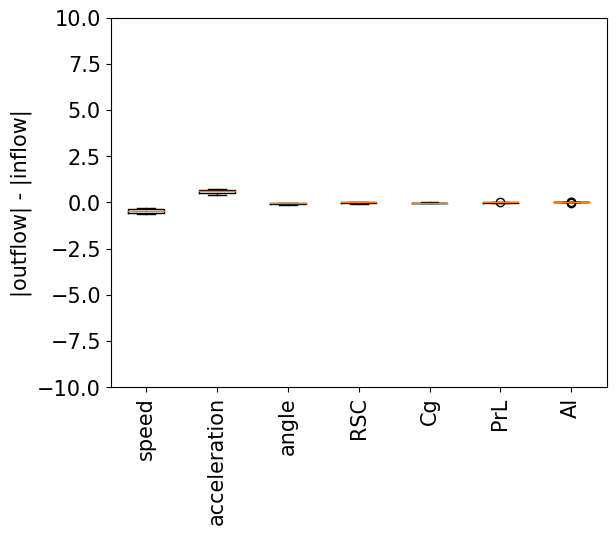

In [105]:
# inflow and outflow, absolute values...

outflow_allrats = []
flowdiff_allrats = []
for iiparam in range(len(params_var.keys())):
    # discard self weights
    idx = np.arange(len(params_var.keys())) != iiparam

    # outflow and difference
    outflow = np.sum(np.abs(params_allrats[:, idx, iiparam]), axis = 1)
    outflow_allrats.append(outflow)

    # inflow
    inflow = np.sum(np.abs(params_allrats[:, iiparam, idx]), axis = 1)
    flowdiff_allrats.append(outflow - inflow)

#     inflow_allrats.append(inflow[np.arange(len(params_var.keys()))])
#     outflow = np.sum(params_allrats[:, :, iiparam], axis = 1)
    
plt.figure()
plt.boxplot(outflow_allrats)
plt.xticks(np.arange(len(params_var.keys())) + 1, params_var.keys(), rotation = 90)
plt.ylabel('|outflow|')
plt.ylim(0, 10)

plt.figure()
plt.boxplot(outflow_allrats)
plt.xticks(np.arange(len(params_var.keys())) + 1, params_var.keys(), rotation = 90)
plt.ylabel('|outflow|')
plt.ylim(0, 0.3)

plt.figure()
plt.boxplot(flowdiff_allrats)
plt.xticks(np.arange(len(params_var.keys())) + 1, params_var.keys(), rotation = 90)
plt.ylabel('|outflow| - |inflow|')
plt.ylim(-10, 10)

print(outflow_allrats)

In [106]:
regions_exclude_all = [['speed', 'acceleration', 'angle', 'AI','RSC','PrL'],
                       ['speed', 'acceleration', 'angle', 'Cg','RSC','PrL'],
                       ['speed', 'acceleration', 'angle', 'Cg','AI','PrL'],
                       ['speed', 'acceleration', 'angle', 'Cg','AI','RSC']]

diffAIC_per_pair = np.zeros((len(regions_exclude_all), len(rats_all)))
diffAIC_RSC_only = np.zeros(len(rats_all))
diffBIC_per_pair = np.zeros((len(regions_exclude_all), len(rats_all)))
diffBIC_RSC_only = np.zeros(len(rats_all))
loglikelihood_per_pair = np.zeros((len(regions_exclude_all), len(rats_all)))

params_exclude_reg_allrats = np.zeros((len(regions_exclude_all), len(vars_for_cca_allrats), 
                                       len(regions_exclude_all[0]), len(regions_exclude_all[0])))

for i_rat in rats_all:
    # write to dataframe
    var_df = pd.DataFrame(data=vars_for_cca_allrats[i_rat])
    df_all.append(vars_for_cca_df)

    # fit model with all variables
    model = VAR(var_df)
    results = model.fit(1)
    
    AIC_full = results.aic
    BIC_full = results.bic
    llf_full = results.llf
    print(results.aic, results.bic)

    # fit model with RSC only
    model_RSC_only =  VAR(var_df[['speed', 'acceleration', 'angle', 'RSC']])
    results_RSC_only = model_RSC_only.fit(1)

    diffAIC_RSC_only[i_rat] = AIC_full - results_RSC_only.aic 
    diffBIC_RSC_only[i_rat] = BIC_full - results_RSC_only.bic 
    print(results_RSC_only.aic, results_RSC_only.bic, diffAIC_RSC_only[i_rat], diffBIC_RSC_only[i_rat])

    ctr_exclude = 0

    for region_exclude in regions_exclude_all:
        # fit model without excluded region
        model_exclude_reg =  VAR(var_df[region_exclude])
        results_exclude_reg = model_exclude_reg.fit(1)

        diffAIC_per_pair[ctr_exclude, i_rat] = results_exclude_reg.aic - AIC_full
        diffBIC_per_pair[ctr_exclude, i_rat] = results_exclude_reg.bic - BIC_full
        loglikelihood_per_pair[ctr_exclude, i_rat] = results_exclude_reg.llf - llf_full
        
        # save params to array
        key_ctr = 0
        print(results_exclude_reg.params.keys())
        for key_curr in results_exclude_reg.params.keys():
            params_exclude_reg_allrats[ctr_exclude, i_rat, 
                                       key_ctr, :] = results_exclude_reg.params[key_curr][1:]
            key_ctr += 1
            
        ctr_exclude += 1

        


-79.81414080677882 -79.77859722204549
-73.37398950729198 -73.36129536988722 -6.440151299486843 -6.417301852158275
Index(['speed', 'acceleration', 'angle', 'AI', 'RSC', 'PrL'], dtype='object')
Index(['speed', 'acceleration', 'angle', 'Cg', 'RSC', 'PrL'], dtype='object')
Index(['speed', 'acceleration', 'angle', 'Cg', 'AI', 'PrL'], dtype='object')
Index(['speed', 'acceleration', 'angle', 'Cg', 'AI', 'RSC'], dtype='object')
-80.3718277903372 -80.33497924320173
-70.97927479299852 -70.96611459759299 -9.392552997338683 -9.368864645608738
Index(['speed', 'acceleration', 'angle', 'AI', 'RSC', 'PrL'], dtype='object')
Index(['speed', 'acceleration', 'angle', 'Cg', 'RSC', 'PrL'], dtype='object')
Index(['speed', 'acceleration', 'angle', 'Cg', 'AI', 'PrL'], dtype='object')
Index(['speed', 'acceleration', 'angle', 'Cg', 'AI', 'RSC'], dtype='object')
-79.2196443271873 -79.18444162752236
-72.07220395727906 -72.05963156454158 -7.147440369908239 -7.124810062980785
Index(['speed', 'acceleration', 'angle',

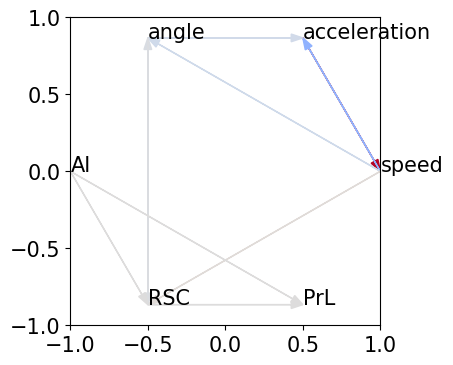

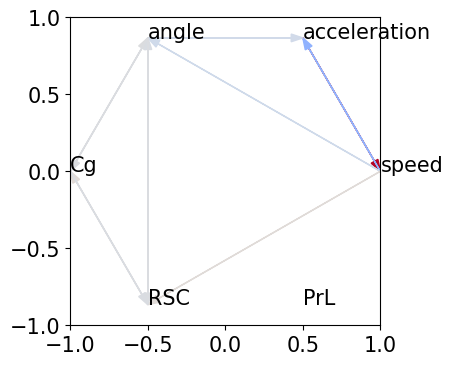

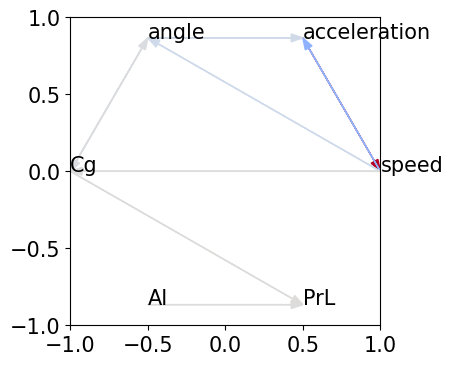

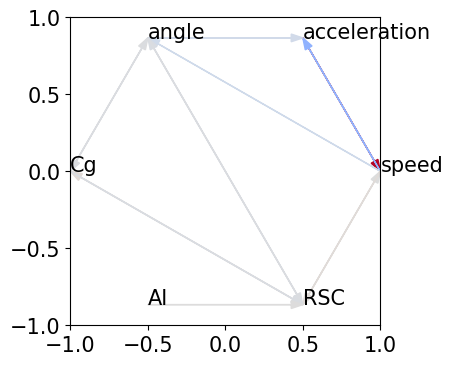

In [107]:
params_exclude_reg_allrats = np.array(params_exclude_reg_allrats)

for ii_excl in range(len(params_exclude_reg_allrats)):
    plt.figure(figsize = (4,4))
    angles = np.linspace(0, 2*np.pi, len(regions_exclude_all[ii_excl]) + 1)

    cmap = plt.get_cmap('coolwarm')
    for iiparam in range(len(regions_exclude_all[ii_excl])):
        plt.text(np.cos(angles[iiparam]), np.sin(angles[iiparam]), 
                 regions_exclude_all[ii_excl][iiparam])

        for jjparam in range(len(regions_exclude_all[ii_excl])):
            if iiparam != jjparam:
                if stats.wilcoxon(params_exclude_reg_allrats[ii_excl, :, iiparam, jjparam])[1] < 0.05:
                    weight_curr = np.mean(params_exclude_reg_allrats[ii_excl, 
                                                                     :, iiparam, jjparam])
                    col_curr = int((weight_curr + 1)*255/2)
                    plt.arrow(np.cos(angles[jjparam]), np.sin(angles[jjparam]), 
                              np.cos(angles[iiparam]) - np.cos(angles[jjparam]),
                              np.sin(angles[iiparam]) - np.sin(angles[jjparam]),
                              length_includes_head = True,
                              color = cmap(col_curr), head_width = 0.05)
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.savefig('VAR_weights_arrows_resting_exclude_reg'+str(ii_excl)+'.pdf')
#     plt.savefig('VAR_weights_arrows_resting_GCaMP only.pdf')

no RSC, AIC change:  WilcoxonResult(statistic=0.0, pvalue=0.0078125)
no Cg, AIC change:  WilcoxonResult(statistic=0.0, pvalue=0.0078125)
no PrL, AIC change:  WilcoxonResult(statistic=0.0, pvalue=0.0078125)
no AI, AIC change:  WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC Cg WilcoxonResult(statistic=7.0, pvalue=0.1484375)
RSC PrL WilcoxonResult(statistic=8.0, pvalue=0.1953125)
RSC AI WilcoxonResult(statistic=14.0, pvalue=0.640625)
Cg PrL WilcoxonResult(statistic=13.0, pvalue=0.546875)
Cg AI WilcoxonResult(statistic=14.0, pvalue=0.640625)
PrL AI WilcoxonResult(statistic=16.0, pvalue=0.84375)


no RSC, BIC change:  WilcoxonResult(statistic=0.0, pvalue=0.0078125)
no Cg, BIC change:  WilcoxonResult(statistic=0.0, pvalue=0.0078125)
no PrL, BIC change:  WilcoxonResult(statistic=1.0, pvalue=0.015625)
no AI, BIC change:  WilcoxonResult(statistic=0.0, pvalue=0.0078125)
RSC Cg WilcoxonResult(statistic=7.0, pvalue=0.1484375)
RSC PrL WilcoxonResult(statistic=8.0, pvalue=0.1953125)
RSC AI Wilc

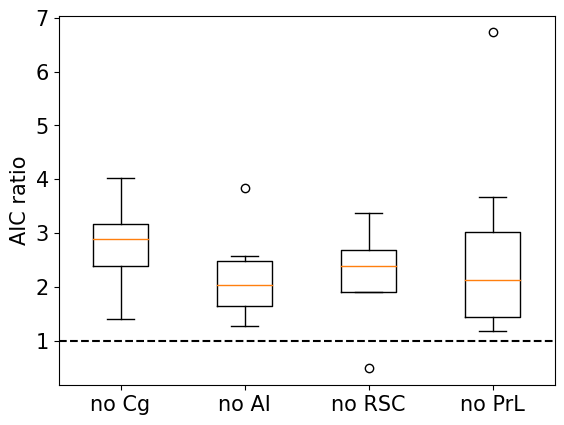

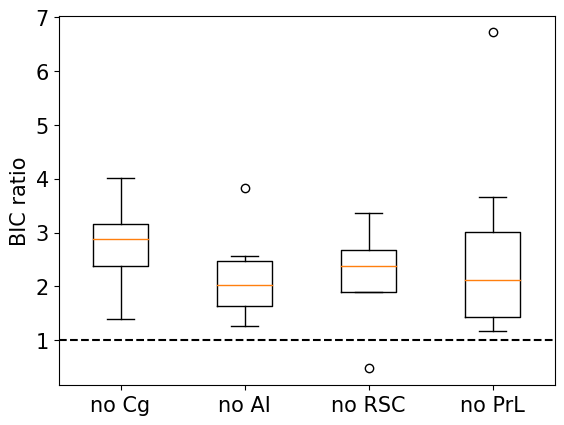

In [108]:
# plot AIC change
plt.figure()
plt.boxplot(np.transpose(diffAIC_per_pair))
plt.xticks(np.arange(len(regions_all)) + 1, ['no Cg', 'no AI', 'no RSC', 'no PrL'])
plt.axhline(1, color = 'k', linestyle = '--')
plt.ylabel('AIC ratio')
plt.savefig('AIC_ratio_VAR_resting.pdf')

for i_excl in range(len(regions_all)):
    print('no ' + regions_all[i_excl] +', AIC change: ', 
          stats.wilcoxon(diffAIC_per_pair[i_excl]))

for i_excl in range(len(regions_all)):
    for j_excl in range(i_excl + 1, len(regions_all)):
        print(regions_all[i_excl],regions_all[j_excl],
              stats.wilcoxon(diffAIC_per_pair[i_excl], diffAIC_per_pair[j_excl]))
print('\n')

# plot BIC change
plt.figure()
plt.boxplot(np.transpose(diffBIC_per_pair))
plt.xticks(np.arange(len(regions_all)) + 1, ['no Cg', 'no AI', 'no RSC', 'no PrL'])
plt.axhline(1, color = 'k', linestyle = '--')
plt.ylabel('BIC ratio')
plt.savefig('BIC_ratio_VAR_resting.pdf')

for i_excl in range(len(regions_all)):
    print('no ' + regions_all[i_excl] +', BIC change: ', 
          stats.wilcoxon(diffBIC_per_pair[i_excl] - 1))
    
for i_excl in range(len(regions_all)):
    for j_excl in range(i_excl + 1, len(regions_all)):
        print(regions_all[i_excl],regions_all[j_excl],
              stats.wilcoxon(diffBIC_per_pair[i_excl], diffBIC_per_pair[j_excl]))


In [109]:
# VAR with GCaMP signals only, NO navigation stats

vars_GCaMP_only_allrats = {}
df_all = []

gcamp_mean = []
y_variance = []
# cmap = plt.get_cmap('tab10')

Xc_allrats = []
Yc_allrats = []
for i_rat in range(len(gcamp_allmice_cut)):
    plt.figure(figsize = (5,5))

    # make variable dictionary
    vars_for_cca = {}

    # motion, per statistics
    ctr_stat = 0
    for motion_name_curr in motion_names_all:

        delta_pos_curr = motion_all[ctr_stat][i_rat + 1]
        idx_curr = idx_keep[i_rat + 1]
        delta_pos_cut = delta_pos_curr[np.logical_and(idx_curr[:len(delta_pos_curr)] > ncut,
                        idx_curr[:len(delta_pos_curr)] < 12000 - ncut)]        
#         if ctr_stat == 0:
#             vars_for_cca[motion_name_curr] = delta_pos_cut[:-1]
#         else:
#         vars_for_cca[motion_name_curr] = delta_pos_cut
        ctr_stat += 1
    len_all = len(delta_pos_cut)
    
    #GCaMP, per region
    gcamp_vars = gcamp_allmice_cut[i_rat][idx_regions_choose,:len_all]
    
    gcamp_mean_curr = []
    for i_reg in range(len(regions_all)):
        gcamp_mean_curr.append(np.mean(sig_per_window(gcamp_vars[i_reg]), 
                                  axis = 1))
    gcamp_mean.append(gcamp_mean_curr)
    ctr_reg = 0
    
    for region_curr in regions_all:
        vars_for_cca[region_curr] = gcamp_vars[ctr_reg]
        ctr_reg += 1

    vars_GCaMP_only_allrats[i_rat] = vars_for_cca

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [110]:
Nkeys = len(vars_GCaMP_only_allrats[0].keys())
print(Nkeys)
params_allrats = np.zeros((len(vars_for_cca_allrats), Nkeys, Nkeys))

for i_rat in range(len(vars_for_cca_allrats)):
    var_df = pd.DataFrame(data=vars_GCaMP_only_allrats[i_rat])
    
    # fit model
    model = VAR(var_df)
    results = model.fit(1) #argument is order of the model i.e. number of time steps back taken into account
    
    # model results
    print(i_rat, results.summary())
    params_var = results.params
    
    # save params to array
    key_ctr = 0
    for key_curr in params_var.keys():
        params_allrats[i_rat, key_ctr, :] = params_var[key_curr][1:]
        key_ctr += 1


4
0   Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Jul, 2023
Time:                     16:29:49
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -9.66198
Nobs:                     11593.0    HQIC:                  -9.67040
Log likelihood:          -9699.79    FPE:                6.28556e-05
AIC:                     -9.67467    Det(Omega_mle):     6.27473e-05
--------------------------------------------------------------------
Results for equation RSC
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.000205         0.002749            0.074           0.941
L1.RSC         0.965551         0.003500          275.841           0.000
L1.Cg         -0.021186         0.003714           -5.704           0.000
L1.PrL      

3   Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Jul, 2023
Time:                     16:29:51
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -9.05025
Nobs:                     9829.00    HQIC:                  -9.05993
Log likelihood:          -11217.6    FPE:                0.000115656
AIC:                     -9.06489    Det(Omega_mle):     0.000115421
--------------------------------------------------------------------
Results for equation RSC
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.002096         0.002896            0.724           0.469
L1.RSC         0.960465         0.003230          297.345           0.000
L1.Cg         -0.010722         0.003357           -3.194           0.001
L1.PrL        

6   Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Jul, 2023
Time:                     16:29:52
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -9.56458
Nobs:                     10570.0    HQIC:                  -9.57369
Log likelihood:          -9351.26    FPE:                6.92126e-05
AIC:                     -9.57833    Det(Omega_mle):     6.90818e-05
--------------------------------------------------------------------
Results for equation RSC
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.000594         0.002735            0.217           0.828
L1.RSC         0.965101         0.003249          297.082           0.000
L1.Cg         -0.030091         0.003158           -9.528           0.000
L1.PrL        

KruskalResult(statistic=11.923295454545453, pvalue=0.007650590336142383)
KruskalResult(statistic=11.9375, pvalue=0.007600354611513049)
outflow RSC Cg WilcoxonResult(statistic=10.0, pvalue=0.3125)
outflow RSC PrL WilcoxonResult(statistic=1.0, pvalue=0.015625)
outflow RSC AI WilcoxonResult(statistic=3.0, pvalue=0.0390625)
outflow Cg PrL WilcoxonResult(statistic=0.0, pvalue=0.0078125)
outflow Cg AI WilcoxonResult(statistic=0.0, pvalue=0.0078125)
outflow PrL AI WilcoxonResult(statistic=17.0, pvalue=0.9453125)
FDR corrected  RSC Cg 0.375
FDR corrected  RSC PrL 0.03125
FDR corrected  RSC AI 0.05859375
FDR corrected  Cg PrL 0.0234375
FDR corrected  Cg AI 0.0234375
FDR corrected  PrL AI 0.9453125


outflow - inflow RSC Cg WilcoxonResult(statistic=3.0, pvalue=0.0390625)
outflow - inflow RSC PrL WilcoxonResult(statistic=0.0, pvalue=0.0078125)
outflow - inflow RSC AI WilcoxonResult(statistic=5.0, pvalue=0.078125)
outflow - inflow Cg PrL WilcoxonResult(statistic=12.0, pvalue=0.4609375)
outflow - i

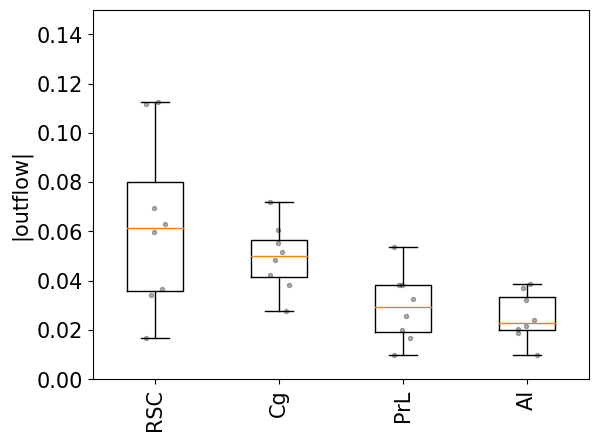

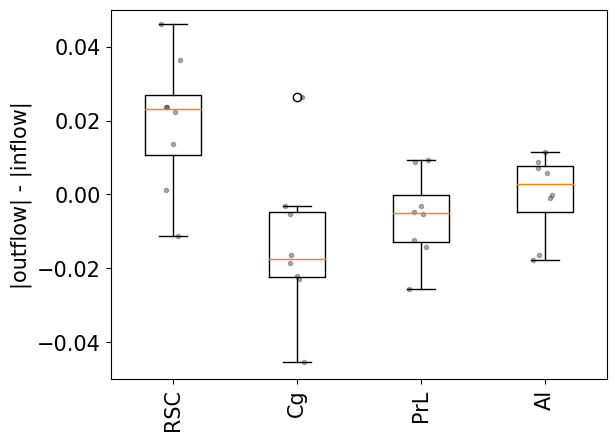

In [111]:
# inflow and outflow, absolute values...

outflow_allrats = []
flowdiff_allrats = []
for iiparam in range(len(params_var.keys())):
    # discard self weights
    idx = np.arange(len(params_var.keys())) != iiparam

    # outflow and difference
    outflow = np.sum(np.abs(params_allrats[:, idx, iiparam]), axis = 1)
    outflow_allrats.append(outflow)

    # inflow
    inflow = np.sum(np.abs(params_allrats[:, iiparam, idx]), axis = 1)
    flowdiff_allrats.append(outflow - inflow)

#     inflow_allrats.append(inflow[np.arange(len(params_var.keys()))])
#     outflow = np.sum(params_allrats[:, :, iiparam], axis = 1)
    
plt.figure()
plt.boxplot(outflow_allrats)
ctr_plot = 0
shifts = (np.random.rand(len(outflow_allrats[0])) - 0.5)*0.2 + 1
for ii in outflow_allrats:
    plt.plot(ctr_plot + shifts, ii, 'k.', 
             alpha = 0.3)
    ctr_plot += 1
plt.xticks(np.arange(len(params_var.keys())) + 1, params_var.keys(), rotation = 90)
plt.ylabel('|outflow|')
plt.ylim(0, 0.15)
plt.savefig('VAR_GCaMP_only_outflow_abs_box.pdf')
print(stats.kruskal(*outflow_allrats))

plt.figure()
plt.boxplot(flowdiff_allrats)
ctr_plot = 0
shifts = (np.random.rand(len(outflow_allrats[0])) - 0.5)*0.2 + 1
for ii in flowdiff_allrats:
    plt.plot(ctr_plot + shifts, ii, 'k.', 
             alpha = 0.3)
    ctr_plot += 1
plt.xticks(np.arange(len(params_var.keys())) + 1, params_var.keys(), rotation = 90)
# plt.ylabel('|outflow| - |inflow|')
plt.ylabel('|outflow| - |inflow|')
plt.ylim(-0.05, 0.05)
# plt.axhline(0, color = 'k', linestyle = '--')
plt.savefig('VAR_GCaMP_only_inflow_abs_box.pdf')
print(stats.kruskal(*flowdiff_allrats))

pval_uncorrected = []
for i_reg in range(len(regions_all)):
    for j_reg in range(i_reg + 1, len(regions_all)):
        print('outflow', regions_all[i_reg], regions_all[j_reg],
              stats.wilcoxon(outflow_allrats[i_reg], 
                             outflow_allrats[j_reg]))
        pval_uncorrected.append(stats.wilcoxon(outflow_allrats[i_reg], 
                             outflow_allrats[j_reg])[1])
# FDR CORRECTION
rej, pval_corrected = fdrcorrection(pval_uncorrected)
ctr = 0
for i_reg in range(len(regions_all)):
    for j_reg in range(i_reg + 1, len(regions_all)):
        print('FDR corrected ', regions_all[i_reg],regions_all[j_reg],
              pval_corrected[ctr])
        ctr += 1
print('\n')

# for i_reg in range(len(regions_all)):
#     print('outflow - inflow', regions_all[i_reg], 
#               stats.wilcoxon(flowdiff_allrats[i_reg]))
pval_uncorrected = []
for i_reg in range(len(regions_all)):
    for j_reg in range(i_reg + 1, len(regions_all)):
        print('outflow - inflow', regions_all[i_reg], regions_all[j_reg],
              stats.wilcoxon(flowdiff_allrats[i_reg], 
                             flowdiff_allrats[j_reg]))
        pval_uncorrected.append(stats.wilcoxon(flowdiff_allrats[i_reg], 
                             flowdiff_allrats[j_reg])[1])
# FDR CORRECTION
rej, pval_corrected = fdrcorrection(pval_uncorrected)
ctr = 0
for i_reg in range(len(regions_all)):
    for j_reg in range(i_reg + 1, len(regions_all)):
        print('FDR corrected ', regions_all[i_reg],regions_all[j_reg],
              pval_corrected[ctr])
        ctr += 1

0.2388483661255702 0.2388483661255702
RSC  to  Cg WilcoxonResult(statistic=3.0, pvalue=0.0390625)
RSC  to  PrL WilcoxonResult(statistic=18.0, pvalue=1.0)
RSC  to  AI WilcoxonResult(statistic=3.0, pvalue=0.0390625)
Cg  to  RSC WilcoxonResult(statistic=0.0, pvalue=0.0078125)
Cg  to  PrL WilcoxonResult(statistic=8.0, pvalue=0.1953125)
Cg  to  AI WilcoxonResult(statistic=14.0, pvalue=0.640625)
PrL  to  RSC WilcoxonResult(statistic=15.0, pvalue=0.7421875)
PrL  to  Cg WilcoxonResult(statistic=6.0, pvalue=0.109375)
PrL  to  AI WilcoxonResult(statistic=0.0, pvalue=0.0078125)
AI  to  RSC WilcoxonResult(statistic=10.0, pvalue=0.3125)
AI  to  Cg WilcoxonResult(statistic=7.0, pvalue=0.1484375)
AI  to  PrL WilcoxonResult(statistic=6.0, pvalue=0.109375)
0 0.03


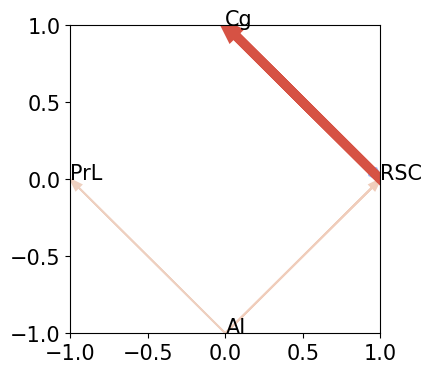

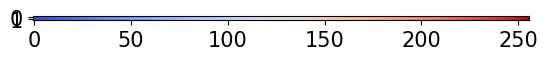

In [122]:
# plotting on circle?

plt.figure(figsize = (4,4))
angles = np.linspace(0, 2*np.pi, len(params_var.keys()) + 1)

cmap = plt.get_cmap('coolwarm')
weights_mean = np.mean(np.mean(params_allrats, axis = 0))
print(np.min(weights_mean), np.max(weights_mean))
col_min = 0
col_max = 0.03
for iiparam in range(len(params_var.keys())):
    plt.text(np.cos(angles[iiparam]), np.sin(angles[iiparam]), 
             params_var.keys()[iiparam])
    
    for jjparam in range(len(params_var.keys())):
        if iiparam != jjparam:
            print(regions_all[iiparam], ' to ', regions_all[jjparam],
                  stats.wilcoxon(params_allrats[:, iiparam, jjparam]))
            if stats.wilcoxon(params_allrats[:, iiparam, jjparam])[1] < 0.05:
                weight_curr = np.mean(params_allrats[:, iiparam, jjparam])
                col_curr = int((weight_curr + 0.05)*255/0.1)
                plt.arrow(np.cos(angles[jjparam]), np.sin(angles[jjparam]), 
                          np.cos(angles[iiparam]) - np.cos(angles[jjparam]),
                          np.sin(angles[iiparam]) - np.sin(angles[jjparam]),
                          length_includes_head = True,
                          linewidth = (weight_curr - col_min)/(col_max - col_min)*5,
                          color = cmap(col_curr), head_width = 0.05)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.savefig('VAR_weights_arrows_resting_GCaMP only.pdf')

plt.figure()
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.imshow(gradient, cmap=cmap)
plt.savefig('VAR_colorbar.pdf')
print(col_min, col_max)

In [113]:
# VAR GCaMP only, exclude regions
regions_exclude_all = [['AI','RSC','PrL'],
                       ['Cg','RSC','PrL'],
                       ['Cg','AI','PrL'],
                       ['Cg','AI','RSC']]

diffAIC_GCaMP_only = np.zeros((len(regions_exclude_all), len(rats_all)))
diffBIC_GCaMP_only = np.zeros((len(regions_exclude_all), len(rats_all)))
loglikelihood_GCaMP_only = np.zeros((len(regions_exclude_all), len(rats_all)))

rats_all = np.arange(8)
for i_rat in rats_all:
    # write to dataframe
    var_df = pd.DataFrame(data=vars_for_cca_allrats[i_rat])
    df_all.append(vars_for_cca_df)

    # fit model with all variables
    model = VAR(var_df)
    results = model.fit(1)
    
    AIC_full = results.aic
    BIC_full = results.bic
    llf_full = results.llf
    print(results.aic, results.bic)

    ctr_exclude = 0

    for region_exclude in regions_exclude_all:
        # fit model without excluded region
        model_exclude_reg =  VAR(var_df[region_exclude])
        results_exclude_reg = model_exclude_reg.fit(1)

        diffAIC_GCaMP_only[ctr_exclude, i_rat] = results_exclude_reg.aic - AIC_full
        diffBIC_GCaMP_only[ctr_exclude, i_rat] = results_exclude_reg.bic - BIC_full
        loglikelihood_GCaMP_only[ctr_exclude, i_rat] = results_exclude_reg.llf - llf_full
        ctr_exclude += 1

-79.81414080677882 -79.77859722204549
-80.3718277903372 -80.33497924320173
-79.2196443271873 -79.18444162752236
-79.01104790383847 -78.97006579184338
-79.5258702984088 -79.49062602019758
-79.76060645113563 -79.72546333773357
-78.93182945614709 -78.89333528354383
-78.91938157823193 -78.88312911452729


In [114]:
# print(diffAIC_per_pair/diffAIC_GCaMP_only)
print(-loglikelihood_per_pair, -loglikelihood_GCaMP_only)



[[  6887.24419788   1085.57970651  -8359.31696715  -1823.18276854
    1923.54180758   -481.47193239   2003.88991315  -3800.98226038]
 [ -3189.38231551   5615.66519165  -2297.33610369  -7153.26178765
   -6504.44984179  -1549.00618308  -8224.54458387  -5915.52536705]
 [ -3156.24092628   2957.67565314   -131.78401766  -4533.68912776
   -5436.08114322  -1134.2033375   -1920.79004942 -13335.33051578]
 [  -220.97565434   4657.11978835  -8167.72802095  -6955.3277479
   -9707.93611546  22868.35113025  -4295.93104834  -3340.30648126]] [[356380.17312774 344600.29625939 351956.32152981 299638.94065591
  357985.13860898 361243.77628474 320066.09872237 343042.87828844]
 [353841.70795452 342137.83512354 351854.4475504  298857.668179
  357336.17024046 360060.47299945 319283.67918971 341681.97310931]
 [356729.52868627 345455.8536887  352030.52371226 300831.46704116
  359964.63404887 362594.59105395 320386.16339822 344607.25888743]
 [354586.05480661 342617.67075958 350843.54850147 298062.03900953
  357

In [115]:
# FC and navigation statistics
# from matplotlib import colors

# len_win_all = np.arange(10,50,20)

# pearson_allwinlen = {}
# pair_names_all = []

# for reg_ctr0 in range(len(regions_all)):
#     for reg_ctr1 in range(reg_ctr0 + 1, len(regions_all)):
#         pair_name = regions_all[reg_ctr0] + '-' + regions_all[reg_ctr1]
#         pearson_allwinlen[pair_name] = []
#         pair_names_all.append(pair_name)

# diffAIC_per_pair = np.zeros((len(len_win_all), len(rats_all), len(pair_names_all)))
# diffBIC_per_pair = np.zeros((len(len_win_all), len(rats_all), len(pair_names_all)))

# ctr_lenwin = 0
# for len_win in len_win_all:
#     for i_rat in range(len(accel_pos_allmice)-1):
#         pearson_allregpairs = []
#         vars_for_cca_df = pd.DataFrame(data=vars_for_cca_allrats[i_rat])
#         for reg_ctr0 in range(len(regions_all)):
#             for reg_ctr1 in range(reg_ctr0 + 1, len(regions_all)):
                
#                 pearson_cut = np.zeros(len(vars_for_cca_df[regions_all[0]]) - len_win)
#                 for i_win in range(len(pearson_cut)):                    
#                     # first region
#                     sig_clean_0 = vars_for_cca_df[regions_all[reg_ctr0]][i_win:i_win + len_win]

#                     # second region
#                     sig_clean_1 = vars_for_cca_df[regions_all[reg_ctr1]][i_win:i_win + len_win]
                    
#                     # correlations between regions in that window
#                     pearson_cut[i_win] = stats.pearsonr(sig_clean_0, sig_clean_1)[0]
                    
#                 pearson_allregpairs.append(pearson_cut)
        
#         # write to dataframe
#         # gcamp
#         var_dict = {}
#         for pair_name, pair_pearson in zip(pair_names_all, pearson_allregpairs):
#             var_dict[pair_name] = pair_pearson
#         # navigation
#         for nav_curr in motion_names_all:
#             var_dict[pair_name] = vars_for_cca_allrats[i_rat][nav_curr][len_win:]

#         var_df = pd.DataFrame(data=var_dict)

#         # fit model with all variables
#         model = VAR(var_df)
#         results = model.fit(1)

#         AIC_full = results.aic
#         BIC_full = results.bic
        
#         # exclude pairs of regions
#         keys_all = var_dict.keys()
        
#         for i_pair_exclude in range(len(pair_names_all)):
#             # remove pair from list
#             keys_exclude = np.delete(list(keys_all), i_pair_exclude)
            
#             # fit model without excluded region
#             model_exclude_reg =  VAR(var_df[keys_exclude])
#             results_exclude_reg = model_exclude_reg.fit(1)

#             diffAIC_per_pair[ctr_lenwin, i_rat, i_pair_exclude] = results_exclude_reg.aic/AIC_full
#             diffBIC_per_pair[ctr_lenwin, i_rat, i_pair_exclude] = results_exclude_reg.bic/BIC_full
            
#             print(len_win, i_rat, BIC_full, 
#                   pair_names_all[i_pair_exclude],
#                   diffBIC_per_pair[ctr_lenwin, i_rat, i_pair_exclude])
#             ctr_exclude += 1
#     ctr_lenwin += 1

In [116]:
# # plot AIC change
# print(diffAIC_per_pair.shape, np.concatenate(diffAIC_per_pair, axis = 0).shape)

# plt.figure()
# plt.boxplot(np.concatenate(diffAIC_per_pair, axis = 0))
# plt.xticks(np.arange(len(pair_names_all)) + 1, pair_names_all)
# plt.axhline(1, color = 'k', linestyle = '--')
# plt.ylabel('AIC ratio')
# plt.savefig('AIC_ratio_VAR_cov_resting.pdf')

# for i_excl in range(len(pair_names_all)):
#     print('no ' + pair_names_all[i_excl] +', AIC change: ', 
#           stats.wilcoxon(np.concatenate(diffAIC_per_pair[i_excl])))

# for i_excl in range(len(pair_names_all)):
#     for j_excl in range(i_excl + 1, len(pair_names_all)):
#         print(pair_names_all[i_excl],pair_names_all[j_excl],
#               stats.wilcoxon(np.concatenate(diffAIC_per_pair[i_excl]), 
#                              np.concatenate(diffAIC_per_pair[j_excl])))
# print('\n')

# # plot BIC change
# plt.figure()
# plt.boxplot(np.concatenate(diffBIC_per_pair, axis = 0))
# plt.xticks(np.arange(len(pair_names_all)) + 1, pair_names_all)
# plt.axhline(1, color = 'k', linestyle = '--')
# plt.ylabel('BIC ratio')
# plt.savefig('BIC_ratio_VAR_cov_resting.pdf')

# for i_excl in range(len(pair_names_all)):
#     print('no ' + pair_names_all[i_excl] +', BIC change: ', 
#           stats.wilcoxon(np.concatenate(diffBIC_per_pair[i_excl])))
    
# for i_excl in range(len(pair_names_all)):
#     for j_excl in range(i_excl + 1, len(pair_names_all)):
#         print(pair_names_all[i_excl],pair_names_all[j_excl],
#               stats.wilcoxon(np.concatenate(diffBIC_per_pair[i_excl]),
#                              np.concatenate(diffBIC_per_pair[j_excl])))



In [117]:
# position decoding ie regression from GCaMP activity

# making dataframes for regression

GCaMP_xy_allrats = {}
df_all = []

for i_rat in range(len(gcamp_allmice_cut)):    
    # make variable dictionary
    vars_for_decoding = {}

    # position, per coordinate
    ctr_stat = 0
    motion_all = [posx_allmice, posy_allmice]
    motion_names_all = ['posx', 'posy']
    for coord_ctr in range(len(motion_all)):

        delta_pos_curr = motion_all[coord_ctr][i_rat + 1]
        idx_curr = idx_keep[i_rat + 1]
        delta_pos_cut = delta_pos_curr[np.logical_and(idx_curr[:len(delta_pos_curr)] > ncut,
                        idx_curr[:len(delta_pos_curr)] < 12000 - ncut)]        

        vars_for_decoding[motion_names_all[coord_ctr]] = delta_pos_cut[1:]
        len_all = len(delta_pos_cut)
        print(motion_names_all[coord_ctr], len(delta_pos_cut))
        
    #GCaMP, per region
    gcamp_vars = gcamp_allmice_cut[i_rat][idx_regions_choose,:len_all]
    
    ctr_reg = 0
    for region_curr in regions_all:
        vars_for_decoding[region_curr] = gcamp_vars[ctr_reg][:-1]
        ctr_reg += 1
    print('GCaMP', len(vars_for_decoding[region_curr]))
    GCaMP_xy_allrats[i_rat] = vars_for_decoding
    # write to dataframe
    vars_for_decoding_df = pd.DataFrame(data=vars_for_decoding)
    df_all.append(vars_for_decoding_df)

print(GCaMP_xy_allrats[7])

for i_rat in GCaMP_xy_allrats.keys():
    sio.savemat('GCaMP_xy_rat'+str(i_rat)+'_resting.mat', GCaMP_xy_allrats[i_rat])

posx 11594
posy 11594
GCaMP 11593
posx 11120
posy 11120
GCaMP 11119
posx 11724
posy 11724
GCaMP 11723
posx 9830
posy 9830
GCaMP 9829
posx 11708
posy 11708
GCaMP 11707
posx 11747
posy 11747
GCaMP 11746
posx 10571
posy 10571
GCaMP 10570
posx 11332
posy 11332
GCaMP 11331
{'posx': array([18.88194142, 18.69124341, 18.88865587, ..., 30.72519768,
       30.72004651, 30.72443364]), 'posy': array([15.39470042, 15.17235102, 15.00517631, ..., 11.63534611,
       11.62789565, 11.64140201]), 'RSC': array([0.64456715, 0.98588918, 1.35406131, ..., 0.71526422, 0.64931981,
       0.39068466]), 'Cg': array([0.79694372, 1.05901524, 1.39289016, ..., 2.65534722, 2.32501164,
       1.48207955]), 'PrL': array([0.5993611 , 0.89952323, 1.13841907, ..., 0.23641066, 0.20620082,
       0.16794411]), 'AI': array([0.0326206 , 0.20354927, 0.28834918, ..., 0.64359327, 0.41325389,
       0.2294285 ])}


In [118]:
# dict_allrats = {}

for i_rat in range(len(vars_for_cca_allrats)):
    sio.savemat('GCaMP_navigation_resting_mat/navigation_GCaMP_rat'+str(i_rat)+'_resting.mat',
                vars_for_cca_allrats[i_rat])

In [119]:
exple = sio.loadmat('GCaMP_navigation_resting_mat/navigation_GCaMP_rat'+str(i_rat)+'_resting.mat')

(array([1.1183e+04, 1.1400e+02, 1.8000e+01, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 4.0000e+00, 2.0000e+00, 7.0000e+00]),
 array([-0.49133706,  2.16583031,  4.82299767,  7.48016503, 10.1373324 ,
        12.79449976, 15.45166713, 18.10883449, 20.76600185, 23.42316922,
        26.08033658]),
 <BarContainer object of 10 artists>)

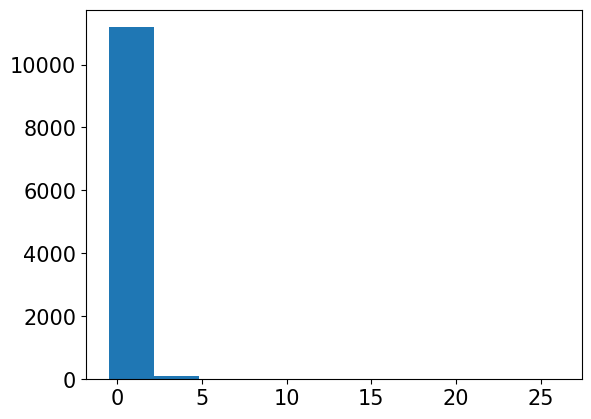

In [120]:
plt.hist(np.concatenate(exple['speed']))

In [121]:
r_allstates = np.load('rs.npz', allow_pickle = True)
keys_all = r_allstates.files
for k in keys_all:
    r_curr = r_allstates[k].item()
    keys_curr = r_curr.keys()
    for kc in keys_curr:
        print(k, kc, np.mean(r_curr[kc]))

lv RSC_mean 0.7327228750807385
lv Cg_mean 0.5664377852460352
lv PrL_mean 0.4854348014525238
lv AI_mean 0.4127163573786371
lv RSC,Cg_corr 0.6075589556032022
lv RSC,PrL_corr 0.3275638169746324
lv Cg,PrL_corr 0.6473924688947519
lv AI,RSC_corr -0.6263212471505627
lv AI,Cg_corr -0.07060812396339172
lv AI,PrL_corr -0.15422519333939133
lv RSC_entropy -0.5141403368982755
lv Cg_entropy -0.6461532516299722
lv PrL_entropy -0.4809358466704947
lv AI_entropy -0.6372321620135433
acc RSC_mean -0.5495043112112195
acc Cg_mean -0.4315829598568296
acc PrL_mean -0.4886291226568485
acc AI_mean -0.4044786659754516
acc RSC,Cg_corr -0.5855934439128802
acc RSC,PrL_corr -0.25789108253255294
acc Cg,PrL_corr -0.365579087771434
acc AI,RSC_corr 0.4884018607204995
acc AI,Cg_corr 0.1801626108110723
acc AI,PrL_corr 0.15136459931622417
acc RSC_entropy 0.40154811068124674
acc Cg_entropy 0.47989409425846885
acc PrL_entropy 0.39444776242658336
acc AI_entropy 0.5049592192850237
av RSC_mean -0.7792940897685211
av Cg_mean -0.